# Capstone Project 
# **A Trading Strategy using Liquid Futures: can we improve classic Momentum strategies by using ML and AI**
## Claudio Ferrarese

This notebook was submitted as part of the Imperial College Certificate in Machine Learning and AI 2024 Capstone Project.

## Data Sources

We use multiple Excel files where the data was pre-loaded from Bloomberg. We cover different asset classes (Bonds, Credit, Equity, Commodities, and FX) and merge them into a single DataFrame. The files and data are described in the code but cannot be included for rights reasons. Please refer to data_sheet.md for a full description.

Size approximately 250,000 rows with 40 different time series. Memory usage approx 38 MB to start.

## Code Overview

The code in this notebook is divided in several parts:

### Part 1: Data Processing

We load Bonds, Credit, Equity, Commodities, and FX data from xlsx files and merges them into a single DataFrame. It then restructures the data by melting it into a long format and using a custom function to pivot it, creating a more organized structure with dates and securities as indices. The code processes this data by converting dates to datetime format, cleaning up column names, and setting the date as the index. Finally, it performs some column renaming and cleanup by dropping redundant columns and displaying the first 10 rows of the transformed dataset. There is a lot of data analysis and checks, including statistics and charts.

### Part 2: Feature Engineering

We add volatility regimes data. This will be used to analyse the basic momentum strategy but not used as a feature in the ML/AI version.

Then we generates **trading signals** based on different strategies (EMA crossover, returns, or variance spread), where for EMA it compares short vs long-term moving averages, for Returns it looks at price changes over different periods, and for VarSpr it uses variance calculations.

These signals are calculated for each specified lookback period (stored in lookback_periods) and grouped by 'Contract', resulting in binary signals (1 for buy, -1 for sell) that are stored in new columns with names indicating the strategy and periods used.

The function is called twice: first to generate Return-based signals for longer periods (20 to 260), then to generate EMA crossover signals for shorter periods (4 to 64), with all results being added as new columns to the DataFrame. Variance spread is not used in the final version.

We reach a memory usage approx 66 MB of the dataframe

### Part 3: Create a Simple Momentum Strategy

Like in a plain vanilla CTA using previously calculated signals equal weighted. This strategy will be then used to benchmark the performance of the ML/AI which will have the possibility to come up with something potentially more clever than simple average.

A baseline trend-following CTA (Commodity Trading Advisor) strategy that will be used as a benchmark. In this basic strategy, it's simply taking all the previously generated signals (both from EMA crossovers and return-based signals with different lookback periods) and combining them with equal weights - essentially just averaging them together to produce a final trading signal. This straightforward approach will serve as a comparison point for a more sophisticated machine learning/AI model, which could potentially discover more complex or effective ways of combining these signals beyond just taking their average.

The key contrast being set up is between the "plain vanilla" equal-weighted signal combination versus what an AI might discover - for example, the AI could potentially learn to give different weights to different signals, identify which signals work better in different market conditions, or find non-linear relationships between signals that the simple averaging approach misses.

We target a **volatility of 5% for each contract**. For each futures/CDS contract, we scale the position size to target a consistent 5% annual volatility. This is possible due to the leveraged nature of these instruments, which allows us to precisely adjust our exposure (assuming sufficient capital to handle minimum contract sizes).

### Part 4: ML Model

**Implement trading strategy classification** system that identifies buy/sell/hold signals based on future price movements across multiple time windows (1 to 5 days).
The core function calculate_percentile_based_alpha (in three variants: optimized, growing_window, and simple) calculates thresholds for classifying price movements using percentiles of historical returns.
classify_price_movement uses these thresholds to label each period as Buy/Sell/Hold based on whether future returns exceed the calculated thresholds.
Applies this classification across multiple time windows (1 to 5 periods) and uses majority voting to determine the final signal.
Apply the classification process to each contract in the dataset independently, we will target this variables in our classification ML/AI job later on

We reach a memory usage approx 168 MB of the dataframe. there are now a n

**ML Models: Random Forest, XGBoost**
I implement a time series classification pipeline supporting both Random Forest and XGBoost models. For hyperparameter tuning, it uses GridSearchCV with TimeSeriesSplit (5 folds) to maintain temporal ordering. 

For **Random Forest**, it tunes:
- n_estimators: [100, 200] (number of trees)
- max_depth: [5, 10, 20] (tree depth for complexity control)
- min_samples_split: [2, 5, 10] (minimum samples before splitting)
- min_samples_leaf: [1, 2, 4] (minimum samples in leaf nodes)
- max_features: ['sqrt', 'log2'] (feature selection strategy)

For **XGBoost**, it optimizes:
- n_estimators: [100, 200] (number of trees)
- max_depth: [3, 6, 9] (tree depth)
- learning_rate: [0.01, 0.05] (boosting learning rate)
- min_child_weight: [1, 3] (minimum sum of instance weight)
- subsample: [0.8, 0.9] (training data sampling)
- colsample_bytree: [0.8, 0.9] (feature sampling)
- gamma: [0, 0.1, 0.2] (minimum loss reduction)

The best parameters found were max_depth=10, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, n_estimators=200 for Random Forest, and colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8 for XGBoost, both achieving around 39% accuracy.

The pipeline includes preprocessing (StandardScaler for numerical features, OneHotEncoder for categorical features) and maintains prop


### Part 5: AI Model using Transormer

A transformer-based neural network with the following components:
- Input Layer Normalization
- Embedding Layer (d_model=32)
- Transformer Encoder
  - 2-head self-attention mechanism
  - Feed-forward network (dimension=64)
  - Dropout rate of 0.1
- Global Average Pooling
- Classification Head
  - Two-layer network with ReLU activation
  - Final projection to 3 classes
umber of Data unneces, befoire ML and AIsary columns will be removed later

## Key Results

### Simple Momentum Strategy: Cross-asset Diversification Benefits

The overall Equal-Weighted Portfolio achieves a Sharpe ratio of 0.66 (Sortino 0.90), which is particularly impressive given it's calculated over a 27-year period that includes multiple crisis events. This outperforms most individual contracts and demonstrates key features of the strategy:

### 1. Diversification Effects
* Individual contracts target 5% volatility, but the overall EW Portfolio achieves just 2.63% volatility
* Max drawdown of only -5.85% compared to -20% to -40% for individual contracts
* The reduced Signal Std (0.33 vs 0.70 for individual contracts) shows effective signal averaging

### 2. Asset Class Performance (by Sharpe)
* Credit (0.60): Best performing asset class, though shorter history (~17 years)
* Bonds (0.51): Strong and consistent across most instruments
* Commodities (0.60): High dispersion between winners (Brent 0.58) and losers (Wheat -0.01)
* Equities (0.26): Lower Sharpes but good diversification benefits
* FX (0.18): Lowest Sharpes but provided crucial diversification

### 3. Key Success Factors
* Win rate of 53.29% for overall portfolio vs ~50% for individual contracts
* Profit factor of 1.12 indicating consistent positive skew
* Annual Return/Max DD ratio of 0.29 showing good risk-adjusted performance across market cycles

This suggests the strategy's success comes more from risk reduction through diversification than from individual contract prediction power - a classic characteristic of traditional CTA strategies that would serve as a good benchmark for more sophisticated ML approaches.

### 4. Performance by VOL Quintile

The analysis compares portfolio returns across VIX and MOVE quintiles, with surprisingly similar patterns in both volatility measures. Lower volatility environments (Quintile 1) show the best risk-adjusted returns (SR of 0.94 for VIX and 1.17 for MOVE), suggesting the strategy works best in calm markets. The returns (mean) are relatively stable across quintiles, but risk (std) increases in higher quintiles, particularly in Quintile 5 where std jumps to 0.0022 for VIX and 0.0020 for MOVE. Sample sizes vary considerably across quintiles (e.g., VIX ranges from 674 to 2032 observations).nsiderably across quintiles (e.g., VIX ranges from 674 to 2032 observation
## Key ML and AI Results



### Equal-Weighted Portfolio Performance: Model Comparison (01/01/21 to 14/09/24)

| Metric | Simple Momentum | RF + XGBoost | AI Transformer |
|--------|-----------------|--------------|----------------|
| Contract | EW Portfolio | Portfolio Average | Portfolio Average |
| Annualized_Return | 1.03% | 1.02% | 3.64% |
| Annualized_Volatility | 2.49% | 1.90% | 1.59% |
| Sharpe_Ratio | 0.41 | 0.54 | 2.29 |
| Max_Drawdown | -8.87% | -3.14% | -1.10% |
| Skewness | -0.40 | -0.63 | -0.29 |
| Kurtosis | 3.03 | 4.58 | 4.73 |
| Total_Return | 3.97% | 3.96% | 14.59% |
| Number_of_Days | 961.0 | 961.0 | 961.0 |

Key Insights:
1. Performance Comparison:
   - AI Transformer significantly outperforms both Simple Momentum and RF + XGBoost strategies
   - While Simple Momentum and RF + XGBoost show similar returns (~1%), AI Transformer achieves 3.64%
   - Total return for AI Transformer (14.59%) is nearly 4x higher than other approaches

2. Risk Management:
   - AI Transformer shows the lowest volatility (1.59%)
   - Maximum drawdown improves dramatically from Simple Momentum (-8.87%) to AI Transformer (-1.10%)
   - Risk-adjusted returns (Sharpe Ratio) are significantly better with AI Transformer (2.29)

3. Statistical Properties:
   - All strategies show negative skewness, with RF + XGBoost showing the most negative (-0.63)
   - ML-based approaches (RF + XGBoost and AI Transformer) show higher kurtosis
   - Performance measured over the same 961-day period for all strategies

4. Model Evolution:
   - Clear improvement in risk-adjusted performance from traditional to advanced ML approaches
   - AI Transformer achieves better returns while maintaining lower risk metrics
   - Machine learning approaches (both traditional and deep learning) show better drawdown control).ably across quintiles (e.g., VIX ranges from 674 to 2032 observations).les.



# **Part 1 Data Processing**


This code imports financial market data from multiple Excel fil were the data was pre-loaded from Bloomberg. We are s covering different asset classes (Bonds, Credit, Equity, Commodities, and FX) and merges them into a single DataFrame. It then restructures the data by melting it into a long format and using a custom function to pivot it, creating a more organized structure with dates and securities as indices. The code processes this data by converting dates to datetime format, cleaning up column names, and setting the date as the index. Finally, it performs some column renaming and cleanup by dropping redundant columns and displaying the first 10 rows of the transformed dataset.

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Read the Excel file
df1 = pd.read_excel('Data/rates_futures_orig.xlsx')
df1['Asset Class'] = 'Bond'
df2 = pd.read_excel('Data/credit_orig.xlsx')
df2['Asset Class'] = 'Credit'
df = pd.concat([df1, df2], axis=0, ignore_index=True)
df3 = pd.read_excel('Data/equity_futures_orig.xlsx')
df3['Asset Class'] = 'Equity'
df = pd.concat([df, df3], axis=0, ignore_index=True)
df4 = pd.read_excel('Data/comdty_futures_orig.xlsx')
df4['Asset Class'] = 'Comdty'
df = pd.concat([df, df4], axis=0, ignore_index=True)
df5 = pd.read_excel('Data/FX_futures_orig.xlsx')
df5['Asset Class'] = 'FX'
df = pd.concat([df, df5], axis=0, ignore_index=True)

df_v = pd.read_excel('Data/ImplVol_orig.xlsx')
# Display the first few rows
print(df.head())
print(df_v.head())

         security       date  PX_LAST Asset Class
0  ACTSTYUE Index 1998-01-02  1420.18        Bond
1  ACTSTYUE Index 1998-01-05  1432.38        Bond
2  ACTSTYUE Index 1998-01-06  1433.56        Bond
3  ACTSTYUE Index 1998-01-07  1430.02        Bond
4  ACTSTYUE Index 1998-01-08  1435.53        Bond
    security       date  PX_LAST
0  VIX Index 1998-01-02    23.42
1  VIX Index 1998-01-05    24.36
2  VIX Index 1998-01-06    25.66
3  VIX Index 1998-01-07    25.07
4  VIX Index 1998-01-08    26.01


In [4]:
def rearrange_dataframe(df):
    """
    Rearrange the DataFrame to have date and security as index,
    and separate columns for each field.
    """
  
    df['date'] = pd.to_datetime(df['date'])
    df_pivot = df.pivot(index=['date', 'security'], columns='field', values='value')
    # Reset index to make date and security regular columns
    df_pivot = df_pivot.reset_index()
    df_pivot = df_pivot.sort_values(['date', 'security'])
    # Reset index to get integer index
    df_pivot = df_pivot.reset_index(drop=True)
    
    return df_pivot
    
# Melt the DataFrame to long format
df_melted = df.melt(id_vars=['date', 'security'], var_name='field', value_name='value')
    
# Rearrange the DataFrame
df_rearranged = rearrange_dataframe(df_melted)
print(df_rearranged.head())

field       date         security Asset Class   PX_LAST
0     1998-01-01  AUDUSDCR Curncy          FX  107.2092
1     1998-01-01  CADUSDCR Curncy          FX  107.9155
2     1998-01-01  CHFUSDCR Curncy          FX   98.0092
3     1998-01-01  EURUSDCR Curncy          FX   94.2809
4     1998-01-01  GBPUSDCR Curncy          FX   97.3619


In [5]:
# adjust some fields in the main df
df_rearranged['Date'] = pd.to_datetime(df_rearranged['date'])
df_rearranged['Contract'] = df_rearranged['security']
df_rearranged['Price'] = df_rearranged['PX_LAST']
df_rearranged.set_index('Date', inplace=True)
df_rearranged = df_rearranged.drop(['date','security','PX_LAST'], axis=1)
df_rearranged.head(10)


field      Asset Class         Contract     Price
Date                                             
1998-01-01          FX  AUDUSDCR Curncy  107.2092
1998-01-01          FX  CADUSDCR Curncy  107.9155
1998-01-01          FX  CHFUSDCR Curncy   98.0092
1998-01-01          FX  EURUSDCR Curncy   94.2809
1998-01-01          FX  GBPUSDCR Curncy   97.3619
1998-01-01        Bond   JFBA3XMU Index  141.3504
1998-01-01          FX  JPYUSDCR Curncy   91.1908
1998-01-01          FX  NOKUSDCR Curncy  102.8235
1998-01-01          FX  NZDUSDCR Curncy  107.9501
1998-01-01          FX  SEKUSDCR Curncy  103.4054

In [6]:
df_v_melted = df_v.melt(id_vars=['date', 'security'], var_name='field', value_name='value')
df_vol_r = rearrange_dataframe(df_v_melted)

In [7]:
# adjust some fields in the vol df
df_vol_r['Date'] = pd.to_datetime(df_vol_r['date'])
df_vol_r['Contract'] = df_vol_r['security']
df_vol_r['Price'] = df_vol_r['PX_LAST']
df_vol_r.set_index('Date', inplace=True)
df_vol_r = df_vol_r.drop(['date','security','PX_LAST'], axis=1)
df_vol_r.head(5)

field         Contract  Price
Date                         
1998-01-01  MOVE Index  90.54
1998-01-02  MOVE Index  91.21
1998-01-02   VIX Index  23.42
1998-01-05  MOVE Index  92.90
1998-01-05   VIX Index  24.36

In [8]:
# Get unique asset classes
asset_classes = df_rearranged['Asset Class'].unique()

# Loop through each asset class and print its contracts
for asset_class in asset_classes:
    contracts = df_rearranged[df_rearranged['Asset Class'] == asset_class]['Contract'].unique()
    print(f"\n{'-'*50}")
    print(f"Asset Class: {asset_class}")
    print(f"Number of Unique Contracts: {len(contracts)}")
    print(f"{'-'*50}")
    for i, contract in enumerate(contracts, 1):
        print(f"{i}. {contract}")


--------------------------------------------------
Asset Class: FX
Number of Unique Contracts: 9
--------------------------------------------------
1. AUDUSDCR Curncy
2. CADUSDCR Curncy
3. CHFUSDCR Curncy
4. EURUSDCR Curncy
5. GBPUSDCR Curncy
6. JPYUSDCR Curncy
7. NOKUSDCR Curncy
8. NZDUSDCR Curncy
9. SEKUSDCR Curncy

--------------------------------------------------
Asset Class: Bond
Number of Unique Contracts: 7
--------------------------------------------------
1. JFBA3XMU Index
2. ACTSTYUE Index
3. CSRFCNCE Index
4. ACTSRXEE Index
5. JFBG3GUS Index
6. SPEUBPTR Index
7. CIRBKA12 Index

--------------------------------------------------
Asset Class: Comdty
Number of Unique Contracts: 13
--------------------------------------------------
1. BO1 Comdty
2. C 1 Comdty
3. CL1 Comdty
4. CO1 Comdty
5. GC1 Comdty
6. HG1 Comdty
7. HO1 Comdty
8. NG1 Comdty
9. S 1 Comdty
10. SI1 Comdty
11. SM1 Comdty
12. W 1 Comdty
13. XB1 Comdty

--------------------------------------------------
Asset Class

## mapping dictionaries 
This code creates two mapping dictionaries - first mapping financial instrument Bloomberg tickers to their common names across different asset classes (Bonds, Credit, Equity, Commodities, and FX), and second mapping these instruments to their transaction costs (with FX having lower costs at 1bp versus 2bp for other assets). The code then applies these mappings to a DataFrame by replacing the contract names and adding a new transaction cost column. Finally, it creates a separate mapping for volatility indices (like VIX, MOVE) and applies it to a different DataFrame containing volatility data.

In [10]:
name_mapping = {
    'ACTSTYUE Index': 'TY',    # Bonds
    'CSRFCNCE Index': 'CN',
    'ACTSRXEE Index': 'RX',
    'JFBG3GUS Index': 'G',
    'CBKIJ0FT Index': 'JB',
    'CIRBKA12 Index': 'KTB',
    'JFBA3XMU Index': 'XM',
    'SPEUBPTR Index': 'IK',
    'ERIXCDIG Index': 'CDXIG',    # Credit
    'ERIXITEU Index': 'Main',
    'ERIXITXO Index': 'Xover',
    'ERINCDEM Index': 'CDXEM',
    'ERINCDHY Index': 'CDXHY',
    'ES1 Index': 'S&P500',       # Equity
    'HI1 Index': 'HangSeng',
    'Z 1 Index': 'Ftse100',
    'NK1 Index': 'Nikkei225',
    'VG1 Index': 'DJEuroStoxx50',
    'NQ1 Index': 'Nasdaq100',
    'CO1 Comdty': 'Brent Crude',       # Comdty
    'HG1 Comdty': 'Copper',
    'C 1 Comdty': 'Corn',
    'XB1 Comdty': 'Gasoline RBOB',
    'GC1 Comdty': 'Gold 100 OZ',
    'NG1 Comdty': 'Natural Gas',
    'HO1 Comdty': 'NY Harb ULSD',
    'SI1 Comdty': 'Silver',
    'S 1 Comdty': 'Soybean',
    'SM1 Comdty': 'Soybean Meal',
    'BO1 Comdty': 'Soybean Oil',
    'W 1 Comdty': 'Wheat',
    'CL1 Comdty': 'WTI Crude',    
    'AUDUSDCR Curncy': 'Australian Dollar',    #FX
    'GBPUSDCR Curncy': 'British Pound Sterling',
    'CADUSDCR Curncy': 'Canadian Dollar',
    'EURUSDCR Curncy': 'Euro',
    'JPYUSDCR Curncy': 'Japanese Yen',
    'NZDUSDCR Curncy': 'New Zealand Dollar',
    'NOKUSDCR Curncy': 'Norwegian Krone',
    'SEKUSDCR Curncy': 'Swedish Krona',
    'CHFUSDCR Curncy': 'Swiss Franc'
}

# Create transaction cost mapping using the same contract names , usually 1 bp or 2 bp assuming FULL BID_ASK
tc_mapping = {
    'TY': 0.0002,      # Bonds
    'CN': 0.0002,
    'RX': 0.0002,
    'G': 0.0002,
    'JB': 0.0002,
    'KTB': 0.0002,
    'XM': 0.0002,
    'IK': 0.0002,
    'CDXIG': 0.0002,   # Credit
    'Main': 0.0002,
    'Xover': 0.0002,
    'CDXEM': 0.0002,
    'CDXHY': 0.0002,
    'S&P500': 0.0002,  # Equity
    'HangSeng': 0.0002,
    'Ftse100': 0.0002,
    'Nikkei225': 0.0002,
    'DJEuroStoxx50': 0.0002,
    'Nasdaq100': 0.0002,
    'Brent Crude': 0.0002,    # Comdty
    'Copper': 0.0002,
    'Corn': 0.0002,
    'Gasoline RBOB': 0.0002,
    'Gold 100 OZ': 0.0002,
    'Natural Gas': 0.0002,
    'NY Harb ULSD': 0.0002,
    'Silver': 0.0002,
    'Soybean': 0.0002,
    'Soybean Meal': 0.0002,
    'Soybean Oil': 0.0002,
    'Wheat': 0.0002,
    'WTI Crude': 0.0002,
    'Australian Dollar': 0.0001,   #FX
    'British Pound Sterling': 0.0001,
    'Canadian Dollar': 0.0001,
    'Euro': 0.0001,
    'Japanese Yen': 0.0001,
    'New Zealand Dollar': 0.0001,
    'Norwegian Krone': 0.0001,
    'Swedish Krona': 0.0001,
    'Swiss Franc': 0.0001
    }

df_rearranged['Contract'] = df_rearranged['Contract'].replace(name_mapping)

# Add the Transaction_Cost_Pct column based on the mapping
df_rearranged['Transaction_Cost'] = df_rearranged['Contract'].map(tc_mapping) 



# Display the updated DataFrame
#print(df_rearranged.tail(20))

name_mapping = {
    'MOVE Index': 'MOVE',
    'VIX Index': 'VIX',
    'V2X Index': 'V2X',
    'VIXHY Index': 'VIXHY',
    'VIXXO Index': 'VIXXO',
}
df_vol_r['Contract'] = df_vol_r['Contract'].replace(name_mapping)



In [11]:
# Get unique asset classes
asset_classes = df_rearranged['Asset Class'].unique()

# Loop through each asset class and print its contracts
for asset_class in asset_classes:
    contracts = df_rearranged[df_rearranged['Asset Class'] == asset_class]['Contract'].unique()
    print(f"\n{'-'*50}")
    print(f"Asset Class: {asset_class}")
    print(f"Number of Contracts: {len(contracts)}")
    print(f"{'-'*50}")
    for i, contract in enumerate(contracts, 1):
        print(f"{i}. {contract}")


--------------------------------------------------
Asset Class: FX
Number of Contracts: 9
--------------------------------------------------
1. Australian Dollar
2. Canadian Dollar
3. Swiss Franc
4. Euro
5. British Pound Sterling
6. Japanese Yen
7. Norwegian Krone
8. New Zealand Dollar
9. Swedish Krona

--------------------------------------------------
Asset Class: Bond
Number of Contracts: 7
--------------------------------------------------
1. XM
2. TY
3. CN
4. RX
5. G
6. IK
7. KTB

--------------------------------------------------
Asset Class: Comdty
Number of Contracts: 13
--------------------------------------------------
1. Soybean Oil
2. Corn
3. WTI Crude
4. Brent Crude
5. Gold 100 OZ
6. Copper
7. NY Harb ULSD
8. Natural Gas
9. Soybean
10. Silver
11. Soybean Meal
12. Wheat
13. Gasoline RBOB

--------------------------------------------------
Asset Class: Equity
Number of Contracts: 6
--------------------------------------------------
1. S&P500
2. HangSeng
3. Ftse100
4. Nikkei

In [12]:

def calculate_financial_metrics(prices):
    """
    Calculate financial metrics for a series of prices including skewness and kurtosis
    """
    # Ensure prices are float type and calculate returns
    prices = prices.astype(float)
    returns = prices.pct_change()
    returns = returns.infer_objects(copy=False)
    returns = returns.dropna()
    
    # metrics:
    n_years = (prices.index[-1] - prices.index[0]).days / 365.25
    total_return = (prices.iloc[-1] / prices.iloc[0]) - 1
    ann_return = (1 + total_return) ** (1/n_years) - 1
    ann_vol = returns.std() * np.sqrt(252)
    # Sharpe ratio (assuming risk-free rate of 0 for simplicity)
    sharpe = ann_return / ann_vol if ann_vol != 0 else 0
    # Maximum drawdown
    cumulative_returns = (1 + returns).cumprod()
    rolling_max = cumulative_returns.expanding(min_periods=1).max()
    drawdowns = cumulative_returns / rolling_max - 1
    max_drawdown = drawdowns.min()
    # Calculate skewness and kurtosis
    skewness = stats.skew(returns)
    # Using excess kurtosis (normal distribution = 0)
    kurtosis = stats.kurtosis(returns)
    return {
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_drawdown,
        'Skewness': skewness,
        'Kurtosis': kurtosis
    }

def create_contract_summary(df):
    """
    Creates a summary table for each contract showing start date, end date, number of points,
    and financial metrics.
    """
    # Make a copy and reset index to work with Date as a column
    df_work = df.reset_index()
    # Convert Price column to float if not already
    df_work['Price'] = pd.to_numeric(df_work['Price'], errors='coerce')
    summary_data = []
    # Group by Contract
    for contract in df_work['Contract'].unique():
        # Filter data for this contract
        contract_data = df_work[df_work['Contract'] == contract]
        # Get non-zero, non-nan prices
        valid_prices = contract_data[
            (contract_data['Price'].notna()) & 
            (contract_data['Price'] != 0)
        ]
        
        if not valid_prices.empty and len(valid_prices) > 4:  # Need at least 4 points for meaningful stats
            price_series = pd.Series(
                valid_prices['Price'].values,
                index=pd.to_datetime(valid_prices['Date']),
                dtype=float
            )
            
            metrics = calculate_financial_metrics(price_series)
            
            summary_data.append({
                'Asset Class': valid_prices['Asset Class'].iloc[0],
                'Contract': contract,
                'Start Date': valid_prices.iloc[0]['Date'],
                'End Date': valid_prices.iloc[-1]['Date'],
                'Number of Points': len(valid_prices),
                'First Price': valid_prices.iloc[0]['Price'],
                'Last Price': valid_prices.iloc[-1]['Price'],
                'Annualized Return': metrics['Annualized Return'],
                'Annualized Volatility': metrics['Annualized Volatility'],
                'Sharpe Ratio': metrics['Sharpe Ratio'],
                'Max Drawdown': metrics['Max Drawdown'],
                'Skewness': metrics['Skewness'],
                'Kurtosis': metrics['Kurtosis']
            })

    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values(['Asset Class', 'Contract'])
    summary_df['Start Date'] = pd.to_datetime(summary_df['Start Date']).dt.strftime('%Y-%m-%d')
    summary_df['End Date'] = pd.to_datetime(summary_df['End Date']).dt.strftime('%Y-%m-%d')
    numeric_cols = ['First Price', 'Last Price', 'Annualized Return', 
                   'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown',
                   'Skewness', 'Kurtosis']
    
    for col in numeric_cols:
        summary_df[col] = summary_df[col].round(4)

    for col in ['Annualized Return', 'Annualized Volatility', 'Max Drawdown']:
        summary_df[col] = summary_df[col] * 100

    column_order = [
        'Asset Class',
        'Contract',
        'Start Date',
        'End Date',
        'Number of Points',
        'Annualized Return',
        'Annualized Volatility',
        'Sharpe Ratio',
        'Max Drawdown',
        'Skewness',
        'Kurtosis'
    ]
    
    summary_df = summary_df[column_order]
    
    return summary_df

def print_summary_stats(summary_df):
    """
    Prints additional summary statistics about the data
    """
    print("\nSummary Statistics:")
    print("-" * 50)

    print("\nContracts by Asset Class:")
    print(summary_df['Asset Class'].value_counts())

    print("\nOverall Date Range:")
    print(f"Earliest Start Date: {summary_df['Start Date'].min()}")
    print(f"Latest End Date: {summary_df['End Date'].max()}")
    
    print("\nPoints Statistics:")
    print(summary_df['Number of Points'].describe())

    print("\nPerformance Statistics by Asset Class:")
    metrics = ['Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 
              'Max Drawdown', 'Skewness', 'Kurtosis']
    print(summary_df.groupby('Asset Class')[metrics].mean().round(2))

#  usage:

summary_table = create_contract_summary(df_rearranged)
print("\nContract Summary Table:")
#print(summary_table)
#print_summary_stats(summary_table)

# To save to Excel:
# summary_table.to_excel('contract_summary.xlsx', index=False)



Contract Summary Table:


In [17]:
summary_table

Asset Class                Contract  Start Date    End Date  \
15        Bond                      CN  1998-01-02  2024-09-05   
30        Bond                       G  1999-04-30  2024-09-06   
38        Bond                      IK  2009-09-30  2024-09-06   
39        Bond                     KTB  2010-10-25  2024-09-06   
27        Bond                      RX  1998-01-05  2024-09-05   
10        Bond                      TY  1998-01-02  2024-09-05   
5         Bond                      XM  1998-01-01  2024-09-06   
14      Comdty             Brent Crude  1998-01-02  2024-09-06   
18      Comdty                  Copper  1998-01-02  2024-09-06   
12      Comdty                    Corn  1998-01-02  2024-09-06   
32      Comdty           Gasoline RBOB  2005-10-04  2024-09-06   
17      Comdty             Gold 100 OZ  1998-01-02  2024-09-06   
20      Comdty            NY Harb ULSD  1998-01-02  2024-09-06   
21      Comdty             Natural Gas  1998-01-02  2024-09-06   
23      Comdty                  Silver  1998-01-02  2024-09-06   
22      Comdty                 Soybean  1998-01-02  2024-09-06   
24      Comdty            Soybean Meal  1998-01-02  2024-09-06   
11      Comdty             Soybean Oil  1998-01-02  2024-09-06   
13      Comdty               WTI Crude  1998-01-02  2024-09-06   
25      Comdty                   Wheat  1998-01-02  2024-09-06   
33      Credit                   CDXEM  2007-03-20  2024-09-06   
37      Credit                   CDXHY  2007-03-27  2024-09-06   
34      Credit                   CDXIG  2007-03-20  2024-09-06   
35      Credit                    Main  2007-03-20  2024-09-06   
36      Credit                   Xover  2007-03-20  2024-09-06   
29      Equity           DJEuroStoxx50  1998-06-23  2024-09-06   
26      Equity                 Ftse100  1998-01-02  2024-09-06   
19      Equity                HangSeng  1998-01-02  2024-09-06   
31      Equity               Nasdaq100  1999-06-22  2024-09-06   
28      Equity               Nikkei225  1998-01-05  2024-09-06   
16      Equity                  S&P500  1998-01-02  2024-09-06   
0           FX       Australian Dollar  1998-01-01  2024-09-06   
4           FX  British Pound Sterling  1998-01-01  2024-09-06   
1           FX         Canadian Dollar  1998-01-01  2024-09-06   
3           FX                    Euro  1998-01-01  2024-09-06   
6           FX            Japanese Yen  1998-01-01  2024-09-06   
8           FX      New Zealand Dollar  1998-01-01  2024-09-06   
7           FX         Norwegian Krone  1998-01-01  2024-09-06   
9           FX           Swedish Krona  1998-01-01  2024-09-06   
2           FX             Swiss Franc  1998-01-01  2024-09-06   

    Number of Points  Annualized Return  Annualized Volatility  Sharpe Ratio  \
15              6675               2.13                   6.01        0.3544   
30              6616               1.59                   6.86        0.2317   
38              3816               4.63                   9.42        0.4913   
39              3330               1.38                   5.59        0.2476   
27              6787               2.73                   5.79        0.4719   
10              6721               2.42                   6.00        0.4030   
5               6962               1.28                   7.44        0.1714   
14              6845               6.92                  35.94        0.1927   
18              6704               5.22                  26.13        0.1999   
12              6721              -6.55                  26.03       -0.2517   
32              4767               6.65                  39.54        0.1682   
17              6705               5.64                  17.10        0.3297   
20              6704               6.74                  36.07        0.1869   
21              6704             -23.18                  54.97       -0.4216   
23              6704               3.13                  30.52        0.1025   
22              

## see how many contratct I have at any point in time
data set is 250k rows


Number of  rows: 250776


<Figure size 1200x600 with 0 Axes>

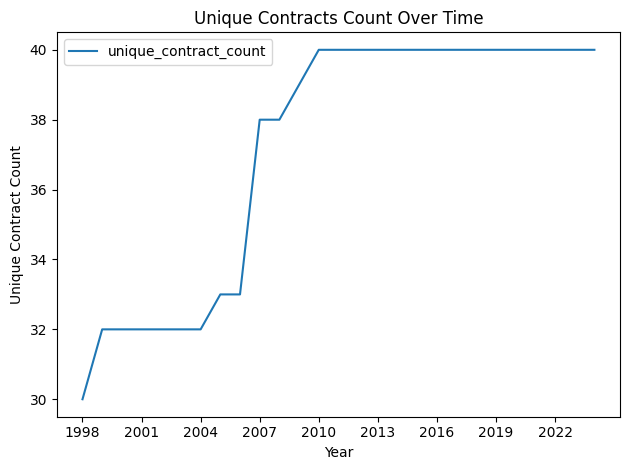

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250776 entries, 1998-01-01 to 2024-09-06
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Asset Class       250776 non-null  object 
 1   Contract          250776 non-null  object 
 2   Price             250776 non-null  object 
 3   Transaction_Cost  250776 non-null  float64
dtypes: float64(1), object(3)
memory usage: 38.1 MB


In [25]:
def analyze_and_visualize(df_rearranged):
    # Reset the index to make 'Date' a column
    df = df_rearranged.reset_index()
    
    # Convert Date to datetime and extract year
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    
    # Group by 'Year' and count unique 'Contract'
    df_count = df.groupby('Year')['Contract'].nunique().reset_index()
    df_count.columns = ['Year', 'unique_contract_count']
    df_count.set_index('Year', inplace=True)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    df_count.plot(title='Unique Contracts Count Over Time')
    plt.xlabel('Year')
    plt.ylabel('Unique Contract Count')
    
    # Calculate ticks every 5 years
    start_year = df_count.index.min()
    end_year = df_count.index.max()
    tick_years = range(start_year - (start_year % 3), end_year + 1, 3)
    plt.xticks(tick_years, rotation=0)
    
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('contracts_over_time.png', dpi=300, bbox_inches='tight')
    
    # Display the plot
    plt.show()
    
# Main execution
print(f"Number of  rows: {len(df_rearranged)}")

analyze_and_visualize(df_rearranged)
#check memery size
df_rearranged.info(memory_usage='deep')             

In [27]:

def prepare_market_data(df_prices, df_vol=None, window_short=32, window_long=252):
    """
    Prepare market data by calculating returns, volatilities, and other metrics.
    
    Parameters:
    df_prices (pd.DataFrame): DataFrame with price data
    df_vol (pd.DataFrame, optional): DataFrame with volatility data
    window_short (int): Short-term rolling window (default: 32 days)
    window_long (int): Long-term rolling window (default: 252 days)
    
    Returns:
    tuple: (processed_df, return_df, cum_return_df, correlation_matrix)
    """
    # Make copies of input DataFrames
    df = df_prices.copy()
    if df_vol is not None:
        df_vol = df_vol.copy()
        df_vol = df_vol.reset_index()
        df_vol['Date'] = pd.to_datetime(df_vol['Date'])
        df_vol = df_vol.sort_values(['Date', 'Contract'])
        
    # Reset index and ensure Date is datetime
    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Date', 'Contract'])
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df['Return'] = df.groupby('Contract')['Price'].pct_change()
    df['Cum_Return'] = df['Price']
    df = df.drop(['Price'], axis=1).reset_index(drop=True)
    
    # Calculate rolling statistics
    grouper = df.groupby('Contract')['Return']
    
    # Rolling metrics
    df['Rolling_Mean'] = (grouper.rolling(window_short)
                         .mean()
                         .reset_index(level=0, drop=True))
    
    df['Rolling_Std'] = (grouper.rolling(window_short)
                        .std()
                        .reset_index(level=0, drop=True) * np.sqrt(252))
    
    df['Annual_Vol'] = (grouper.rolling(window=window_long)
                       .std()
                       .reset_index(level=0, drop=True) * np.sqrt(252))
    
    # Calculate drawdowns using a different approach
    def calculate_drawdown(group):
        cum_max = group['Cum_Return'].expanding().max()
        drawdown = (group['Cum_Return'] - cum_max) / cum_max
        return drawdown
    
    df['Drawdown'] = df.groupby('Contract').apply(
        calculate_drawdown
    ).reset_index(level=0, drop=True)
    
    # Create pivot tables for returns and cumulative returns
    df_return = df.pivot(index='Date', columns='Contract', values='Return')
    df_cum_return = df.pivot(index='Date', columns='Contract', values='Cum_Return')
    
    # Calculate correlation matrix using 5-day rolling returns
    weekly_returns = df_return.rolling(window=5).sum()
    correlation_matrix = weekly_returns.corr()
    
    # Print summary statistics
    #print('\nAnnualized Volatilities:')
    ann_vols = df_return.std() * np.sqrt(250)
    #print(ann_vols)
    
    #print('\nCorrelation Matrix (Weekly Returns):')
    #print(correlation_matrix.round(3))
    
    return df, df_return, df_cum_return, correlation_matrix, df_vol

def get_single_contract(df, contract_code):
    """
    Extract data for a single contract.
    
    Parameters:
    df (pd.DataFrame): Processed DataFrame
    contract_code (str): Contract identifier
    
    Returns:
    pd.DataFrame: Data for the specified contract
    """
    return df[df['Contract'] == contract_code].copy()

def analyze_contracts(df):
    """
    Analyze contracts and print summary statistics.
    
    Parameters:
    df (pd.DataFrame): Processed DataFrame
    """
    # Calculate and print contract-specific statistics
    for contract in df['Contract'].unique():
        contract_data = get_single_contract(df, contract)
        print(f"\nContract: {contract}")
        print(f"Date Range: {contract_data['Date'].min()} to {contract_data['Date'].max()}")
        print(f"Annual Volatility: {contract_data['Annual_Vol'].mean():.2%}")
        print(f"Maximum Drawdown: {contract_data['Drawdown'].min():.2%}")  # Changed from max to min
        print(f"Mean Daily Return: {contract_data['Return'].mean():.4%}")

# usage:

# Process the data
df, df_return, df_cum_return, corr_matrix, df_vol = prepare_market_data(df_rearranged, df_vol_r)

# Get data for a specific contract
ik_data = get_single_contract(df, 'IK')

# Analyze all contracts
#analyze_contracts(df)

# Print the last few rows
#print("\nLast 5 rows of processed data:")
#print(df.tail())

#check memery size
df.info(memory_usage='deep')     

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250776 entries, 0 to 250775
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              250776 non-null  datetime64[ns]
 1   Asset Class       250776 non-null  object        
 2   Contract          250776 non-null  object        
 3   Transaction_Cost  250776 non-null  float64       
 4   Return            250736 non-null  float64       
 5   Cum_Return        250776 non-null  float64       
 6   Rolling_Mean      249496 non-null  float64       
 7   Rolling_Std       249496 non-null  float64       
 8   Annual_Vol        240696 non-null  float64       
 9   Drawdown          250776 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 41.9 MB


C:\Users\claud\AppData\Local\Temp\ipykernel_64628\4079132602.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['Drawdown'] = df.groupby('Contract').apply(


## 3. Feature engineering 

### VOL part Feature engineering on VIX and MOVE  (this code remains but not used as final features in the ML or AI models)

In [31]:
# Only keep VIX and MOVE
df_vol = df_vol[df_vol['Contract'].isin(['VIX', 'MOVE'])]
# Reset the index if needed
df_vol = df_vol.reset_index(drop=True)

In [33]:
def analyze_and_report_nan(df):
    """
    Analyze NaN values in a DataFrame and print the results.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame to analyze
    """
    # Count total NaN values
    total_nan = df.isna().sum().sum()
    print(f"Total number of NaN values in the DataFrame: {total_nan}")

    # Count NaN values for each column
    nan_by_column = df.isna().sum()
    print("\nNumber of NaN values in each column:")
    print(nan_by_column)

    # Calculate percentage of NaN values in each column
    nan_percentage = (df.isna().sum() / len(df)) * 100
    print("\nPercentage of NaN values in each column:")
    print(nan_percentage)

# Example usage:
# analyze_and_report_nan(df_vol_pivot)

In [35]:
df_vol_pivot = df_vol.pivot(index='Date', columns='Contract', values='Price')

#fix NANs
analyze_and_report_nan(df_vol_pivot)
df_vol_pivot = df_vol_pivot.ffill()
analyze_and_report_nan(df_vol_pivot)
df_vol_pivot = df_vol_pivot.bfill()
analyze_and_report_nan(df_vol_pivot)
df_vol_pivot.head()

Total number of NaN values in the DataFrame: 221

Number of NaN values in each column:
Contract
MOVE     29
VIX     192
dtype: int64

Percentage of NaN values in each column:
Contract
MOVE    0.418894
VIX     2.773364
dtype: float64
Total number of NaN values in the DataFrame: 1

Number of NaN values in each column:
Contract
MOVE    0
VIX     1
dtype: int64

Percentage of NaN values in each column:
Contract
MOVE    0.000000
VIX     0.014445
dtype: float64
Total number of NaN values in the DataFrame: 0

Number of NaN values in each column:
Contract
MOVE    0
VIX     0
dtype: int64

Percentage of NaN values in each column:
Contract
MOVE    0.0
VIX     0.0
dtype: float64


Contract      MOVE    VIX
Date                     
1998-01-01   90.54  23.42
1998-01-02   91.21  23.42
1998-01-05   92.90  24.36
1998-01-06   94.61  25.66
1998-01-07  104.35  25.07

In [37]:
#using a growing window approach, which is more appropriate for a trading scenario as it avoids look-ahead bias.

def calculate_growing_window_quintiles_with_boundaries(df, column_input, min_window=260):
    result_df = df.copy()
    result_df[f'{column_input}_Quintale'] = np.nan
    
    # Initialize columns for quintile boundary values
    for q in [0.2, 0.4, 0.6, 0.8]:
        result_df[f'{column_input}_Q{int(q*100)}'] = np.nan
    
    for i in range(min_window, len(df)):
        growing_window = df[column_input].iloc[:i]
        quintiles = pd.qcut(growing_window, q=5, labels=False, duplicates='drop')
        #add 1 to have 1 to 5...
        result_df.loc[df.index[i], f'{column_input}_Quintale'] = quintiles.iloc[-1]+1
        
        # Calculate and store quintile boundary values
        for q in [0.2, 0.4, 0.6, 0.8]:
            result_df.loc[df.index[i], f'{column_input}_Q{int(q*100)}'] = growing_window.quantile(q)
    
    return result_df

def calculate_rolling_window_quintiles(df, column_input, window=260*3):
    """
    Calculate quintiles using a rolling window instead of an expanding window
    The boundaries become more adaptive to new market conditions

    """
    result_df = df.copy()
    result_df[f'{column_input}_Quintale'] = np.nan
    
    # Initialize columns for quintile boundary values
    for q in [0.2, 0.4, 0.6, 0.8]:
        result_df[f'{column_input}_Q{int(q*100)}'] = np.nan
    
    for i in range(window, len(df)):
        # Use rolling window instead of growing window
        rolling_window = df[column_input].iloc[i-window:i]
        quintiles = pd.qcut(rolling_window, q=5, labels=False, duplicates='drop')
        result_df.loc[df.index[i], f'{column_input}_Quintale'] = quintiles.iloc[-1]+1
        
        # Calculate and store quintile boundary values
        for q in [0.2, 0.4, 0.6, 0.8]:
            result_df.loc[df.index[i], f'{column_input}_Q{int(q*100)}'] = rolling_window.quantile(q)
    
    return result_df
    
#vix_df_quint = calculate_growing_window_quintiles_with_boundaries(df_vol_pivot, column_input='VIX')
#move_df_quint = calculate_growing_window_quintiles_with_boundaries(df_vol_pivot, column_input='MOVE')

vix_df_quint = calculate_rolling_window_quintiles(df_vol_pivot, column_input='VIX', window=260*5)
move_df_quint = calculate_rolling_window_quintiles(df_vol_pivot, column_input='MOVE', window=260*5)

vix_df_quint=vix_df_quint.drop('MOVE', axis=1)
move_df_quint=move_df_quint.drop('VIX', axis=1)
print(vix_df_quint.tail())
print(move_df_quint.tail())


Contract      VIX  VIX_Quintale  VIX_Q20  VIX_Q40  VIX_Q60  VIX_Q80
Date                                                               
2024-09-02  15.55           2.0    14.45   17.632   21.324   26.222
2024-09-03  20.72           2.0    14.45   17.632   21.324   26.222
2024-09-04  21.32           3.0    14.45   17.632   21.324   26.222
2024-09-05  19.90           3.0    14.45   17.652   21.324   26.222
2024-09-06  22.38           3.0    14.45   17.652   21.320   26.222
Contract      MOVE  MOVE_Quintale  MOVE_Q20  MOVE_Q40  MOVE_Q60  MOVE_Q80
Date                                                                     
2024-09-02  107.77            4.0    57.960   77.9040   105.728    121.15
2024-09-03  114.20            4.0    58.004   77.9760   105.756    121.15
2024-09-04  119.15            4.0    58.004   78.0720   105.812    121.15
2024-09-05  114.81            4.0    58.004   78.1347   105.872    121.15
2024-09-06  107.24            4.0    58.004   78.2438   105.934    121.15


In [38]:
# For a more detailed summary with percentages
vix_df_quint_summary = pd.DataFrame({
    'Count': vix_df_quint['VIX_Quintale'].value_counts().sort_index(),
    'Percentage': (vix_df_quint['VIX_Quintale'].value_counts().sort_index() / len(move_df_quint) * 100).round(2)
})
print("\nDetailed summary of VIX_Quintale distribution:")
print(vix_df_quint_summary)

move_quintile_summary = pd.DataFrame({
    'Count': move_df_quint['MOVE_Quintale'].value_counts().sort_index(),
    'Percentage': (move_df_quint['MOVE_Quintale'].value_counts().sort_index() / len(move_df_quint) * 100).round(2)
})
print("\nDetailed summary of MOVE_Quintale distribution:")
print(move_quintile_summary)


Detailed summary of VIX_Quintale distribution:
              Count  Percentage
VIX_Quintale                   
1.0            2032       29.35
2.0             853       12.32
3.0             674        9.74
4.0             811       11.71
5.0            1253       18.10

Detailed summary of MOVE_Quintale distribution:
               Count  Percentage
MOVE_Quintale                   
1.0             1822       26.32
2.0              802       11.58
3.0             1044       15.08
4.0              905       13.07
5.0             1050       15.17



Yearly Distribution of VIX Quintiles (%):
VIX_Quintale    1.0    2.0    3.0    4.0    5.0
Date                                           
2002            NaN    NaN    NaN  50.00  50.00
2003          63.98   7.28   4.21   8.43  16.09
2004          95.42   4.58    NaN    NaN    NaN
2005          91.54   8.46    NaN    NaN    NaN
2006          70.77  18.85   9.23   1.15    NaN
2007          16.48  19.16  14.56  16.09  33.72
2008            NaN    NaN    NaN   7.25  92.75
2009            NaN    NaN   4.98  38.31  56.70
2010            NaN  10.73  47.89  27.59  13.79
2011           2.31  43.46  13.85  13.46  26.92
2012          58.24  30.65   9.96   1.15    NaN
2013          85.06  12.64   2.30    NaN    NaN
2014          65.52  22.22   6.51   3.83   1.92
2015          19.92  29.50  19.54  16.48  14.56
2016          28.35  24.52  16.86  12.26  18.01
2017          89.62   4.23   3.46   2.69    NaN
2018          10.16  22.27  10.94  16.80  39.84
2019           1.19  21.83  26.19  33.73  17.

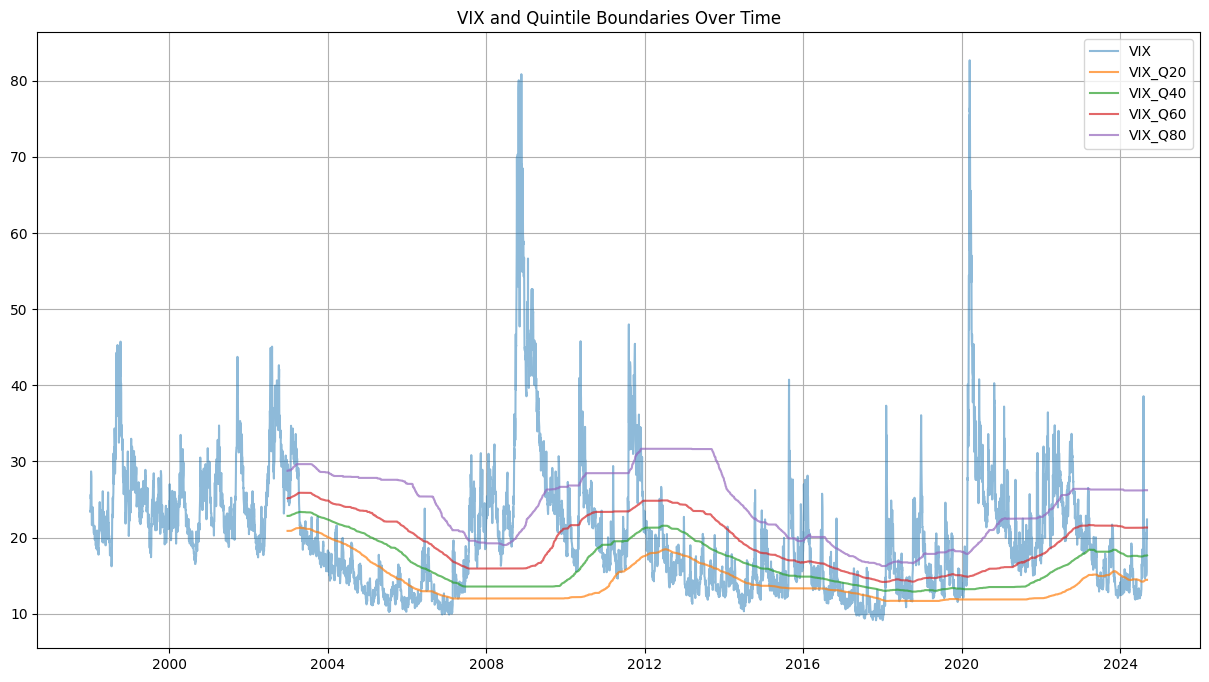

In [39]:
# Calculate the distribution of quintiles by year
yearly_dist = vix_df_quint.groupby([vix_df_quint.index.year, 'VIX_Quintale']).size().unstack()
yearly_pct = yearly_dist.div(yearly_dist.sum(axis=1), axis=0) * 100

print("\nYearly Distribution of VIX Quintiles (%):")
print(yearly_pct.round(2))

# Calculate average VIX by year
yearly_vix = vix_df_quint.groupby(vix_df_quint.index.year)['VIX'].agg(['mean', 'std', 'min', 'max'])
print("\nYearly VIX Statistics:")
print(yearly_vix.round(2))

# Plot the evolution of quintile boundaries
boundary_cols = [col for col in vix_df_quint.columns if 'VIX_Q' in col and 'Quintale' not in col]
quintile_boundaries = vix_df_quint[boundary_cols].copy()
quintile_boundaries['VIX'] = vix_df_quint['VIX']

# Create a plot of VIX and its boundaries over time
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.plot(quintile_boundaries.index, quintile_boundaries['VIX'], label='VIX', alpha=0.5)
for col in boundary_cols:
    plt.plot(quintile_boundaries.index, quintile_boundaries[col], label=col, alpha=0.7)
plt.title('VIX and Quintile Boundaries Over Time')
plt.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='Date'>

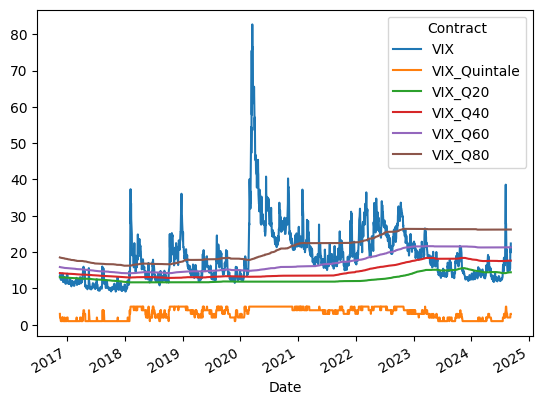

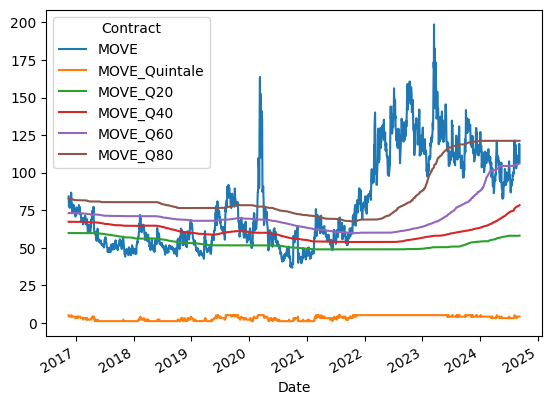

In [40]:

vix_df_quint.tail(2000).plot()
move_df_quint.tail(2000).plot()



In [41]:
## add VOL features to main df 
vix_df_quint['VIX_ch_20d'] = vix_df_quint['VIX'].diff(periods=20)
move_df_quint['MOVE_ch_20d'] = move_df_quint['MOVE'].diff(periods=20)
vix_df_quint['VIX_ch_5d'] = vix_df_quint['VIX'].diff(periods=5)
move_df_quint['MOVE_ch_5d'] = move_df_quint['MOVE'].diff(periods=5)

df['Date'] = pd.to_datetime(df['Date'])
df_vol.index = pd.to_datetime(df_vol.index)
    
# Create a temporary DataFrame with only the columns we need
temp_df = vix_df_quint[['VIX', 'VIX_Quintale','VIX_ch_5d','VIX_ch_20d']].reset_index()
#temp_df.columns = ['Date', 'VIX', 'VIX_Q','VIX_ch_5d','VIX_ch_20d']
    
# Merge the temporary DataFrame with the main DataFrame
df_merged = pd.merge(df, temp_df, on='Date', how='left')

# Create a temporary DataFrame with only the columns we need
temp_df = move_df_quint[['MOVE', 'MOVE_Quintale','MOVE_ch_5d','MOVE_ch_20d']].reset_index()
#temp_df.columns = ['Date', 'MOVE', 'MOVE_Q','MOVE_ch_5d','MOVE_ch_20d']
df_merged = pd.merge(df_merged, temp_df, on='Date', how='left')

df=df_merged


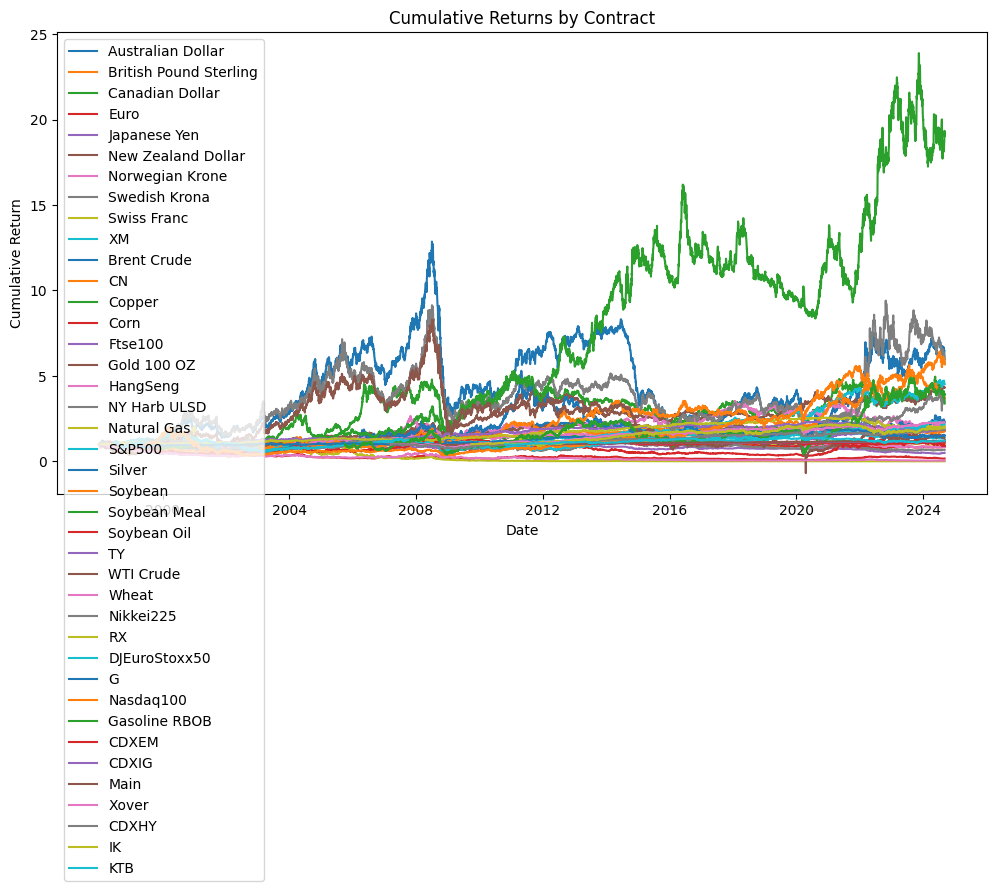

In [42]:

# Plot cumulative returns for each contract
plt.figure(figsize=(12, 6))
for contract in df['Contract'].unique():
    contract_data = df[df['Contract'] == contract]
    plt.plot(contract_data['Date'], contract_data['Cum_Return']/contract_data['Cum_Return'].iloc[0], label=contract)
plt.legend()
plt.title('Cumulative Returns by Contract')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()




In [43]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250776 entries, 0 to 250775
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              250776 non-null  datetime64[ns]
 1   Asset Class       250776 non-null  object        
 2   Contract          250776 non-null  object        
 3   Transaction_Cost  250776 non-null  float64       
 4   Return            250736 non-null  float64       
 5   Cum_Return        250776 non-null  float64       
 6   Rolling_Mean      249496 non-null  float64       
 7   Rolling_Std       249496 non-null  float64       
 8   Annual_Vol        240696 non-null  float64       
 9   Drawdown          250776 non-null  float64       
 10  VIX               250063 non-null  float64       
 11  VIX_Quintale      210293 non-null  float64       
 12  VIX_ch_5d         249939 non-null  float64       
 13  VIX_ch_20d        249518 non-null  float64       
 14  MOVE

 ## **Feature engineering**: momentum signals

In [45]:
def calculate_variance_spread(price, window):
    log_returns = np.log(price / price.shift(1))
    cumulative_squared_returns = log_returns.rolling(window=window).apply(lambda x: np.sum(x**2))
    log_price_ratio_squared = np.log(price/ price.shift(window))**2
    variance_spread = log_price_ratio_squared - cumulative_squared_returns
    return variance_spread
    
def calculate_signal(df, lookback_periods, type_signal):
    results = {}
    
    for period in lookback_periods:
        short_period = period
        if type_signal=='EMA':
            long_period = period * 4        
            ema_short = df.groupby('Contract')['Cum_Return'].transform(lambda x: x.ewm(span=short_period, min_periods=short_period).mean())
            ema_long = df.groupby('Contract')['Cum_Return'].transform(lambda x: x.ewm(span=long_period, min_periods=long_period).mean())
            signals = np.where(ema_short - ema_long > 0, 1, -1)
            results[f'Signal_{short_period}_{long_period}_{type_signal}'] = signals
        elif type_signal=='Return':     
            #returns_lookback =  df.groupby('Contract')['Cum_Return'].transform(lambda x: x.rolling(short_period, min_periods=1).sum())
            returns_lookback = df.groupby('Contract')['Cum_Return'].transform(lambda x: x.pct_change(periods=short_period))
            signals = np.where(returns_lookback > 0, 1, -1)
            results[f'Signal_{short_period}_{type_signal}'] = signals
        elif type_signal == 'VarSpr':
            variance_spread = df.groupby('Contract')['Cum_Return'].apply(lambda x: calculate_variance_spread(x, short_period)).reset_index(level=0, drop=True)
            signals = np.where(variance_spread > 0, 1, -1)
            results[f'Signal_{short_period}_{type_signal}'] = signals

    for key, value in results.items():
        df[key] = value
    
    return df

type_signal='Return'   #either Return/EMA/FastMinRev
lookback_periods = [20, 60, 120, 260]
df = calculate_signal(df, lookback_periods, type_signal)
type_signal='EMA'
lookback_periods = [4, 8, 16, 32, 64]
df = calculate_signal(df, lookback_periods, type_signal)

#type_signal='VarSpr'
#lookback_periods = [20, 60, 120, 260]
#df = calculate_signal(df, lookback_periods, type_signal)
# Display the first few rows of the updated DataFrame
print(df.head())

# If you want to see the results for a specific contract
#contract_of_interest = 'IK'  # Replace with an actual contract name
#print(df[df['Contract'] == contract_of_interest].tail())

        Date Asset Class                Contract  Transaction_Cost  Return  \
0 1998-01-01          FX       Australian Dollar            0.0001     NaN   
1 1998-01-01          FX  British Pound Sterling            0.0001     NaN   
2 1998-01-01          FX         Canadian Dollar            0.0001     NaN   
3 1998-01-01          FX                    Euro            0.0001     NaN   
4 1998-01-01          FX            Japanese Yen            0.0001     NaN   

   Cum_Return  Rolling_Mean  Rolling_Std  Annual_Vol  Drawdown  ...  \
0    107.2092           NaN          NaN         NaN       0.0  ...   
1     97.3619           NaN          NaN         NaN       0.0  ...   
2    107.9155           NaN          NaN         NaN       0.0  ...   
3     94.2809           NaN          NaN         NaN       0.0  ...   
4     91.1908           NaN          NaN         NaN       0.0  ...   

   MOVE_ch_20d  Signal_20_Return  Signal_60_Return  Signal_120_Return  \
0          NaN                -

Signal_4_16_EMA      0.029381
Signal_32_128_EMA    0.189560
Signal_60_Return     0.102163
Signal_260_Return    0.202983
dtype: float64

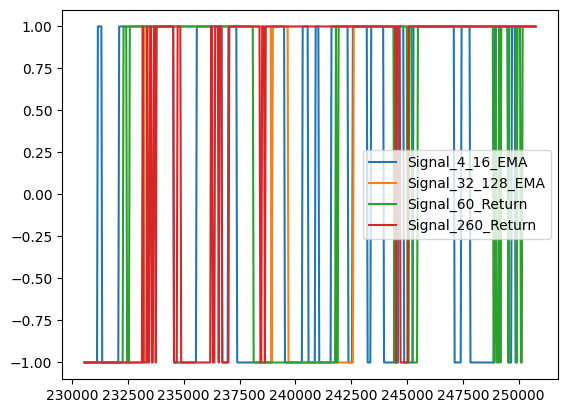

In [46]:
df_=df[df['Contract'] == 'Gold 100 OZ']
df_[['Signal_4_16_EMA','Signal_32_128_EMA','Signal_60_Return','Signal_260_Return']].tail(500).plot()
df_[['Signal_4_16_EMA','Signal_32_128_EMA','Signal_60_Return','Signal_260_Return']].mean()
#df_

In [47]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250776 entries, 0 to 250775
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               250776 non-null  datetime64[ns]
 1   Asset Class        250776 non-null  object        
 2   Contract           250776 non-null  object        
 3   Transaction_Cost   250776 non-null  float64       
 4   Return             250736 non-null  float64       
 5   Cum_Return         250776 non-null  float64       
 6   Rolling_Mean       249496 non-null  float64       
 7   Rolling_Std        249496 non-null  float64       
 8   Annual_Vol         240696 non-null  float64       
 9   Drawdown           250776 non-null  float64       
 10  VIX                250063 non-null  float64       
 11  VIX_Quintale       210293 non-null  float64       
 12  VIX_ch_5d          249939 non-null  float64       
 13  VIX_ch_20d         249518 non-null  float64 

## part 3 Create a simple momentum strategy. 
Like in a plain vanilla CTA using previosuly calculated signals equal weighted. This strategy will be then used to benchmark the performace of the ML/AI which will have the possibility to come up with somwething potentially more clever than simple average

A baseline trend-following CTA (Commodity Trading Advisor) strategy that will be used as a benchmark. In this basic strategy, it's simply taking all the previously generated signals (both from EMA crossovers and return-based signals with different lookback periods) and combining them with equal weights - essentially just averaging them together to produce a final trading signal. This straightforward approach will serve as a comparison point for a more sophisticated machine learning/AI model, which could potentially discover more complex or effective ways of combining these signals beyond just taking their average.
The key contrast being set up is between the "plain vanilla" equal-weighted signal combination versus what an AI might discover - for example, the AI could potentially learn to give different weights to different signals, identify which signals work better in different market conditions, or find non-linear relationships between signals that the simple averaging approach misses.

### we target a volatility of 5% for each contract

For each futures/CDS contract, we scale the position size to target a consistent 5% annual volatility. This is possible due to the leveraged nature of these instruments, which allows us to precisely adjust our exposure (assuming sufficient capital to handle minimum contract sizes).


In [49]:
# Create Signal_avg
s_columns = [col for col in df.columns if col.startswith('Signal_')]
df['Signal_avg'] = df[s_columns].mean(axis=1)

# Function to calculate returns for a signal
def calculate_signal_returns(group,include_tc=False):
    # Sort by date
    group = group.sort_values('Date')
    # Get signal changes for transaction cost calculation
    signal_changes = np.abs(group['Signal_avg'].shift(1) - group['Signal_avg'].shift(2))
    if include_tc:
        # Apply signal and subtract transaction costs when signal changes
        group['Act_Return'] = (group['Return'] * group['Signal_avg'].shift(1) - (signal_changes * group['Transaction_Cost'])/2)
    else:
        group['Act_Return'] = group['Return'] * group['Signal_avg'].shift(1)
    # Handle the first NaN due to shift by assigning the first 0 value to 'Act_Return'
    group.loc[group.index[0], 'Act_Return'] = 0
    # Calculate cumulative signal returns
    group['Act_Cum_Return'] = (1 + group['Act_Return']).cumprod() - 1
    
    return group

df = df.groupby('Contract').apply(calculate_signal_returns, include_tc=True).reset_index(drop=True)


C:\Users\claud\AppData\Local\Temp\ipykernel_64628\3644645602.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Contract').apply(calculate_signal_returns, include_tc=True).reset_index(drop=True)


## volatility targeting

In [51]:
s_columns = [col for col in df.columns if col.startswith('Signal_')]
df['Signal_avg'] = df[s_columns].mean(axis=1)

def calculate_signal_returns(group, target_vol=0.05, include_tc=False):

    group = group.sort_values('Date')    
    # Calculate volatility multiplier with adjustment for lag effect
    adjusted_target = target_vol * np.sqrt(2) * .9 # Adjustment factor =np.sqrt(2) * .9  Multiply target_vol by sqrt(2) to compensate for lag effect
    group['Vol_Multiplier'] = np.clip(adjusted_target / group['Rolling_Std'], -5, 5)
    
    # Get signal changes for transaction cost calculation
    signal_changes = np.abs(group['Signal_avg'].shift(1) - group['Signal_avg'].shift(2))
    if include_tc:
        # Apply signal and subtract transaction costs when signal changes
        group['Act_Return'] = (group['Return'] * group['Signal_avg'].shift(1) - (signal_changes * group['Transaction_Cost'])/2) * group['Vol_Multiplier'].shift(1)
    else:
        group['Act_Return'] = group['Return'] * group['Signal_avg'].shift(1) * group['Vol_Multiplier'].shift(1)
    
    # Handle the first NaN values due to shift
    group.loc[group.index[0], 'Act_Return'] = 0
    
    group['Act_Cum_Return'] = (1 + group['Act_Return']).cumprod() - 1
    
    return group

# Apply to dataframe
df = df.groupby('Contract').apply(lambda x: calculate_signal_returns(x, target_vol=0.05, include_tc=True)).reset_index(drop=True)


C:\Users\claud\AppData\Local\Temp\ipykernel_64628\4252903772.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Contract').apply(lambda x: calculate_signal_returns(x, target_vol=0.05, include_tc=True)).reset_index(drop=True)



Rolling Realized Volatilities:

Rolling Realized Volatilities:

Bond:
------------------------------
IK: 0.0522
KTB: 0.0518
RX: 0.0505
TY: 0.0499
G: 0.0491
CN: 0.0486
XM: 0.0474
EW Portfolio - Bond: 0.0424

Comdty:
------------------------------
WTI Crude: 0.0523
Natural Gas: 0.0513
Brent Crude: 0.0510
Gold 100 OZ: 0.0507
Silver: 0.0503
Soybean Oil: 0.0498
Copper: 0.0495
Corn: 0.0494
NY Harb ULSD: 0.0493
Gasoline RBOB: 0.0489
Soybean: 0.0487
Soybean Meal: 0.0487
Wheat: 0.0486
EW Portfolio - Comdty: 0.0341

Credit:
------------------------------
CDXEM: 0.0514
Xover: 0.0505
CDXHY: 0.0486
EW Portfolio - Credit: 0.0481
Main: 0.0452
CDXIG: 0.0443

Equity:
------------------------------
S&P500: 0.0526
Nasdaq100: 0.0514
Nikkei225: 0.0510
Ftse100: 0.0500
HangSeng: 0.0497
DJEuroStoxx50: 0.0493
EW Portfolio - Equity: 0.0436

FX:
------------------------------
Swiss Franc: 0.0532
Japanese Yen: 0.0508
Australian Dollar: 0.0504
New Zealand Dollar: 0.0495
Swedish Krona: 0.0494
Euro: 0.0490
British 

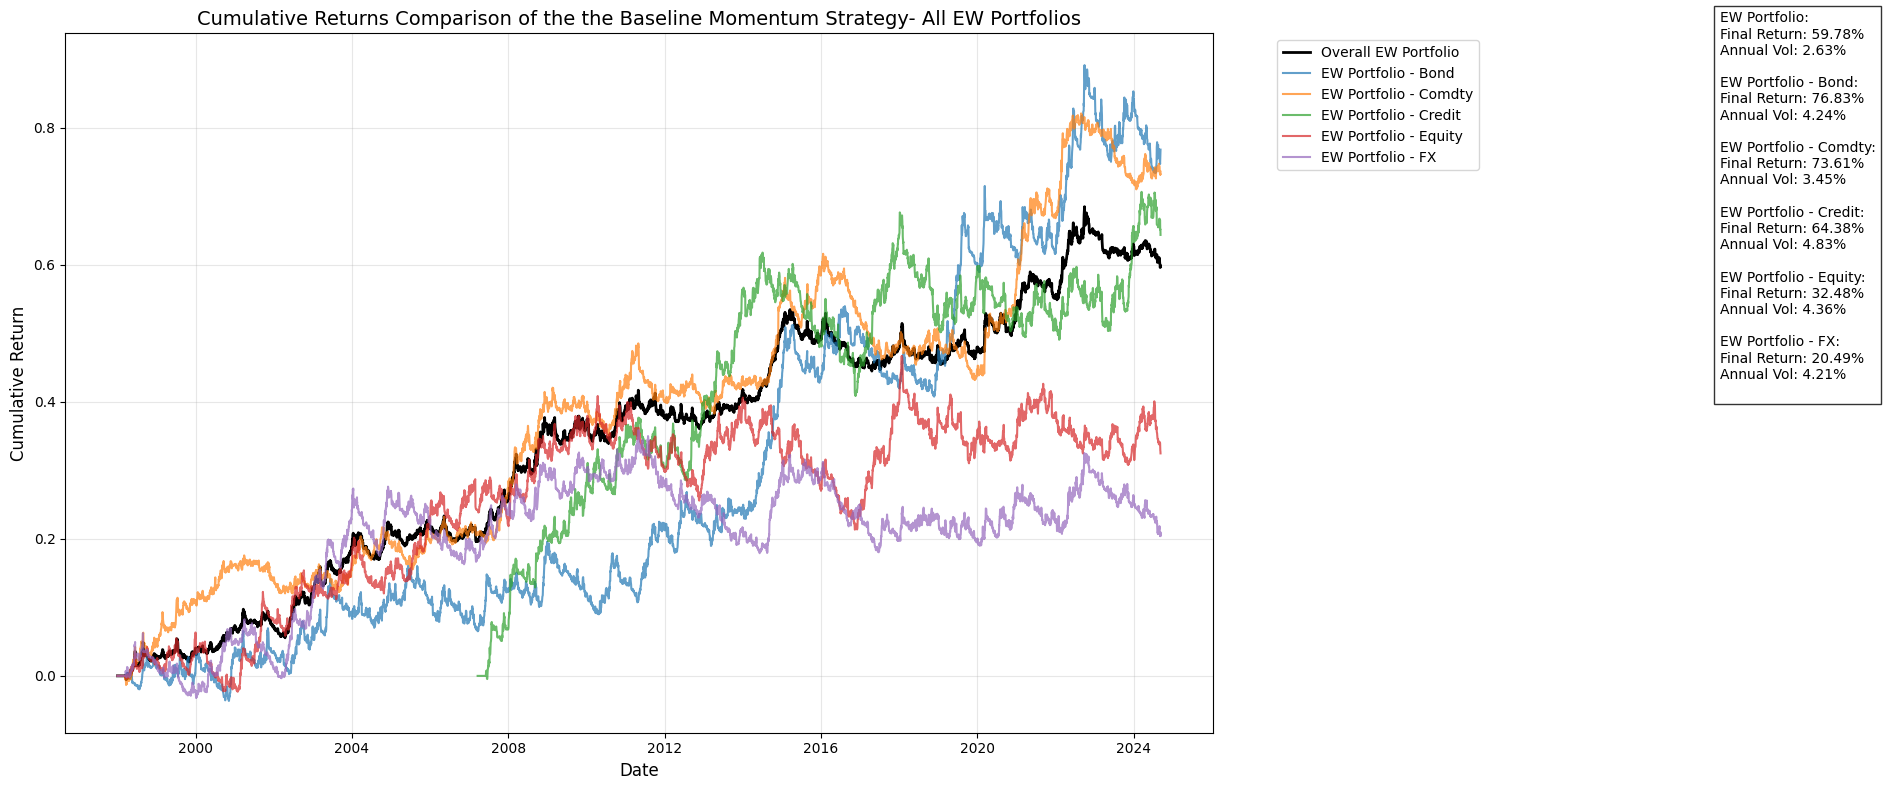

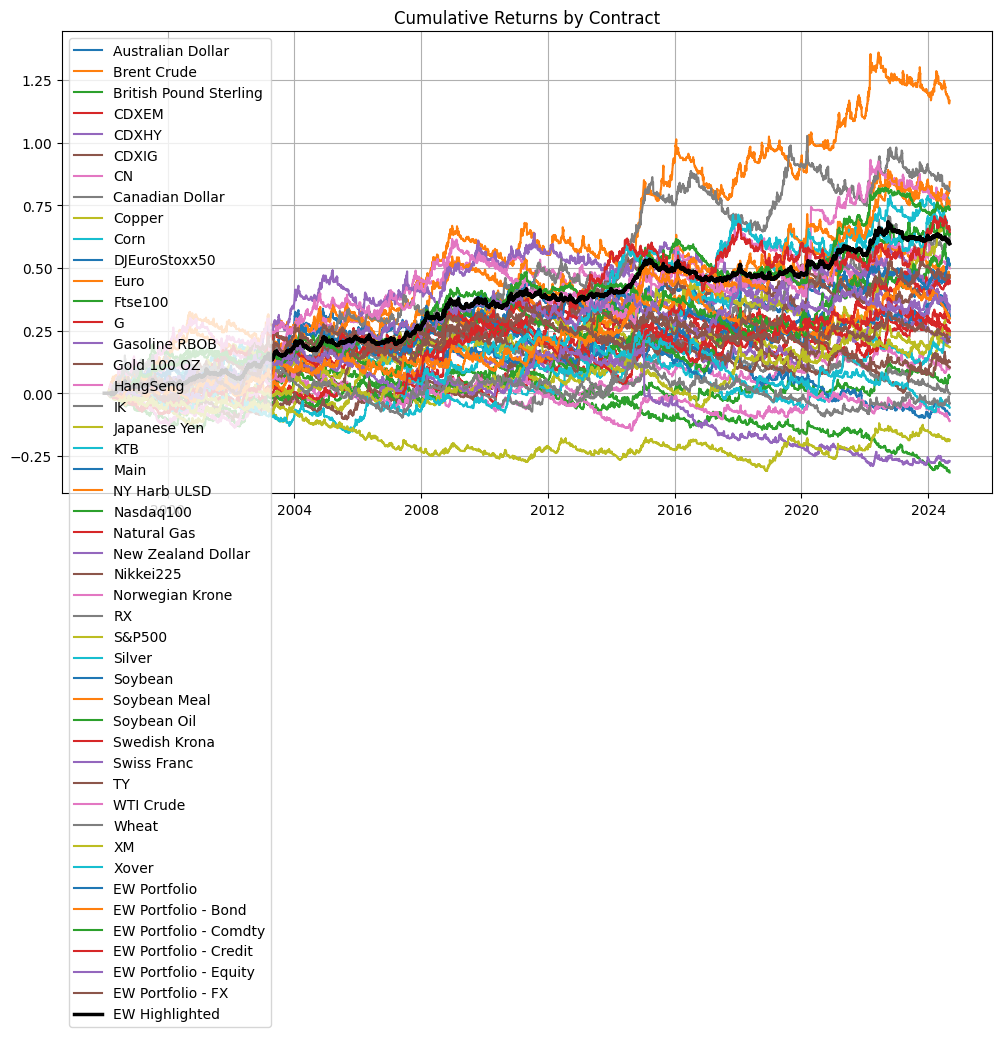

In [52]:
def create_portfolios(df, target_vol=0.05, vol_window=32, by_asset_class=True):
    """
    Create equal-weighted portfolios with volatility targeting.
    Can create both overall portfolio and asset class specific portfolios.
    
    Args:
        df (pd.DataFrame): Input DataFrame with required columns
        target_vol (float): Target volatility for scaling
        vol_window (int): Rolling window for volatility calculation
        by_asset_class (bool): If True, create separate portfolios for each asset class
        
    Returns:
        pd.DataFrame: Combined portfolio data
    """
    all_portfolios = []
    
    # Create overall portfolio first
    overall_port_df = (df.groupby('Date').agg({
        'Act_Return': 'mean',
        'Return': 'mean',
        'Signal_avg': 'mean',
        'Vol_Multiplier': 'mean',
        'Rolling_Std': 'mean',
        'Contract': 'size'  # This gives us N_Contracts
    }).reset_index())
    
    # Rename and add required columns for overall portfolio
    overall_port_df = overall_port_df.rename(columns={
        'Contract': 'N_Contracts',
        'Act_Return': 'Base_Return'
    })
    
    # Add portfolio identifiers for overall portfolio
    overall_port_df['Contract'] = 'EW Portfolio'
    overall_port_df['Asset Class'] = 'Overall'
    
    # Calculate volatility metrics for overall portfolio
    overall_port_df['Rolling_Vol'] = (overall_port_df['Base_Return']
                                   .rolling(window=vol_window)
                                   .std() * np.sqrt(252))
    
    # Calculate and apply volatility scaling
    overall_port_df['Vol_Scalar'] = np.clip(
        target_vol / overall_port_df['Rolling_Vol'].shift(1),
        -1.5, 1.5
    )
    overall_port_df['Act_Return'] = overall_port_df['Base_Return'] * overall_port_df['Vol_Scalar']
    overall_port_df.loc[overall_port_df['Vol_Scalar'].isna(), 'Act_Return'] = 0
    
    # Calculate cumulative returns
    overall_port_df['Act_Cum_Return'] = (1 + overall_port_df['Act_Return']).cumprod() - 1
    
    all_portfolios.append(overall_port_df)
    
    # Create asset class portfolios 
    if by_asset_class:
        # Process each asset class
        for asset_class, asset_data in df.groupby('Asset Class'):
            # Calculate daily portfolio metrics 
            port_df = (asset_data.groupby('Date').agg({
                'Act_Return': 'mean',
                'Return': 'mean',
                'Signal_avg': 'mean',
                'Vol_Multiplier': 'mean',
                'Rolling_Std': 'mean',
                'Contract': 'size'  # This gives us N_Contracts
            }).reset_index())

            port_df = port_df.rename(columns={
                'Contract': 'N_Contracts',
                'Act_Return': 'Base_Return'
            })
            
            # Add portfolio identifiers
            port_df['Contract'] = f'EW Portfolio - {asset_class}'
            port_df['Asset Class'] = asset_class
 
            port_df['Rolling_Vol'] = (port_df['Base_Return']
                                     .rolling(window=vol_window)
                                     .std() * np.sqrt(252))
            
            # Calculate and apply volatility scaling (notice cap /floor)
            port_df['Vol_Scalar'] = np.clip(
                target_vol / port_df['Rolling_Vol'].shift(1),
                -1.5, 1.5
            )
            port_df['Act_Return'] = port_df['Base_Return'] * port_df['Vol_Scalar']
            port_df.loc[port_df['Vol_Scalar'].isna(), 'Act_Return'] = 0
            
            # Calculate cumulative returns
            port_df['Act_Cum_Return'] = (1 + port_df['Act_Return']).cumprod() - 1
            
            all_portfolios.append(port_df)
    
    # Combine all portfolios
    portfolios_df = pd.concat(all_portfolios, ignore_index=True)
    return portfolios_df

#  usage:
# Create both overall and asset class portfolios
all_portfolios = create_portfolios(df, target_vol=0.05, vol_window=20, by_asset_class=True)

# Combine with original data
df_w_PTF = pd.concat([df, all_portfolios], ignore_index=True)


# Verify realized volatilities check if in line with target_vol
def check_volatilities(df, window=252):
    vol_results = []
    print("\nRolling Realized Volatilities:")
    for contract in df['Contract'].unique():
        contract_data = df[df['Contract'] == contract]
        rolling_vol = (contract_data['Act_Return']
                      .rolling(window=window)
                      .std() * np.sqrt(252))
        
        vol_results.append({
            'Asset Class': contract_data['Asset Class'].iloc[0],
            'Contract': contract,
            'Volatility': rolling_vol.mean()
        })
    vol_df = pd.DataFrame(vol_results)
    vol_df = vol_df.sort_values(['Asset Class', 'Volatility'], ascending=[True, False])
    print("\nRolling Realized Volatilities:")
    print("=" * 50)
    
    for asset_class in vol_df['Asset Class'].unique():
        print(f"\n{asset_class}:")
        print("-" * 30)
        asset_class_data = vol_df[vol_df['Asset Class'] == asset_class]
        for _, row in asset_class_data.iterrows():
            print(f"{row['Contract']}: {row['Volatility']:.4f}")
            
    return vol_df

check_volatilities(df_w_PTF)

def check_volatilities_simple(df, window=252):
    print("\nRolling Realized Volatilities:")
    for contract in df['Contract'].unique():
        contract_data = df[df['Contract'] == contract]
        rolling_vol = (contract_data['Act_Return']
                      .rolling(window=window)
                      .std() * np.sqrt(252))
        avg_vol = rolling_vol.mean()
        print(f"{contract}: {avg_vol:.4f}")
check_volatilities_simple(df_w_PTF)


# Verify the portfolio's cumulative returns
portfolio_view = df_w_PTF[df_w_PTF['Contract'] == 'EW Portfolio']


import matplotlib.pyplot as plt

def plot_all_portfolios(df_w_PTF):
    # Filter for only portfolio returns (excluding individual contracts)
    portfolio_data = df_w_PTF[df_w_PTF['Contract'].str.contains('EW Portfolio')].copy()
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    
    # Plot overall EW Portfolio
    overall_ptf = portfolio_data[portfolio_data['Contract'] == 'EW Portfolio']
    plt.plot(overall_ptf['Date'], 
             overall_ptf['Act_Cum_Return'],
             label='Overall EW Portfolio',
             linewidth=2,
             color='black')
    
    # Plot each asset class portfolio with different colors
    asset_class_ptfs = portfolio_data[portfolio_data['Contract'] != 'EW Portfolio']
    for asset_class in asset_class_ptfs['Asset Class'].unique():
        mask = asset_class_ptfs['Asset Class'] == asset_class
        plt.plot(asset_class_ptfs[mask]['Date'],
                asset_class_ptfs[mask]['Act_Cum_Return'],
                label=f'EW Portfolio - {asset_class}',
                alpha=0.7)
    
    plt.title('Cumulative Returns Comparison of the the Baseline Momentum Strategy- All EW Portfolios', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Return', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Add some statistics in text
    stats_text = []
    for portfolio in portfolio_data['Contract'].unique():
        ptf_data = portfolio_data[portfolio_data['Contract'] == portfolio]
        final_return = ptf_data['Act_Cum_Return'].iloc[-1]
        annual_vol = ptf_data['Act_Return'].std() * np.sqrt(252)
        stats_text.append(f"{portfolio}:")
        stats_text.append(f"Final Return: {final_return:.2%}")
        stats_text.append(f"Annual Vol: {annual_vol:.2%}\n")
    
    plt.figtext(1.15, 0.5, '\n'.join(stats_text), 
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.show()

# Call the function
plot_all_portfolios(df_w_PTF)


# compare with individual contracts
plt.figure(figsize=(12, 6))
for contract in df_w_PTF['Contract'].unique():
    contract_data = df_w_PTF[df_w_PTF['Contract'] == contract]
    plt.plot(contract_data['Date'], contract_data['Act_Cum_Return'], 
             label=contract)
# Highlighting a specific contract (e.g., 'IK')
plt.plot(df_w_PTF[df_w_PTF['Contract'] == 'EW Portfolio']['Date'], 
             df_w_PTF[df_w_PTF['Contract'] == 'EW Portfolio']['Act_Cum_Return'], 
             color='black', linewidth=2.5, label='EW Highlighted')    
plt.title('Cumulative Returns by Contract')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
portfolio_data = df_w_PTF[df_w_PTF['Contract'].str.contains('EW Portfolio')].copy()

# remove to add again VIX/MOVE STUFF
portfolio_data = portfolio_data.drop(['VIX', 'VIX_Quintale', 'VIX_ch_5d', 'VIX_ch_20d', 
                                    'MOVE', 'MOVE_Quintale', 'MOVE_ch_5d', 'MOVE_ch_20d'], 
                                   axis=1)

temp_df = vix_df_quint[['VIX', 'VIX_Quintale','VIX_ch_5d','VIX_ch_20d']].reset_index()
df_merged = pd.merge(portfolio_data, temp_df, on='Date', how='left')
temp_df = move_df_quint[['MOVE', 'MOVE_Quintale','MOVE_ch_5d','MOVE_ch_20d']].reset_index()
df_merged = pd.merge(df_merged, temp_df, on='Date', how='left')

portfolio_data=df_merged
portfolio_data.tail()



Date Asset Class           Contract  Transaction_Cost    Return  \
39209 2024-09-02          FX  EW Portfolio - FX               NaN  0.000138   
39210 2024-09-03          FX  EW Portfolio - FX               NaN -0.003555   
39211 2024-09-04          FX  EW Portfolio - FX               NaN  0.004138   
39212 2024-09-05          FX  EW Portfolio - FX               NaN  0.001998   
39213 2024-09-06          FX  EW Portfolio - FX               NaN -0.003618   

       Cum_Return  Rolling_Mean  Rolling_Std  Annual_Vol  Drawdown  ...  \
39209         NaN           NaN     0.084846         NaN       NaN  ...   
39210         NaN           NaN     0.085782         NaN       NaN  ...   
39211         NaN           NaN     0.085722         NaN       NaN  ...   
39212         NaN           NaN     0.084726         NaN       NaN  ...   
39213         NaN           NaN     0.086033         NaN       NaN  ...   

       Rolling_Vol  Vol_Scalar    VIX  VIX_Quintale  VIX_ch_5d  VIX_ch_20d  \
39209     0.028113         1.5  15.55           2.0      -0.60      -23.02   
39210     0.028587         1.5  20.72           2.0       5.29       -6.99   
39211     0.027863         1.5  21.32           3.0       4.21       -6.53   
39212     0.027232         1.5  19.90           3.0       4.25       -3.89   
39213     0.028927         1.5  22.38           3.0       7.38        2.01   

         MOVE  MOVE_Quintale  MOVE_ch_5d  MOVE_ch_20d  
39209  107.77            4.0        1.11       -13.45  
39210  114.20            4.0        4.98        -5.04  
39211  119.15            4.0       10.39         6.46  
39212  114.81            4.0        8.11         4.39  
39213  107.24            4.0       -0.53        -1.02  

[5 rows x 35 columns]

In [56]:
def calculate_performance_metrics(group):
    """
    Calculate performance metrics for a group including Asset Class
    """
    # Convert date column to datetime if not already
    group['Date'] = pd.to_datetime(group['Date'])

    # Get Asset Class
    asset_class = group['Asset Class'].iloc[0]
    
    # Basic Returns
    total_return = group['Act_Cum_Return'].iloc[-1]
    
    # Time period calculations
    days = (group['Date'].iloc[-1] - group['Date'].iloc[0]).days
    years = days / 365  # Using 365 for actual years
    trading_days = len(group)
    
    # Returns
    annualized_return = (1 + total_return) ** (252 / trading_days) - 1
    
    # Risk Metrics
    returns = group['Act_Return']
    volatility = returns.std() * np.sqrt(252)
    
    # Sharpe and Sortino Ratios
    excess_returns = returns
    sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std() if returns.std() != 0 else 0
    downside_returns = returns[returns < 0]
    sortino_ratio = np.sqrt(252) * returns.mean() / downside_returns.std() if len(downside_returns) > 0 else 0
    
    # Drawdown Analysis
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.expanding().max()
    drawdowns = (cum_returns - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()
    
    # Win Rate and Signal Analysis
    win_rate = (returns > 0).mean()
    avg_win = returns[returns > 0].mean() if len(returns[returns > 0]) > 0 else 0
    avg_loss = returns[returns < 0].mean() if len(returns[returns < 0]) > 0 else 0
    profit_factor = abs(returns[returns > 0].sum() / returns[returns < 0].sum()) if len(returns[returns < 0]) > 0 else np.inf
    
    # Signal Statistics
    avg_signal = group['Signal_avg'].mean()
    signal_std = group['Signal_avg'].std()
    
    return pd.Series({
        'Asset Class': asset_class,  # Added Asset Class here
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Trading Days': trading_days,
        'Years': years,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown,
        'Win Rate': win_rate,
        'Average Win': avg_win,
        'Average Loss': avg_loss,
        'Profit Factor': profit_factor,
        'Average Signal': avg_signal,
        'Signal Std': signal_std,
        'Annual Return/Max DD': abs(annualized_return/max_drawdown) if max_drawdown != 0 else np.inf
    })

def format_metrics(performance_metrics):
    """
    Format the metrics output
    """
    formatted = performance_metrics.round(4)
    
    # Convert ratios to percentages
    pct_columns = ['Total Return', 'Annualized Return', 'Volatility', 
                   'Max Drawdown', 'Win Rate']
    formatted[pct_columns] = formatted[pct_columns] * 100

    df_sorted = formatted.reset_index()
    
    # Create custom sort order with NaN at the end
    unique_classes = df_sorted['Asset Class'].dropna().unique()
    df_sorted['Asset_Class_Order'] = df_sorted['Asset Class'].map(
        {asset: idx for idx, asset in enumerate(unique_classes)}
    )
    # Put NaN values at the end
    df_sorted.loc[df_sorted['Asset Class'].isna(), 'Asset_Class_Order'] = len(unique_classes)
    
    # Sort by Asset Class Order and Contract
    df_sorted = df_sorted.sort_values(['Asset_Class_Order', 'Contract'])
    
    # Drop the ordering column
    df_sorted = df_sorted.drop('Asset_Class_Order', axis=1)
    
    # Set multi-index
    df_sorted = df_sorted.set_index(['Asset Class', 'Contract'])

   
    return df_sorted

#  usage:

# Calculate metrics for each contract
performance_metrics = df_w_PTF.groupby('Contract', group_keys=False).apply(calculate_performance_metrics)

# Format and display results
formatted_metrics = format_metrics(performance_metrics)
formatted_metrics.tail(100)



C:\Users\claud\AppData\Local\Temp\ipykernel_64628\1294004599.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  performance_metrics = df_w_PTF.groupby('Contract', group_keys=False).apply(calculate_performance_metrics)


Total Return  Annualized Return  \
Asset Class Contract                                                  
FX          Australian Dollar              30.14               0.96   
            British Pound Sterling          6.35               0.22   
            Canadian Dollar                -0.42              -0.02   
            EW Portfolio - FX              20.49               0.68   
            Euro                           46.71               1.40   
            Japanese Yen                   65.67               1.84   
            New Zealand Dollar             34.48               1.08   
            Norwegian Krone               -11.12              -0.43   
            Swedish Krona                  24.77               0.80   
            Swiss Franc                   -27.09              -1.14   
Comdty      Brent Crude                   116.79               2.89   
            Copper                         18.29               0.63   
            Corn                           22.25               0.76   
            EW Portfolio - Comdty          73.61               2.04   
            Gasoline RBOB                  24.59               1.17   
            Gold 100 OZ                    12.49               0.44   
            NY Harb ULSD                   84.29               2.32   
            Natural Gas                    43.83               1.38   
            Silver                         -5.73              -0.22   
            Soybean                        51.64               1.57   
            Soybean Meal                   29.72               0.98   
            Soybean Oil                    63.92               1.87   
            WTI Crude                      74.29               2.11   
            Wheat                          -4.09              -0.16   
Credit      CDXEM                          28.01               1.44   
            CDXHY                          43.91               2.12   
            CDXIG                          45.91               2.20   
            EW Portfolio - Credit          64.38               2.82   
            Main                           33.46               1.66   
            Xover                          65.24               2.91   
Bond        CN                             10.39               0.37   
            EW Portfolio - Bond            76.83               2.08   
            G                              24.20               0.83   
            IK                             62.28               3.25   
            KTB                            76.49               4.39   
            RX                             80.97               2.23   
            TY                             47.22               1.46   
            XM                            -18.62              -0.74   
Equity      DJEuroStoxx50                  -8.64              -0.34   
            EW Portfolio - Equity          32.48               1.03   
            Ftse100                       -31.66              -1.39   
            HangSeng                       49.80               1.55   
            Nasdaq100                      50.98               1.64   
            Nikkei225                      10.11               0.37   
            S&P500                         23.37               0.78   
Overall     EW Portfolio                   59.78               1.71   

                                    Trading Days    Years  Volatility  \
Asset Class Contract                                                    
FX          Australian Dollar               6962  26.6986        5.10   
            British Pound Sterling          6962  26.6986        4.89   
            Canadian Dollar                 6962  26.6986        4.85   
            EW Portfolio - FX               6962  26.6986        4.21   
            Euro                            6962  26.6986        4.92   
            Japanese Yen                    6962  26.6986        5.17   
            New Zealand Dollar             

The table above shows results of applying a simple momentum strategy (using the signals we discussed earlier - EMA and returns-based) across multiple contracts, targeting 5% volatility for each instrument. The data spans roughly 27 years (1997-2024) and is organized by asset classes: FX, Commodities, Credit, Bonds, and Equities.

Each asset class has its own equal-weighted (EW) portfolio, showing how diversification within asset classes improves metrics - notably through reduced volatility and drawdowns. For example, while individual FX contracts show volatilities around 5%, the EW FX portfolio achieves 4.21% with better risk-adjusted metrics.

The overall EW Portfolio (bottom row) demonstrates the power of cross-asset diversification - achieving a strong Sharpe ratio of 0.66 with significantly lower volatility (2.63%) and maximum drawdown (-5.85%) compared to individual contracts, while maintaining a consistent 1.71% annual return.

The Signal Std column around 0.7 for individual contracts confirms these are binary (-1/+1) signals, while portfolio aggregations show lower Signal Std due to the averaging effect.


### cross-asset diversification benefits shown in the results:

The overall Equal-Weighted Portfolio achieves a Sharpe ratio of 0.66 (Sortino 0.90), which is particularly impressive given it's calculated over a 27-year period that includes multiple crisis events. This outperforms most individual contracts and demonstrates key features of the strategy:

1. Diversification Effects:
- Individual contracts target 5% volatility, but the overall EW Portfolio achieves just 2.63% volatility
- Max drawdown of only -5.85% compared to -20% to -40% for individual contracts
- The reduced Signal Std (0.33 vs 0.70 for individual contracts) shows effective signal averaging

2. Asset Class Performance (by Sharpe):
- Credit (0.60): Best performing asset class, though shorter history (~17 years)
- Bonds (0.51): Strong and consistent across most instruments
- Commodities (0.60): High dispersion between winners (Brent 0.58) and losers (Wheat -0.01)
- Equities (0.26): Lower Sharpes but good diversification benefits
- FX (0.18): Lowest Sharpes but provided crucial diversification

3. Key Success Factors:
- Win rate of 53.29% for overall portfolio vs ~50% for individual contracts
- Profit factor of 1.12 indicating consistent positive skew
- Annual Return/Max DD ratio of 0.29 showing good risk-adjusted performance across market cycles

This suggests the strategy's success comes more from risk reduction through diversification than from individual contract prediction power - a classic characteristic of traditional CTA strategies that would serve as a good benchmark for more sophisticated ML approaches.

## Analyse performance by VOL Quintile
Mean returns by VIX quintile with standard deviation and count
Mean returns by MOVE quintile with standard deviation and count
A heatmap showing average returns for each VIX/MOVE quintile combination
Overall statistics including mean return, standard deviation, and total observations

In [70]:

def analyze_returns_by_quintiles(df, contract_name=None):
    """
    Analyze Act_Return across VIX and MOVE quintiles for a specific contract or all contracts.
    
    Parameters:
    df : pandas DataFrame
        The portfolio data
    contract_name : str, optional
        Specific contract to analyze. If None, analyzes all contracts
        
    Returns:
    tuple: (summary_stats, heatmap_data)
        summary_stats: Mean returns by VIX and MOVE quintiles
        heatmap_data: Pivot table for visualization
    """
    # Define a function to calculate SR (mean/vol)
    def calc_sr(x):
        return x.mean() / x.std() * np.sqrt(256) if x.std() != 0 else 0
    
    # Filter for specific contract if provided
    if contract_name:
        data = df[df['Contract'] == contract_name].copy()
    else:
        data = df.copy()
    
    # Create summary statistics
    # 1. Mean returns by VIX quintile
    vix_summary = data.groupby('VIX_Quintale')['Act_Return'].agg([
        'mean', 
        'std', 
        'count',
        ('SR', calc_sr)  # Add Sharpe Ratio calculation
    ]).round(4)
    
    # 2. Mean returns by MOVE quintile
     # 1. Mean returns by VIX quintile
    move_summary = data.groupby('MOVE_Quintale')['Act_Return'].agg([
        'mean', 
        'std', 
        'count',
        ('SR', calc_sr)  # Add Sharpe Ratio calculation
    ]).round(4)
    
    
    # 3. Create heatmap data - double sorted by VIX and MOVE quintiles
    heatmap = pd.pivot_table(
        data,
        values='Act_Return',
        index='VIX_Quintale',
        columns='MOVE_Quintale',
        aggfunc='mean'
    ).round(4)
    
    # Additional statistics
    summary_stats = {
        'vix_quintile_returns': vix_summary,
        'move_quintile_returns': move_summary,
        'overall_stats': {
            'mean_return': data['Act_Return'].mean(),
            'std_return': data['Act_Return'].std(),
            'total_observations': len(data)
        }
    }
    
    return summary_stats, heatmap

def print_analysis(summary_stats, heatmap, contract_name=None):
    """
    Print formatted analysis results
    """
    title = f"Analysis for {contract_name}" if contract_name else "Analysis for All Contracts"
    print(f"\n{title}")
    print("="* len(title))
    
    print("\nMean Returns by VIX Quintile:")
    print(summary_stats['vix_quintile_returns'])
    
    print("\nMean Returns by MOVE Quintile:")
    print(summary_stats['move_quintile_returns'])
    
    print("\nHeatmap of Returns (VIX × MOVE Quintiles):")
    print(heatmap)
    
    print("\nOverall Statistics:")
    for key, value in summary_stats['overall_stats'].items():
        print(f"{key}: {value:.4f}")

# Example usage for all unique contracts
def run_analysis(df):
    # First, analyze all contracts together
   # print("\nANALYSIS FOR ALL CONTRACTS COMBINED")
    #print("="*40)
    #all_stats, all_heatmap = analyze_returns_by_quintiles(df)
    #print_analysis(all_stats, all_heatmap)
    
    # Then analyze each contract separately
    unique_contracts = df['Contract'].unique()
    for contract in unique_contracts:
        stats, heatmap = analyze_returns_by_quintiles(df, contract)
        print_analysis(stats, heatmap, contract)

# Convert the code to handle NaN values and add error handling

analysis_df = portfolio_data.copy()

# Run the analysis
run_analysis(analysis_df)
        



Analysis for EW Portfolio

Mean Returns by VIX Quintile:
                mean     std  count      SR
VIX_Quintale                               
1.0           0.0001  0.0014   2032  0.9382
2.0           0.0000  0.0015    853  0.2180
3.0           0.0000  0.0016    674  0.2195
4.0           0.0000  0.0016    811  0.3931
5.0           0.0001  0.0022   1253  0.6689

Mean Returns by MOVE Quintile:
                 mean     std  count      SR
MOVE_Quintale                               
1.0            0.0001  0.0014   1822  1.1662
2.0            0.0000  0.0016    802  0.0150
3.0            0.0000  0.0017   1044  0.3366
4.0            0.0001  0.0016    905  0.5299
5.0            0.0001  0.0020   1050  0.5140

Heatmap of Returns (VIX × MOVE Quintiles):
MOVE_Quintale     1.0     2.0     3.0     4.0     5.0
VIX_Quintale                                         
1.0            0.0001  0.0000  0.0000  0.0000  0.0002
2.0            0.0001 -0.0000 -0.0001 -0.0000 -0.0002
3.0           -0.0001  0.00

In [72]:
'''
This code implements a trading strategy classification system that identifies buy/sell/hold signals based on future price movements across multiple time windows.
The core function calculate_percentile_based_alpha (in three variants: optimized, growing_window, and simple) calculates thresholds for classifying price movements using percentiles of historical returns.
classify_price_movement uses these thresholds to label each period as Buy/Sell/Hold based on whether future returns exceed the calculated thresholds.
multi_window_classification applies this classification across multiple time windows (1 to 5 periods) and uses majority voting to determine the final signal.
Finally, process_by_contract applies this entire classification process to each contract in the dataset independently, making it suitable for multi-asset portfolio analysis.

'''
from collections import Counter

def calculate_percentile_based_alpha_optimized(group, hold_window=3, lower_percentile=33.5, upper_percentile=66.5, min_periods=260):
    forward_pct_change = group['Cum_Return'].pct_change(periods=hold_window).shift(-hold_window)
    
    # Use expanding window with vectorized operations
    lower_threshold = forward_pct_change.expanding(min_periods=min_periods).quantile(lower_percentile / 100).abs()
    upper_threshold = forward_pct_change.expanding(min_periods=min_periods).quantile(upper_percentile / 100).abs()
    
    alpha1 = lower_threshold
    alpha2 = upper_threshold
    alpha = (alpha1 + alpha2) / 2
    
    return alpha, alpha1, alpha2, forward_pct_change
    
def calculate_percentile_based_alpha_growing_window(group, hold_window=3, lower_percentile=33.5, upper_percentile=66.5):
    forward_pct_change = group['Cum_Return'].pct_change(periods=hold_window).shift(-hold_window)
    
    lower_threshold = pd.Series(index=forward_pct_change.index, dtype=float)
    upper_threshold = pd.Series(index=forward_pct_change.index, dtype=float)
    
    for i in range(1, len(forward_pct_change)):
        growing_window = forward_pct_change.iloc[:i]
        lower_threshold.iloc[i] = np.abs(np.nanpercentile(growing_window, lower_percentile))
        upper_threshold.iloc[i] = np.abs(np.nanpercentile(growing_window, upper_percentile))
    
    alpha1 = lower_threshold
    alpha2 = upper_threshold
    alpha = (alpha1 + alpha2) / 2
    return alpha, alpha1, alpha2, forward_pct_change
  
def calculate_percentile_based_alpha_simple(group, hold_window=3, lower_percentile=33.5, upper_percentile=66.5):
    forward_pct_change = group['Cum_Return'].pct_change(periods=hold_window).shift(-hold_window)
    lower_threshold = np.abs(np.nanpercentile(forward_pct_change, lower_percentile))
    upper_threshold = np.abs(np.nanpercentile(forward_pct_change, upper_percentile))
    alpha1 = lower_threshold
    alpha2 = upper_threshold
    alpha = (alpha1 + alpha2) / 2
    return alpha, alpha1, alpha2,forward_pct_change

def classify_price_movement(group, hold_window=3, alpha=0.05):
    '''
    This function is performing a simple trading strategy classification:
    It classifies whether it WAS a buy, sell, or hold based on future returns.
    If the future return is within ±alpha (e.g., ±5%), it classifies as Hold.
    If the future return is above alpha, it classifies as Buy.
    If the future return is below -alpha, it classifies as Sell.
    '''
    group = group.copy()
    group['Cum_Return'] = pd.to_numeric(group['Cum_Return'], errors='coerce')
    group['forward_pct_change'] = group['Cum_Return'].pct_change(periods=hold_window).shift(-hold_window)
    group['classification'] = np.where(group['forward_pct_change'].abs() <= alpha, 'Hold',
                                       np.where(group['forward_pct_change'] > alpha, 'Buy', 'Sell'))
    return group

def multi_window_classification(group, windows=[1, 2, 3, 4, 5]):
    group_final = group.copy()
    group_final['Cum_Return'] = pd.to_numeric(group_final['Cum_Return'], errors='coerce')
    
    for window in windows:
        #alpha, _, _,forward_pct_change = calculate_percentile_based_alpha_growing_window(group_final, hold_window=window)
        alpha, _, _,forward_pct_change = calculate_percentile_based_alpha_optimized(group_final, hold_window=window)
        #alpha, _, _,forward_pct_change = calculate_percentile_based_alpha_simple(group_final, hold_window=window)
        group_classified = classify_price_movement(group_final, hold_window=window, alpha=alpha)
        group_final[f'classification_{window}'] = group_classified['classification']
        group_final[f'alpha{window}'] = alpha
        group_final[f'fW_pct_change_{window}'] = group_classified['forward_pct_change']
    
    def majority_vote(row):
        votes = [row[f'classification_{window}'] for window in windows]
        return Counter(votes).most_common(1)[0][0]
    
    group_final['final_classification'] = group_final.apply(majority_vote, axis=1)
    return group_final

def process_by_contract(df, windows=[1, 2, 3, 4, 5]):
    # Ensure 'Contract' and 'Date' columns exist
    if 'Contract' not in df.columns or 'Date' not in df.columns:
        raise ValueError("DataFrame must contain 'Contract' and 'Date' columns")
    
    grouped = df.groupby('Contract')
    df_classified = grouped.apply(lambda x: multi_window_classification(x, windows))
    
    # Reset index to flatten the result
    df_classified = df_classified.reset_index(drop=True)
    
    return df_classified

# Example usage:
windows = [1, 2, 3, 4, 5]
df = process_by_contract(df, windows)

C:\Users\claud\AppData\Local\Temp\ipykernel_64628\2758114058.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_classified = grouped.apply(lambda x: multi_window_classification(x, windows))


In [73]:
df.tail(10)
#df.to_excel('my_classified_data.xlsx', index=False)
df['Contract'].unique()

array(['Australian Dollar', 'Brent Crude', 'British Pound Sterling',
       'CDXEM', 'CDXHY', 'CDXIG', 'CN', 'Canadian Dollar', 'Copper',
       'Corn', 'DJEuroStoxx50', 'Euro', 'Ftse100', 'G', 'Gasoline RBOB',
       'Gold 100 OZ', 'HangSeng', 'IK', 'Japanese Yen', 'KTB', 'Main',
       'NY Harb ULSD', 'Nasdaq100', 'Natural Gas', 'New Zealand Dollar',
       'Nikkei225', 'Norwegian Krone', 'RX', 'S&P500', 'Silver',
       'Soybean', 'Soybean Meal', 'Soybean Oil', 'Swedish Krona',
       'Swiss Franc', 'TY', 'WTI Crude', 'Wheat', 'XM', 'Xover'],
      dtype=object)

In [76]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250776 entries, 0 to 250775
Data columns (total 47 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Date                  250776 non-null  datetime64[ns]
 1   Asset Class           250776 non-null  object        
 2   Contract              250776 non-null  object        
 3   Transaction_Cost      250776 non-null  float64       
 4   Return                250736 non-null  float64       
 5   Cum_Return            250776 non-null  float64       
 6   Rolling_Mean          249496 non-null  float64       
 7   Rolling_Std           249496 non-null  float64       
 8   Annual_Vol            240696 non-null  float64       
 9   Drawdown              250776 non-null  float64       
 10  VIX                   250063 non-null  float64       
 11  VIX_Quintale          210293 non-null  float64       
 12  VIX_ch_5d             249939 non-null  float64       
 13 

## ADDITIONAL FEATURES ENGINEERING
### use numerical features rather than signals

In [80]:
def calculate_variance_spread(price, window):
    log_returns = np.log(price / price.shift(1))
    cumulative_squared_returns = log_returns.rolling(window=window).apply(lambda x: np.sum(x**2))
    log_price_ratio_squared = np.log(price/ price.shift(window))**2
    variance_spread = log_price_ratio_squared - cumulative_squared_returns
    return variance_spread


def calculate_EMA_cross(price, window):
    '''
    self.data_tech['EMA_20'] = self.data['Close'].ewm(span=20, min_periods=20).mean()
    self.data_tech['EMA_50'] = self.data['Close'].ewm(span=50, min_periods=50).mean()
    self.data_tech['EMA_200'] = self.data['Close'].ewm(span=200, min_periods=200).mean()
    '''
    EMA=price.ewm(span=window, min_periods=window).mean()
    return price-EMA

def calculate_macd(price):
    exp1 = price.ewm(span=12, adjust=False).mean()
    exp2 = price.ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    macd_hist = macd - signal
    macd_signal = signal
    macd = macd
    return macd_hist

def calculate_stochastic_oscillator(price):
    low_14 = price.rolling(window=14).min()
    high_14 = price.rolling(window=14).max()
    K = 100 * ((price - low_14) / (high_14 - low_14))
    D = K.rolling(window=3).mean()
    stoch_signal=K-D
    return stoch_signal

def calculate_feature(df, lookback_periods, type_signal):
    results = {}

    if type_signal=='EMA':
      for period in lookback_periods:
        short_period = period
        ema_cross = df.groupby('Contract')['Cum_Return'].apply(lambda x: calculate_EMA_cross(x, short_period)).reset_index(level=0, drop=True)
        results[f'Feature_{short_period}_{type_signal}'] = ema_cross
    elif type_signal=='macd':       
        macd_hist = df.groupby('Contract')['Cum_Return'].apply(lambda x: calculate_macd(x)).reset_index(level=0, drop=True)
        results[f'Feature_{type_signal}'] = macd_hist
    elif type_signal=='stoch':       
        stoch_signal = df.groupby('Contract')['Cum_Return'].apply(lambda x: calculate_stochastic_oscillator(x)).reset_index(level=0, drop=True)
        results[f'Feature_{type_signal}'] = stoch_signal
    elif type_signal == 'VarSpr':
        for period in lookback_periods:
            short_period = period
            variance_spread = df.groupby('Contract')['Cum_Return'].apply(lambda x: calculate_variance_spread(x, short_period)).reset_index(level=0, drop=True)
            results[f'Feature_{short_period}_{type_signal}'] = variance_spread

    for key, value in results.items():
        df[key] = value
    
    return df

type_signal='EMA'   #either Return/EMA/FastMinRev
lookback_periods = [20, 50, 100, 200]
df = calculate_feature(df, lookback_periods, type_signal)
df = calculate_feature(df, lookback_periods, 'macd')
df = calculate_feature(df, lookback_periods, 'stoch')
lookback_periods = [20, 60, 120, 260]
df = calculate_feature(df, lookback_periods, 'VarSpr')
df.tail()

C:\Users\claud\anaconda3\envs\ImpCF\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\claud\anaconda3\envs\ImpCF\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\claud\anaconda3\envs\ImpCF\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\claud\anaconda3\envs\ImpCF\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Date Asset Class Contract  Transaction_Cost    Return  \
250771 2024-09-02      Credit    Xover            0.0002  0.000297   
250772 2024-09-03      Credit    Xover            0.0002 -0.003431   
250773 2024-09-04      Credit    Xover            0.0002 -0.000427   
250774 2024-09-05      Credit    Xover            0.0002 -0.000959   
250775 2024-09-06      Credit    Xover            0.0002 -0.001579   

        Cum_Return  Rolling_Mean  Rolling_Std  Annual_Vol  Drawdown  ...  \
250771    229.2157      0.000208     0.050464    0.048917 -0.001010  ...   
250772    228.4292      0.000121     0.051445    0.049049 -0.004438  ...   
250773    228.3317      0.000155     0.051250    0.048934 -0.004863  ...   
250774    228.1128      0.000045     0.050852    0.048944 -0.005817  ...   
250775    227.7525      0.000007     0.051045    0.048958 -0.007387  ...   

        Feature_20_EMA  Feature_50_EMA  Feature_100_EMA  Feature_200_EMA  \
250771        1.247208        2.214231         3.361833         6.444158   
250772        0.416831        1.371741         2.524336         5.601363   
250773        0.288918        1.224271         2.378780         5.449098   
250774        0.063350        0.965945         2.117110         5.178157   
250775       -0.268669        0.581894         1.722022         4.769918   

        Feature_macd  Feature_stoch  Feature_20_VarSpr  Feature_60_VarSpr  \
250771      0.225150      -1.257678           0.000419          -0.000580   
250772      0.122897     -15.840081           0.000365          -0.000608   
250773      0.040172     -28.126728           0.000330          -0.000537   
250774     -0.033816     -36.826437           0.000116          -0.000611   
250775     -0.107397     -13.424340           0.000062          -0.000527   

        Feature_120_VarSpr  Feature_260_VarSpr  
250771           -0.000974            0.006445  
250772           -0.001076            0.005081  
250773           -0.001103            0.005034  
250774           -0.001058            0.004744  
250775           -0.001026            0.003310  

[5 rows x 57 columns]

In [82]:
# Export in Xcel to check
#df_=df[df['Contract'] == 'TY']

#df_.to_excel('TY_df_check_data.xlsx')

#df.to_excel('All_Contract_df_check_data.xlsx')

## ML Algo part
#### Start with feature selection

In [78]:
# Define features once

feature_columns = [ 'Rolling_Mean', 'Rolling_Std', 
                  'Signal_20_Return', 'Signal_60_Return', 'Signal_120_Return', 'Signal_260_Return',
                  'Signal_4_16_EMA', 'Signal_8_32_EMA', 'Signal_16_64_EMA', 
                  'Signal_32_128_EMA', 'Signal_64_256_EMA']


# Create a custom mapping
custom_mapping = {'Sell': -1, 'Hold': 0, 'Buy': 1}
reverse_mapping = {-1: 'Sell', 0: 'Hold', 1: 'Buy'}

split_date = pd.to_datetime('2021-01-01')

# Split the main dataframe
df_train = df[df.Date < split_date]
df_test = df[df.Date >= split_date]

# Calculate train proportion
train_proportion = len(df_train) / len(df)

# Create X and y for both train and test using the defined columns
X_train = df_train[feature_columns]
X_test = df_test[feature_columns]

# Create y variables
y_train = df_train['final_classification']
y_test = df_test['final_classification']

# Encode y variables
y_train_encoded = np.array([custom_mapping[label] for label in y_train])
y_test_encoded = np.array([custom_mapping[label] for label in y_test])

# Print summary information
print(f"Split date: {split_date.strftime('%Y-%m-%d')}")
print(f"Training set: {X_train.shape[0]} samples ({train_proportion:.2%})")
print(f"Test set: {X_test.shape[0]} samples ({1-train_proportion:.2%})")
print(f"\nDate range for training: {df_train['Date'].min().strftime('%Y-%m-%d')} to {df_train['Date'].max().strftime('%Y-%m-%d')}")
print(f"Date range for testing: {df_test['Date'].min().strftime('%Y-%m-%d')} to {df_test['Date'].max().strftime('%Y-%m-%d')}")

Split date: 2021-01-01
Training set: 213310 samples (85.06%)
Test set: 37466 samples (14.94%)

Date range for training: 1998-01-01 to 2020-12-31
Date range for testing: 2021-01-01 to 2024-09-06


In [71]:
X_train

Rolling_Mean  Rolling_Std  Signal_20_Return  Signal_60_Return  \
0                NaN          NaN                -1                -1   
1                NaN          NaN                -1                -1   
2                NaN          NaN                -1                -1   
3                NaN          NaN                -1                -1   
4                NaN          NaN                -1                -1   
...              ...          ...               ...               ...   
249843      0.000820     0.065311                 1                 1   
249844      0.000849     0.065439                 1                 1   
249845      0.000980     0.065224                 1                 1   
249846      0.001097     0.064190                 1                 1   
249847      0.001013     0.064811                 1                 1   

        Signal_120_Return  Signal_260_Return  Signal_4_16_EMA  \
0                      -1                 -1               -1   
1                      -1                 -1               -1   
2                      -1                 -1               -1   
3                      -1                 -1               -1   
4                      -1                 -1               -1   
...                   ...                ...              ...   
249843                  1                  1                1   
249844                  1                  1                1   
249845                  1                  1                1   
249846                  1                  1                1   
249847                  1                  1                1   

        Signal_8_32_EMA  Signal_16_64_EMA  Signal_32_128_EMA  \
0                    -1                -1                 -1   
1                    -1                -1                 -1   
2                    -1                -1                 -1   
3                    -1                -1                 -1   
4                    -1                -1                 -1   
...                 ...               ...                ...   
249843                1                 1                  1   
249844                1                 1                  1   
249845                1                 1                  1   
249846                1                 1                  1   
249847                1                 1                  1   

        Signal_64_256_EMA  
0                      -1  
1                      -1  
2                      -1  
3                      -1  
4                      -1  
...                   ...  
249843                  1  
249844                  1  
249845                  1  
249846                  1  
249847                  1  

[213310 rows x 11 columns]


# Time Series Classification Pipeline Overview

## Purpose
This pipeline is designed to perform time series classification tasks on financial data, with a specific focus on maintaining temporal order during cross-validation and evaluation. It combines preprocessing, model trainingnsive analysis into a s rent workflo

The code implementsed time series classification pipeline supporting both Random Forest and XGBoost models. For hyperparameter tuning, it uses GridSearchCV with TimeSeriesSplit (5 folds) to maintain temporal ordering. 

For Random Forest, it tunes:
- n_estimators: [100, 200] (number of trees)
- max_depth: [5, 10, 20] (tree depth for complexity control)
- min_samples_split: [2, 5, 10] (minimum samples before splitting)
- min_samples_leaf: [1, 2, 4] (minimum samples in leaf nodes)
- max_features: ['sqrt', 'log2'] (feature selection strategy)

For XGBoost, it optimizes:
- n_estimators: [100, 200] (number of trees)
- max_depth: [3, 6, 9] (tree depth)
- learning_rate: [0.01, 0.05] (boosting learning rate)
- min_child_weight: [1, 3] (minimum sum of instance weight)
- subsample: [0.8, 0.9] (training data sampling)
- colsample_bytree: [0.8, 0.9] (feature sampling)
- gamma: [0, 0.1, 0.2] (minimum loss reduction)

The best parameters found were max_depth=10, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, n_estimators=200 for Random Forest, and colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8 for XGBoost, both achievinPerformance attribution



Training Random Forest model...
Starting pipeline execution at 2024-12-02 11:07:34
Using classifier: RF


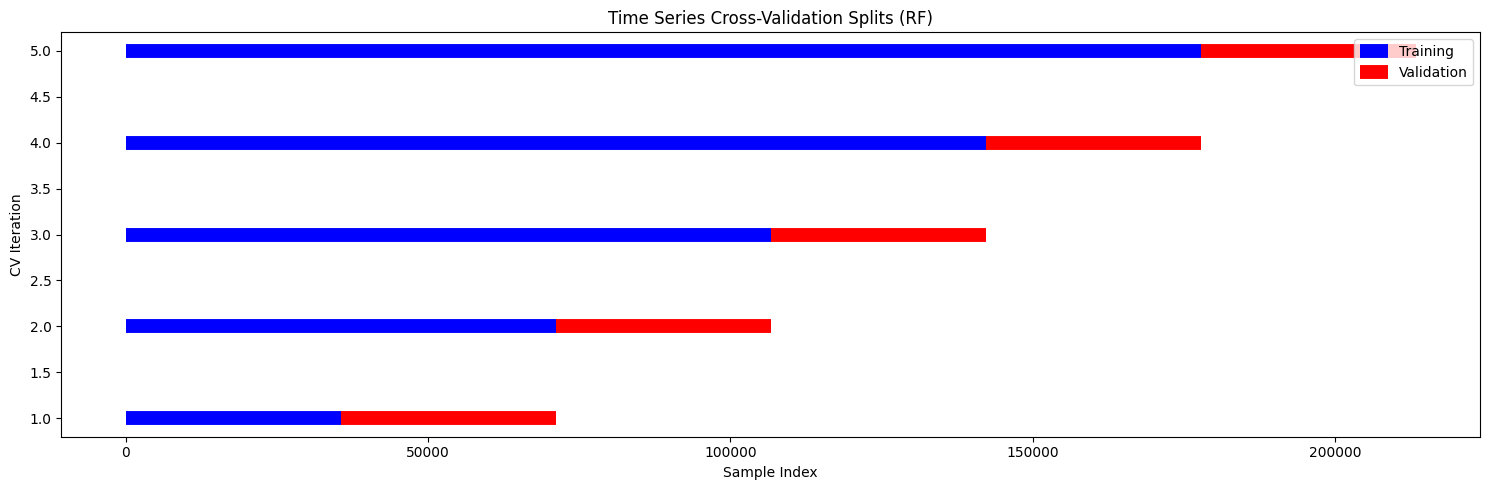


Time Series Cross Validation Structure:

Fold 1:
Training    : 0 to 42104 (n=35555)
Validation  : 42105 to 83327 (n=35551)

Fold 2:
Training    : 0 to 83327 (n=71106)
Validation  : 83328 to 126347 (n=35551)

Fold 3:
Training    : 0 to 126347 (n=106657)
Validation  : 126348 to 167504 (n=35551)

Fold 4:
Training    : 0 to 167504 (n=142208)
Validation  : 167505 to 208633 (n=35551)

Fold 5:
Training    : 0 to 208633 (n=177759)
Validation  : 208634 to 249847 (n=35551)

Initializing Grid Search with Time Series CV for RF...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[ColumnTransformer] ........... (1 of 1) Processing num, total=   0.1s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   12.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   49.8s



Training completed in 1083.27 seconds
Best parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Best cross-validation score: 0.3946274366403196

Evaluating Random Forest model...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s



Classification Report (RF):
              precision    recall  f1-score   support

         Buy       0.37      0.32      0.34     12986
        Hold       0.43      0.33      0.38     11445
        Sell       0.39      0.52      0.44     13035

    accuracy                           0.39     37466
   macro avg       0.40      0.39      0.39     37466
weighted avg       0.39      0.39      0.39     37466



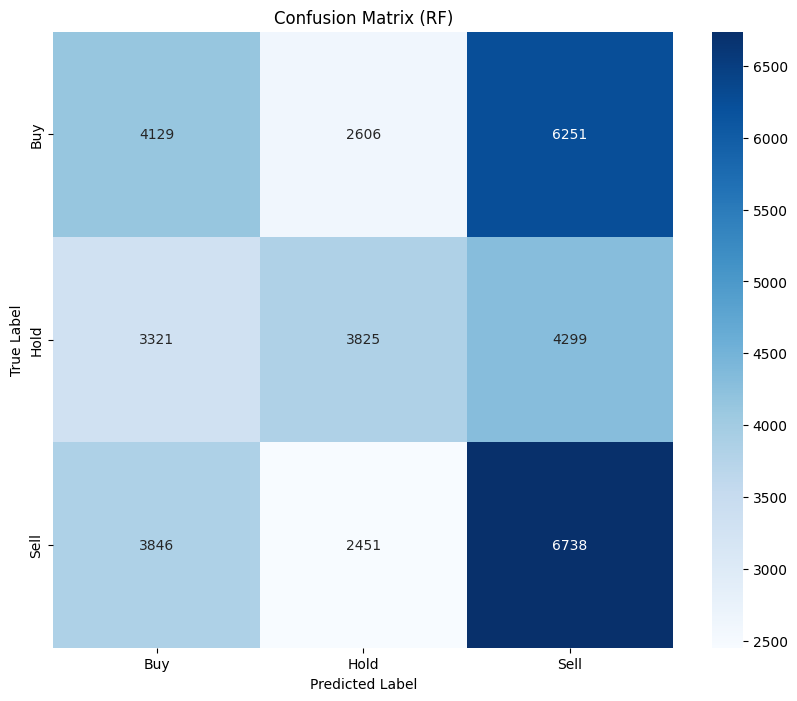


Analyzing Random Forest feature importance...


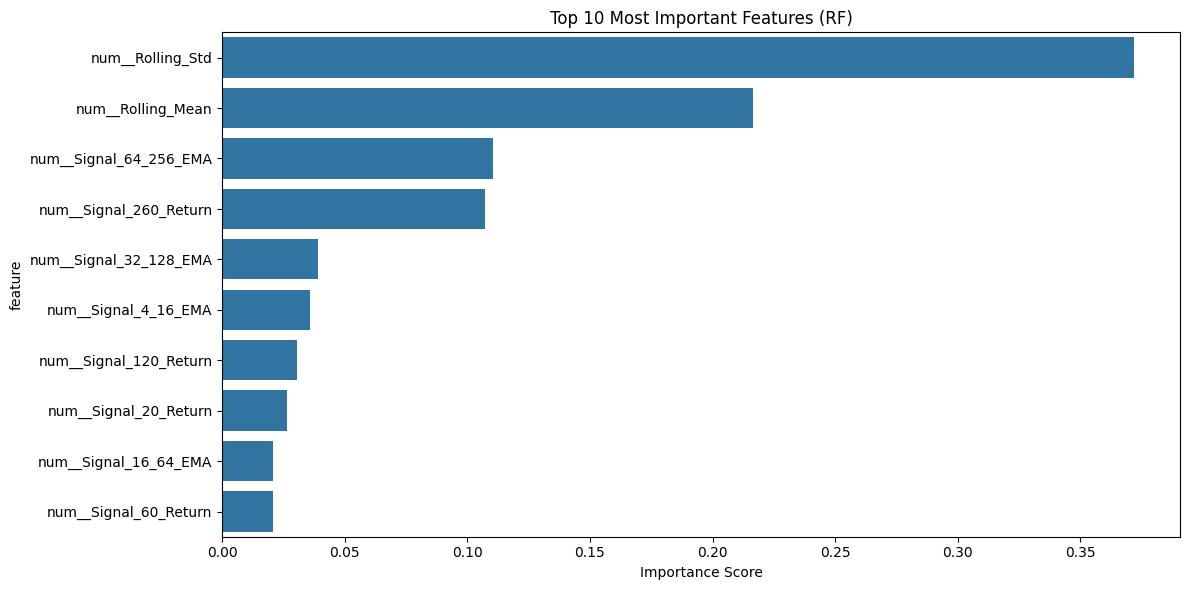


Training XGBoost model...
Starting pipeline execution at 2024-12-02 11:25:40
Using classifier: XGB


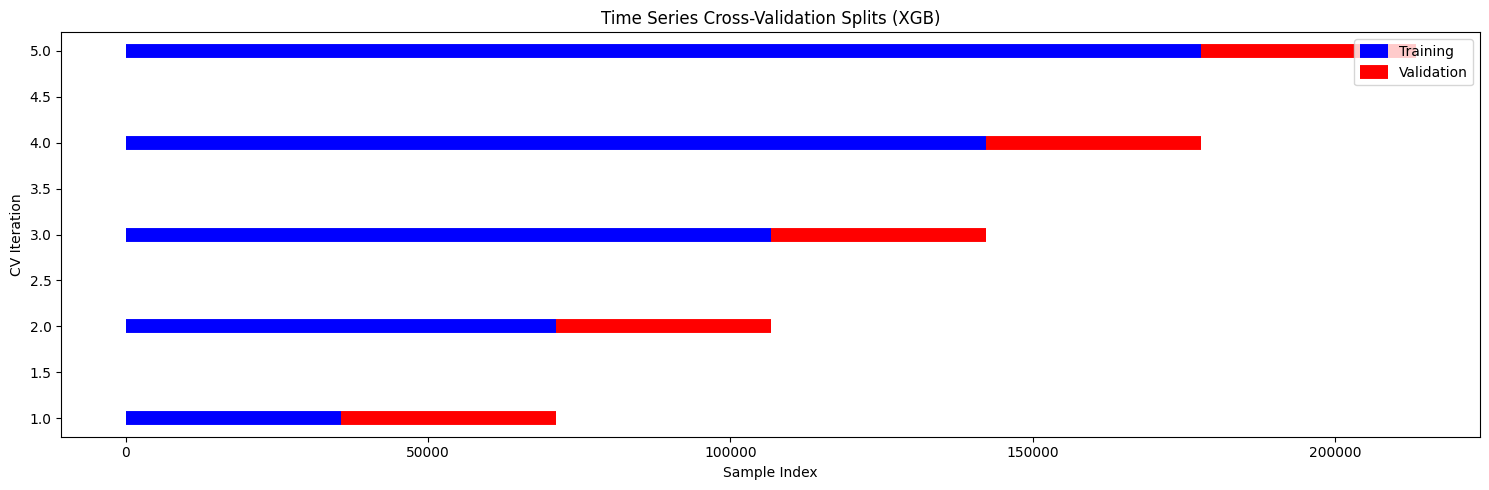


Time Series Cross Validation Structure:

Fold 1:
Training    : 0 to 42104 (n=35555)
Validation  : 42105 to 83327 (n=35551)

Fold 2:
Training    : 0 to 83327 (n=71106)
Validation  : 83328 to 126347 (n=35551)

Fold 3:
Training    : 0 to 126347 (n=106657)
Validation  : 126348 to 167504 (n=35551)

Fold 4:
Training    : 0 to 167504 (n=142208)
Validation  : 167505 to 208633 (n=35551)

Fold 5:
Training    : 0 to 208633 (n=177759)
Validation  : 208634 to 249847 (n=35551)

Initializing Grid Search with Time Series CV for XGB...
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[ColumnTransformer] ........... (1 of 1) Processing num, total=   0.1s

Training completed in 1839.32 seconds
Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best cross-validation score: 0.39536440606452705

Evaluating

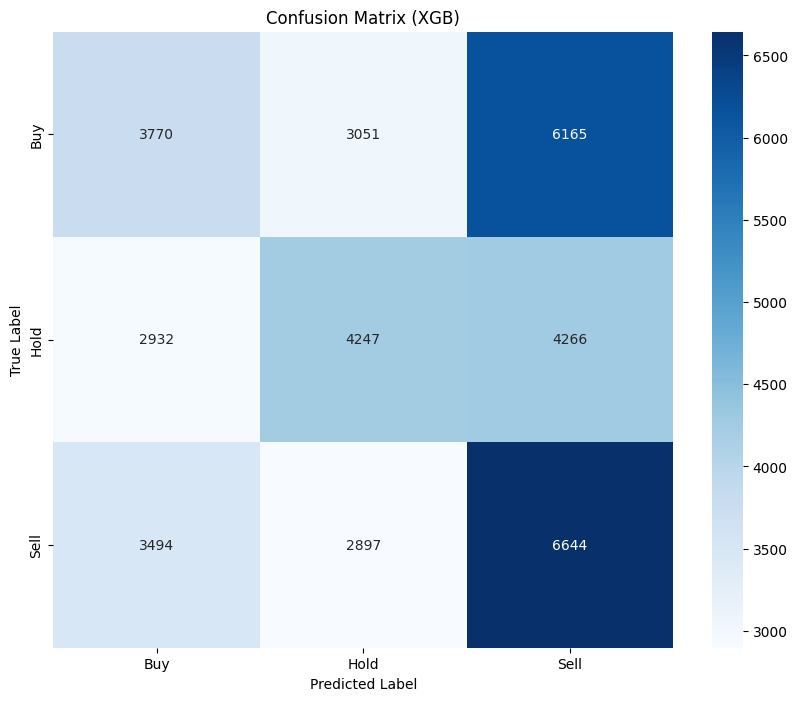


Analyzing XGBoost feature importance...


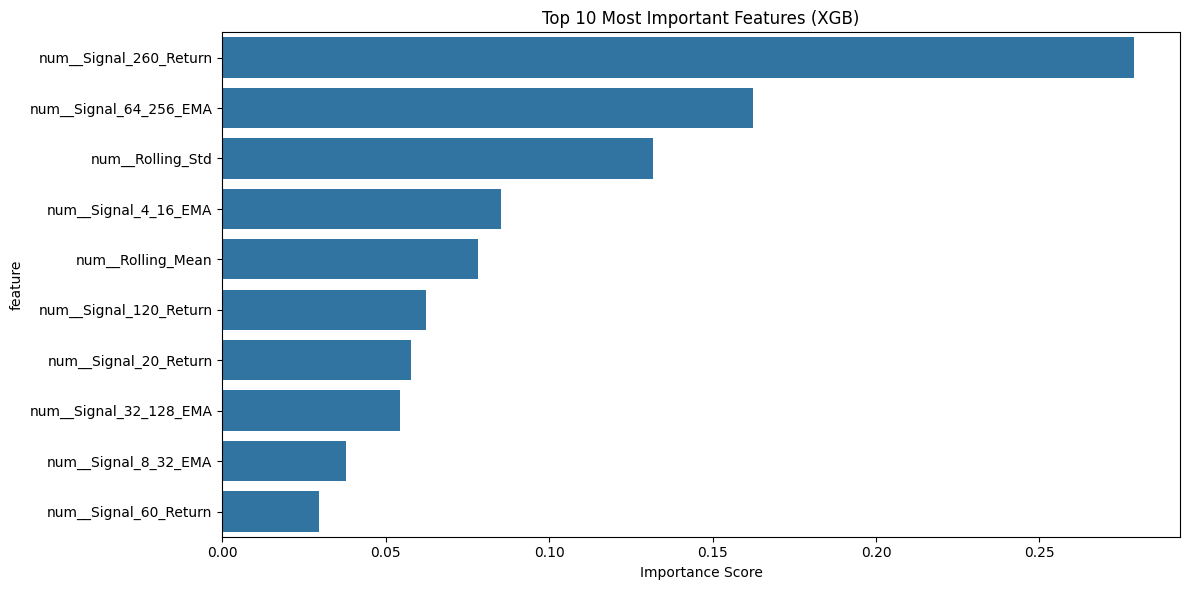

In [159]:
import warnings
import time
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Suppress warnings
warnings.filterwarnings('ignore')

class TimeSeriesClassificationPipeline:
    """
    A flexible pipeline for time series classification tasks supporting multiple classifiers.
    
    Attributes:
        classifier_type (str): Type of classifier ('rf' or 'xgb')
        random_state (int): Random seed for reproducibility
        grid_search: Fitted GridSearchCV object
        feature_importance: DataFrame containing feature importance scores
        prediction_analysis: DataFrame containing prediction analysis results
    """
    
    # Define default parameter grids for each classifier
    DEFAULT_PARAM_GRIDS = {
        'rf': {
            'classifier__n_estimators': [100, 200], # More trees given the complexity
            'classifier__max_depth': [5, 10, 20], # Deeper trees for complex relationships
            'classifier__min_samples_split': [2, 5, 10], # Balance between granularity and overfitting
            'classifier__min_samples_leaf': [1, 2, 4],  # Prevent overfitting 
            'classifier__max_features': ['sqrt', 'log2']  # Important for feature selection
        },
        'xgb': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 6, 9],
            'classifier__learning_rate': [0.01, 0.05],
            'classifier__min_child_weight': [1, 3],    # Help with class imbalance
            'classifier__subsample': [0.8, 0.9],        # Prevent overfitting
            'classifier__colsample_bytree': [0.8, 0.9],    
            'classifier__gamma': [0, 0.1, 0.2]           # Control overfittin
        }
    }
    
    def __init__(self, classifier_type='rf', random_state=42):
        """
        Initialize the pipeline.
        
        Args:
            classifier_type (str): Type of classifier ('rf' or 'xgb')
            random_state (int): Random seed for reproducibility
        """
        if classifier_type not in ['rf', 'xgb']:
            raise ValueError("classifier_type must be either 'rf' or 'xgb'")
            
        self.classifier_type = classifier_type
        self.random_state = random_state
        self.grid_search = None
        self.feature_importance = None
        self.prediction_analysis = None
        self.label_encoder = LabelEncoder()
    
    def _get_classifier(self):
        """
        Get the appropriate classifier based on classifier_type.
        
        Returns:
            sklearn or xgboost classifier object
        """
        if self.classifier_type == 'rf':
            return RandomForestClassifier(
                random_state=self.random_state,
                verbose=1
            )
        else:  # xgb
            return xgb.XGBClassifier(
                random_state=self.random_state,
                eval_metric='mlogloss',
                use_label_encoder=False
            )
    
    def create_preprocessor(self, feature_columns):
        """
        Create preprocessing pipeline for numerical and categorical features.
        
        Args:
            feature_columns (list): List of feature column names
            
        Returns:
            tuple: (ColumnTransformer, numerical_features, categorical_features)
        """
        categorical_features = ['Asset Class'] if 'Asset Class' in feature_columns else []
        numerical_features = [col for col in feature_columns if col not in categorical_features]
        
        transformers = []
        if numerical_features:
            transformers.append(('num', StandardScaler(), numerical_features))
        if categorical_features:
            transformers.append(
                ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
            )
        
        return (ColumnTransformer(transformers=transformers, verbose=True),
                numerical_features,
                categorical_features)
    
    def fit(self, X_train, y_train, feature_columns, param_grid=None):
        """
        Fit the pipeline with grid search and time series cross-validation.
        
        Args:
            X_train: Training features
            y_train: Training labels
            feature_columns: List of feature column names
            param_grid: Dictionary with parameters names (string) as keys and lists of
                       parameter settings to try as values
                       
        Returns:
            self: The fitted pipeline
        """
        print(f"Starting pipeline execution at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Using classifier: {self.classifier_type.upper()}")
        
        # Encode labels
        y_train_encoded = self.label_encoder.fit_transform(y_train)
        
        # Create pipeline components
        preprocessor, _, _ = self.create_preprocessor(feature_columns)
        classifier = self._get_classifier()
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
        
        # Use default param grid if none provided
        if param_grid is None:
            param_grid = self.DEFAULT_PARAM_GRIDS[self.classifier_type]
        
        # Setup cross-validation
        n_samples = len(X_train)
        max_test_size = n_samples // 6
        tscv = self._setup_cross_validation(max_test_size, X_train)
        
        # Perform grid search
        self._perform_grid_search(pipeline, param_grid, tscv, X_train, y_train_encoded)
        
        return self
    
    def _setup_cross_validation(self, max_test_size, X_train):
        """Setup time series cross-validation with visualization."""
        tscv = TimeSeriesSplit(n_splits=5, test_size=max_test_size)
        
        try:
            self.visualize_cv_splits(tscv, X_train)
        except ValueError as e:
            print(f"Warning: Could not visualize CV splits: {str(e)}")
            print("Adjusting cross-validation parameters...")
            tscv = TimeSeriesSplit(n_splits=3, test_size=max_test_size)
            self.visualize_cv_splits(tscv, X_train)
        
        return tscv
    
    def visualize_cv_splits(self, tscv, X_train):
        """Visualize time series cross-validation splits."""
        splits = list(tscv.split(X_train))
        if not splits:
            raise ValueError("No valid splits could be generated")
        
        plt.figure(figsize=(15, 5))
        for i, (train_idx, val_idx) in enumerate(splits):
            plt.hlines(i + 1, train_idx[0], train_idx[-1], 
                      colors='blue', lw=10, label='Training' if i == 0 else "")
            plt.hlines(i + 1, val_idx[0], val_idx[-1], 
                      colors='red', lw=10, label='Validation' if i == 0 else "")
        
        plt.title(f'Time Series Cross-Validation Splits ({self.classifier_type.upper()})')
        plt.ylabel('CV Iteration')
        plt.xlabel('Sample Index')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        self._print_cv_split_details(splits, X_train)
    
    def _print_cv_split_details(self, splits, X_train):
        """Print details of CV splits."""
        print("\nTime Series Cross Validation Structure:")
        for i, (train_idx, val_idx) in enumerate(splits):
            train_dates = X_train.iloc[train_idx].index
            val_dates = X_train.iloc[val_idx].index
            print(f"\nFold {i+1}:")
            print(f"Training    : {train_dates[0]} to {train_dates[-1]} (n={len(train_idx)})")
            print(f"Validation  : {val_dates[0]} to {val_dates[-1]} (n={len(val_idx)})")
    
    def _perform_grid_search(self, pipeline, param_grid, cv, X_train, y_train):
        """Perform grid search with cross-validation."""
        print(f"\nInitializing Grid Search with Time Series CV for {self.classifier_type.upper()}...")
        self.grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=cv,
            scoring='accuracy',
            n_jobs=-1,
            verbose=2,
            return_train_score=True
        )
        
        start_time = time.time()
        self.grid_search.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        print(f"\nTraining completed in {training_time:.2f} seconds")
        print("Best parameters:", self.grid_search.best_params_)
        print("Best cross-validation score:", self.grid_search.best_score_)
    
    def analyze_feature_importance(self):
        """
        Analyze and visualize feature importance.
        
        Returns:
            DataFrame: Feature importance scores
        """
        if self.grid_search is None:
            raise ValueError("Model must be fitted before analyzing feature importance")
            
        feature_names = (self.grid_search.best_estimator_
                        .named_steps['preprocessor']
                        .get_feature_names_out())
        
        best_model = self.grid_search.best_estimator_.named_steps['classifier']
        importance_scores = best_model.feature_importances_
        
        self.feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importance_scores
        }).sort_values('importance', ascending=False)
        
        self._plot_feature_importance()
        return self.feature_importance
    
    def _plot_feature_importance(self):
        """Plot top 10 most important features."""
        plt.figure(figsize=(12, 6))
        sns.barplot(data=self.feature_importance.head(10), x='importance', y='feature')
        plt.title(f'Top 10 Most Important Features ({self.classifier_type.upper()})')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
    
    def predict(self, X_test, y_test=None):
        """Make predictions.
        
        Args:
            X_test: Test features
            y_test: Test labels (optional)
            
        Returns:
            tuple: (encoded predictions, decoded predictions)
        """
        if self.grid_search is None:
            raise ValueError("Model must be fitted before making predictions")
        
        # Make predictions
        y_pred_encoded = self.grid_search.predict(X_test)
        
        # Decode predictions
        y_pred = self.label_encoder.inverse_transform(y_pred_encoded)
        
        return y_pred_encoded, y_pred

    def predict_and_evaluate(self, X_test, y_test, reverse_mapping=None):
        """Make predictions and evaluate model performance."""
        if self.grid_search is None:
            raise ValueError("Model must be fitted before making predictions")
        
        # Get predictions
        y_pred_encoded, y_pred = self.predict(X_test)
        
        # If no reverse_mapping provided, create one from label encoder
        if reverse_mapping is None:
            reverse_mapping = {i: label for i, label in enumerate(self.label_encoder.classes_)}
        
        self._print_classification_report(y_test, y_pred, reverse_mapping)
        self._plot_confusion_matrix(y_test, y_pred, reverse_mapping)
        
        return y_pred_encoded, y_pred
    
    def analyze_cv_results(self):
        """Analyze cross-validation results."""
        if self.grid_search is None:
            raise ValueError("Model must be fitted before analyzing CV results")
            
        cv_results = pd.DataFrame(self.grid_search.cv_results_)
        print(f"\nCross-validation results summary for {self.classifier_type.upper()}:")
        for params, mean_score, std_score in zip(
            cv_results['params'],
            cv_results['mean_test_score'],
            cv_results['std_test_score']
        ):
            print(f"\nParameters: {params}")
            print(f"Mean CV Score: {mean_score:.3f} (+/- {std_score * 2:.3f})")
            
            fold_scores = [cv_results[f'split{i}_test_score'][cv_results['params'] == params].iloc[0] 
                          for i in range(5)]
            for fold, score in enumerate(fold_scores, 1):
                print(f"Fold {fold} Score: {score:.3f}")
    
    def _print_classification_report(self, y_true, y_pred, reverse_mapping):
        """Print classification report with proper label mapping."""
        print(f"\nClassification Report ({self.classifier_type.upper()}):")
        print(classification_report(y_true, y_pred,
                                 target_names=[reverse_mapping[i] for i in sorted(reverse_mapping.keys())]))
    
    def _plot_confusion_matrix(self, y_true, y_pred, reverse_mapping):
        """Plot confusion matrix with proper label mapping."""
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=[reverse_mapping[i] for i in sorted(reverse_mapping.keys())],
                   yticklabels=[reverse_mapping[i] for i in sorted(reverse_mapping.keys())])
        plt.title(f'Confusion Matrix ({self.classifier_type.upper()})')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    
    def _print_performance_summary(self, y_test, y_pred, reverse_mapping):
        """Print detailed performance summary by class."""
        print(f"\nDetailed Model Performance Summary ({self.classifier_type.upper()}):")
        print(f"Overall Accuracy: {(y_test == y_pred).mean():.2%}")
        print("\nAccuracy by Class:")
        for label in sorted(reverse_mapping.keys()):
            mask = y_test == label
            if mask.any():
                class_acc = (y_pred[mask] == y_test[mask]).mean()
                class_count = sum(mask)

    def predict_proba(self, X_test):
        """Get probability predictions for each class.
        Returns:
            numpy.ndarray: Probability predictions for each class
        """
        if self.grid_search is None:
            raise ValueError("Model must be fitted before making predictions")
        
        return self.grid_search.predict_proba(X_test)

    def get_prediction_df(self, X_test, y_test, df_test):
        """Create a DataFrame with predictions and probabilities.
        
        Args:
            X_test: Test features
            y_test: Test labels
            df_test: Original test DataFrame
            
        Returns:
            pandas.DataFrame: DataFrame with predictions and probabilities
        """
        # Encode test labels
        y_test_encoded = self.label_encoder.transform(y_test)
        
        # Get predictions and probabilities
        y_pred_encoded, y_pred = self.predict(X_test)
        probabilities = self.predict_proba(X_test)
        
        # Create results DataFrame
        df_results = df_test.copy()
        df_results['True_Label'] = y_test  # Original labels
        df_results['Predicted_Label'] = y_pred  # Decoded predictions
        
        # Add probability columns for each class
        class_labels = self.label_encoder.classes_
        for i, label in enumerate(class_labels):
            df_results[f'Probability_{label}'] = probabilities[:, i]
            
        return df_results


    def combine_model_predictions(rf_pipeline, xgb_pipeline, X_test, y_test, df_test, 
                                method='weighted', rf_weight=0.5):
        """Combine predictions from RF and XGB models.
        
        Args:
            rf_pipeline: Fitted Random Forest pipeline
            xgb_pipeline: Fitted XGBoost pipeline
            X_test: Test features
            y_test: Test labels
            df_test: Original test DataFrame
            method: Combination method ('weighted' or 'max_prob')
            rf_weight: Weight for RF predictions (only used if method='weighted')
            
        Returns:
            pandas.DataFrame: Combined predictions DataFrame
        """
        # Get probabilities from both models
        rf_proba = rf_pipeline.predict_proba(X_test)
        xgb_proba = xgb_pipeline.predict_proba(X_test)
        
        if method == 'weighted':
            # Weighted average of probabilities
            combined_proba = rf_weight * rf_proba + (1 - rf_weight) * xgb_proba
        elif method == 'max_prob':
            # Take prediction from model with highest probability
            rf_max_proba = np.max(rf_proba, axis=1)
            xgb_max_proba = np.max(xgb_proba, axis=1)
            combined_proba = np.where(
                rf_max_proba[:, np.newaxis] >= xgb_max_proba[:, np.newaxis],
                rf_proba,
                xgb_proba
            )
        else:
            raise ValueError("method must be either 'weighted' or 'max_prob'")
        
        # Get combined predictions
        y_pred = np.argmax(combined_proba, axis=1)
        
        # Create mapping from encoded to original labels
        reverse_mapping = {i: label for i, label in enumerate(rf_pipeline.label_encoder.classes_)}
        
        # Encode test labels
        y_test_encoded = rf_pipeline.label_encoder.transform(y_test)
        
        # Create results DataFrame
        df_results = df_test.copy()
        df_results['True_Label'] = [reverse_mapping[label] for label in y_test_encoded]
        df_results['Predicted_Label'] = [reverse_mapping[label] for label in y_pred]
        
        # Add probability columns for each class
        for i, label in enumerate(rf_pipeline.label_encoder.classes_):
            df_results[f'Probability_{label}'] = combined_proba[:, i]
        
        return df_results

    
    # Initialize and train Random Forest pipeline
    print("Training Random Forest model...")
rf_pipeline = TimeSeriesClassificationPipeline(classifier_type='rf', random_state=42)
rf_pipeline.fit(X_train, y_train, feature_columns)

# Evaluate Random Forest model
print("\nEvaluating Random Forest model...")
rf_predictions = rf_pipeline.predict_and_evaluate(X_test, y_test)

# Analyze Random Forest results
#print("\nAnalyzing Random Forest cross-validation results...")
#rf_pipeline.analyze_cv_results()

# Get feature importance for Random Forest
print("\nAnalyzing Random Forest feature importance...")
rf_feature_importance = rf_pipeline.analyze_feature_importance()


# Initialize and train XGBoost pipeline
print("\nTraining XGBoost model...")
xgb_pipeline = TimeSeriesClassificationPipeline(classifier_type='xgb', random_state=42)
xgb_pipeline.fit(X_train, y_train, feature_columns)

# Evaluate XGBoost model
print("\nEvaluating XGBoost model...")
xgb_predictions = xgb_pipeline.predict_and_evaluate(X_test, y_test)

# Analyze XGBoost results
#print("\nAnalyzing XGBoost cross-validation results...")
#xgb_pipeline.analyze_cv_results()

# Get feature importance for XGBoost
print("\nAnalyzing XGBoost feature importance...")
xgb_feature_importance = xgb_pipeline.analyze_feature_importance()


In [161]:
# Compare models
print("\nModel Comparison:")
print("Random Forest CV Score:", rf_pipeline.grid_search.best_score_)
print("XGBoost CV Score:", xgb_pipeline.grid_search.best_score_)

# Compare feature importance rankings
print("\nFeature Importance Comparison:")
comparison = pd.DataFrame({
    'RF_Importance': rf_feature_importance.set_index('feature')['importance'],
    'XGB_Importance': xgb_feature_importance.set_index('feature')['importance']
})
print(comparison.sort_values('RF_Importance', ascending=False))


# Print model comparison summary
print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)
print(f"Random Forest Best Parameters: {rf_pipeline.grid_search.best_params_}")
print(f"Random Forest Best CV Score: {rf_pipeline.grid_search.best_score_:.4f}")
print(f"Random Forest Test Set Accuracy: {(rf_predictions == y_test).mean():.4f}")
print("\n")
print(f"XGBoost Best Parameters: {xgb_pipeline.grid_search.best_params_}")
print(f"XGBoost Best CV Score: {xgb_pipeline.grid_search.best_score_:.4f}")
print(f"XGBoost Test Set Accuracy: {(xgb_predictions == y_test).mean():.4f}")

# Get predictions and classification reports for both models
print("\n" + "="*50)
print("RANDOM FOREST TEST SET PERFORMANCE")
print("="*50)
rf_predictions = rf_pipeline.predict(X_test, y_test)

print("\n" + "="*50)
print("XGBOOST TEST SET PERFORMANCE")
print("="*50)
xgb_predictions = xgb_pipeline.predict(X_test, y_test)


Model Comparison:
Random Forest CV Score: 0.3946274366403196
XGBoost CV Score: 0.39536440606452705

Feature Importance Comparison:
                        RF_Importance  XGB_Importance
feature                                              
num__Rolling_Std             0.372098        0.131763
num__Rolling_Mean            0.216712        0.078141
num__Signal_64_256_EMA       0.110263        0.162295
num__Signal_260_Return       0.107348        0.279080
num__Signal_32_128_EMA       0.039220        0.054263
num__Signal_4_16_EMA         0.035937        0.085281
num__Signal_120_Return       0.030654        0.062447
num__Signal_20_Return        0.026336        0.057870
num__Signal_16_64_EMA        0.020690        0.021343
num__Signal_60_Return        0.020514        0.029745
num__Signal_8_32_EMA         0.020229        0.037774

MODEL COMPARISON SUMMARY
Random Forest Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 4, 'classif

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s



XGBOOST TEST SET PERFORMANCE


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


In [96]:
# For Random Forest
#rf_results = rf_pipeline.get_prediction_df(X_test, y_test, df_test)

# For XGBoost
#xgb_results = xgb_pipeline.get_prediction_df(X_test, y_test, df_test)

## Make predictions

In [163]:
# Use the provided mappings


def add_predictions_to_df(df_test, rf_pipeline, xgb_pipeline, X_test, y_test, 
                         model_choice='RF', mix_weight=0.5,
                         custom_mapping={'Sell': -1, 'Hold': 0, 'Buy': 1},
                         reverse_mapping={-1: 'Sell', 0: 'Hold', 1: 'Buy'}):
    """
    Add predictions to dataframe with choice of RF, XGB or Mixed predictions.
    
    Args:
        df_test: Test DataFrame
        rf_pipeline: Fitted Random Forest pipeline
        xgb_pipeline: Fitted XGBoost pipeline
        X_test: Test features
        y_test: Test labels
        model_choice: 'RF', 'XGB', or 'MIX'
        mix_weight: Weight for RF in mixed predictions (0 to 1)
        custom_mapping: Dictionary mapping labels to numbers
        reverse_mapping: Dictionary mapping numbers to labels
    """
    # Get predictions from both models
    y_pred_rf_encoded, y_pred_rf = rf_pipeline.predict(X_test)
    probabilities_rf = rf_pipeline.predict_proba(X_test)
    
    y_pred_xgb_encoded, y_pred_xgb = xgb_pipeline.predict(X_test)
    probabilities_xgb = xgb_pipeline.predict_proba(X_test)
    
    # Choose predictions based on model_choice
    if model_choice.upper() == 'RF':
        y_pred = y_pred_rf
        probabilities = probabilities_rf
    elif model_choice.upper() == 'XGB':
        y_pred = y_pred_xgb
        probabilities = probabilities_xgb
    elif model_choice.upper() == 'MIX':
        # Combine probabilities using weighted average
        probabilities = mix_weight * probabilities_rf + (1 - mix_weight) * probabilities_xgb
        # Get predictions from combined probabilities
        y_pred_encoded = np.argmax(probabilities, axis=1)
        y_pred = rf_pipeline.label_encoder.inverse_transform(y_pred_encoded)
    else:
        raise ValueError("model_choice must be 'RF', 'XGB', or 'MIX'")
    
    # Add predictions to test DataFrame
    df_test['Predicted_Label'] = y_pred
    df_test['y_pred'] = df_test['Predicted_Label'].map(custom_mapping)
    df_test['y_true'] = df_test['final_classification'].map(custom_mapping)
    df_test['Probability_Sell'] = probabilities[:, 0]
    df_test['Probability_Hold'] = probabilities[:, 1]
    df_test['Probability_Buy'] = probabilities[:, 2]
    
    return df_test

# Example usage:
# For Random Forest
#df_test= add_predictions_to_df(df_test.copy(), rf_pipeline, xgb_pipeline, X_test, y_test, model_choice='RF')

# For XGBoost
#df_test = add_predictions_to_df(df_test.copy(), rf_pipeline, xgb_pipeline, X_test, y_test, model_choice='XGB')

# For Mixed predictions (60% RF, 40% XGB)
df_test = add_predictions_to_df(df_test.copy(), rf_pipeline, xgb_pipeline, X_test, y_test, model_choice='MIX', mix_weight=0.5)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s



Random Forest Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

        Sell       0.37      0.34      0.35     12986
        Hold       0.43      0.33      0.37     11445
         Buy       0.39      0.50      0.44     13035

    accuracy                           0.39     37466
   macro avg       0.40      0.39      0.39     37466
weighted avg       0.39      0.39      0.39     37466


XGBoost Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

        Sell       0.36      0.29      0.32     12986
        Hold       0.42      0.37      0.39     11445
         Buy       0.39      0.51      0.44     13035

    accuracy                           0.39     37466
   macro avg       0.39      0.39      0.38     37466
weighted avg       0.39      0.39      0.38     37466


Mixed Model Classification Report (RF Weight:

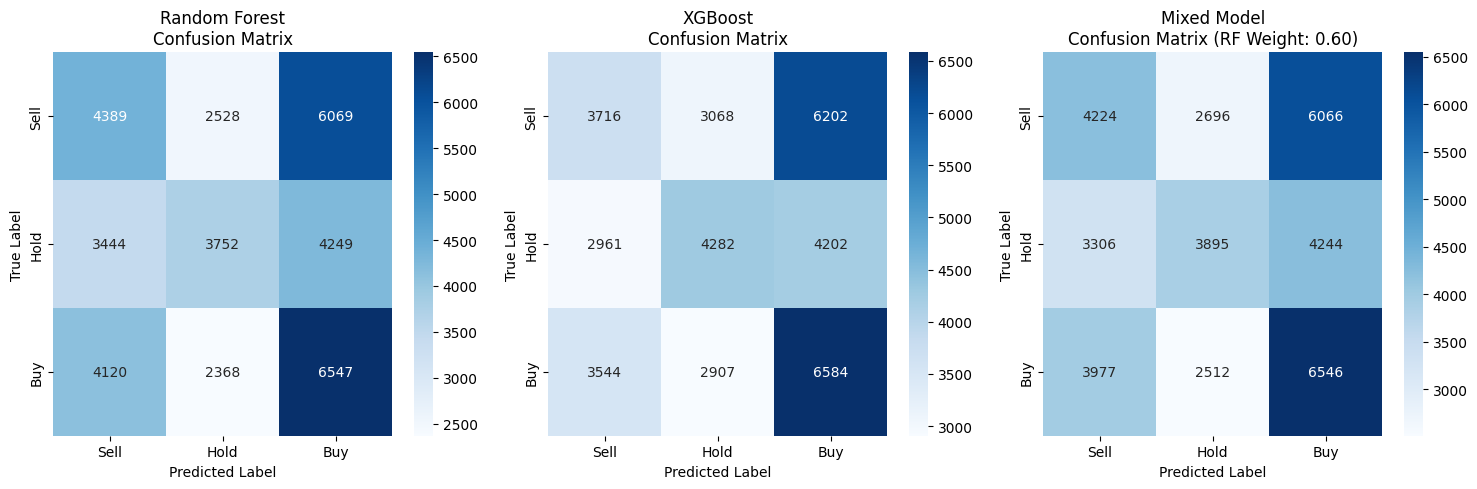


Overall Accuracy Comparison:
------------------------------------------------------------
Random Forest: 0.3920
XGBoost: 0.3892
Mixed Model: 0.3914


In [101]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


def compare_model_performance(rf_pipeline, xgb_pipeline, X_test, y_test, 
                            custom_mapping={'Sell': -1, 'Hold': 0, 'Buy': 1},
                            reverse_mapping={-1: 'Sell', 0: 'Hold', 1: 'Buy'},
                            mix_weight=0.5):
    """
    Compare performance of RF, XGB and Mixed models using classification reports.
    
    Args:
        rf_pipeline: Fitted Random Forest pipeline
        xgb_pipeline: Fitted XGBoost pipeline
        X_test: Test features
        y_test: Test labels
        custom_mapping: Dictionary mapping labels to numbers
        reverse_mapping: Dictionary mapping numbers to labels
        mix_weight: Weight for RF in mixed predictions (0 to 1)
    """
    # Get predictions and probabilities for both models
    y_pred_rf_encoded, y_pred_rf = rf_pipeline.predict(X_test)
    probabilities_rf = rf_pipeline.predict_proba(X_test)
    
    y_pred_xgb_encoded, y_pred_xgb = xgb_pipeline.predict(X_test)
    probabilities_xgb = xgb_pipeline.predict_proba(X_test)
    
    # Get mixed model predictions
    probabilities_mix = mix_weight * probabilities_rf + (1 - mix_weight) * probabilities_xgb
    y_pred_mix_encoded = np.argmax(probabilities_mix, axis=1)
    y_pred_mix = rf_pipeline.label_encoder.inverse_transform(y_pred_mix_encoded)
    
    # Convert y_test to numerical format if it's not already
    y_test_num = y_test.map(custom_mapping) if isinstance(y_test.iloc[0], str) else y_test
    
    # Create classification reports
    print(f"\nRandom Forest Classification Report:")
    print("-" * 60)
    print(classification_report(y_test, y_pred_rf, 
                              target_names=['Sell', 'Hold', 'Buy']))
    
    print(f"\nXGBoost Classification Report:")
    print("-" * 60)
    print(classification_report(y_test, y_pred_xgb, 
                              target_names=['Sell', 'Hold', 'Buy']))
    
    print(f"\nMixed Model Classification Report (RF Weight: {mix_weight:.2f}):")
    print("-" * 60)
    print(classification_report(y_test, y_pred_mix, 
                              target_names=['Sell', 'Hold', 'Buy']))
    
    # Create confusion matrices with seaborn
    plt.figure(figsize=(15, 5))
    
    # RF Confusion Matrix
    plt.subplot(131)
    sns.heatmap(confusion_matrix(y_test, y_pred_rf), 
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Sell', 'Hold', 'Buy'],
                yticklabels=['Sell', 'Hold', 'Buy'])
    plt.title('Random Forest\nConfusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # XGB Confusion Matrix
    plt.subplot(132)
    sns.heatmap(confusion_matrix(y_test, y_pred_xgb), 
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Sell', 'Hold', 'Buy'],
                yticklabels=['Sell', 'Hold', 'Buy'])
    plt.title('XGBoost\nConfusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Mixed Model Confusion Matrix
    plt.subplot(133)
    sns.heatmap(confusion_matrix(y_test, y_pred_mix), 
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Sell', 'Hold', 'Buy'],
                yticklabels=['Sell', 'Hold', 'Buy'])
    plt.title(f'Mixed Model\nConfusion Matrix (RF Weight: {mix_weight:.2f})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # Return predictions and accuracy scores
    return {
        'RF': {
            'predictions': y_pred_rf,
            'accuracy': accuracy_score(y_test, y_pred_rf),
            'probabilities': probabilities_rf
        },
        'XGB': {
            'predictions': y_pred_xgb,
            'accuracy': accuracy_score(y_test, y_pred_xgb),
            'probabilities': probabilities_xgb
        },
        'MIX': {
            'predictions': y_pred_mix,
            'accuracy': accuracy_score(y_test, y_pred_mix),
            'probabilities': probabilities_mix
        }
    }

# Example usage:
results = compare_model_performance(rf_pipeline, xgb_pipeline, X_test, y_test, mix_weight=0.6)

# Print overall accuracy comparison
print("\nOverall Accuracy Comparison:")
print("-" * 60)
print(f"Random Forest: {results['RF']['accuracy']:.4f}")
print(f"XGBoost: {results['XGB']['accuracy']:.4f}")
print(f"Mixed Model: {results['MIX']['accuracy']:.4f}")

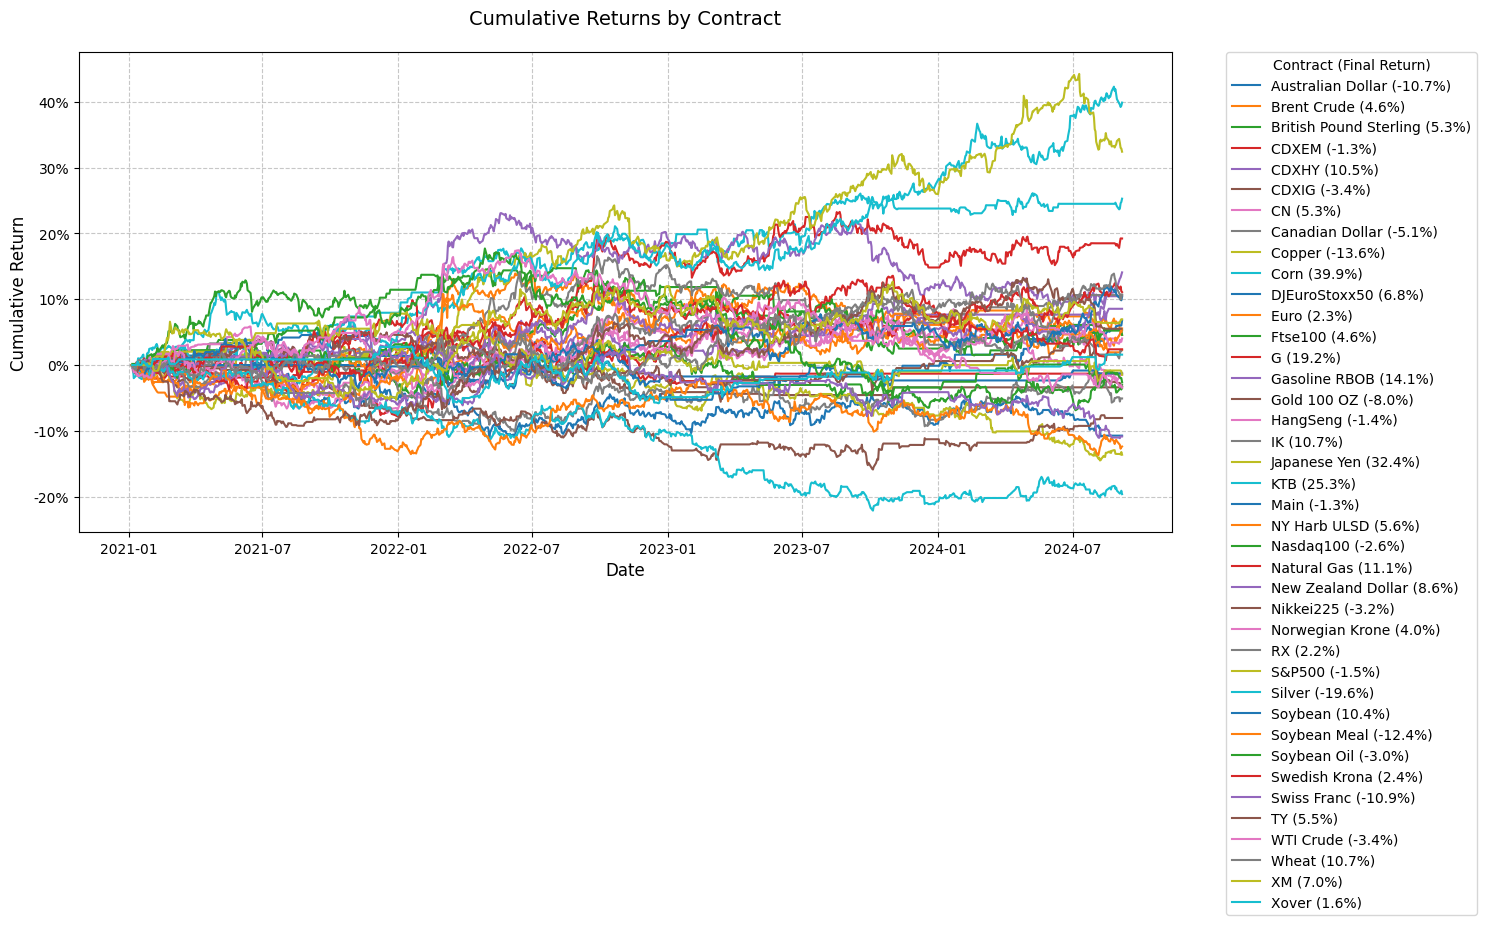

In [165]:
# this version has  include_tc=True

# Function to calculate returns for a signal
def calculate_model_returns(group, target_vol=0.05, include_tc=False):
    # Sort by date
    group = group.sort_values('Date')
    # Apply y_pred - prediction

      # Calculate volatility multiplier with adjustment for lag effect
    # Multiply target_vol by sqrt(2) to compensate for lag effect
    adjusted_target = target_vol * np.sqrt(2) * .9 # Adjustment factor =np.sqrt(2) * .9
    group['Vol_Multiplier'] = np.clip(adjusted_target / group['Rolling_Std'], -5, 5)
    # Get signal changes for transaction cost calculation
    signal_changes = np.abs(group['y_pred'].shift(1) - group['y_pred'].shift(2))
    
    # Apply prediction and volatility targeting
    if include_tc:
        # Apply signal and subtract transaction costs when signal changes
        group['Act_Return'] = (group['Return'] * group['y_pred'].shift(1) - (signal_changes * group['Transaction_Cost'])/2) * group['Vol_Multiplier'].shift(1)
    else:
        group['Act_Return'] = group['Return'] * group['y_pred'].shift(1)  * group['Vol_Multiplier'].shift(1) # shift(1) ensures we're using previous day's signal
        

    group.loc[group.index[0], 'Act_Return'] = 0
    group['Act_Cum_Return'] = (1 + group['Act_Return']).cumprod() - 1
    
    return group

# Calculate returns lambda x: calculate_model_returns(x, target_vol=0.05, include_tc=True)
df_test = df_test.groupby('Contract').apply(lambda x: calculate_model_returns(x, target_vol=0.05, include_tc=True)).reset_index(drop=True)

# Plot cumulative returns for each contract
plt.figure(figsize=(15, 8))
for contract in df_test['Contract'].unique():
    contract_data = df_test[df_test['Contract'] == contract]
    plt.plot(contract_data['Date'], contract_data['Act_Cum_Return'], 
             label=f'{contract} ({contract_data["Act_Cum_Return"].iloc[-1]:.1%})')

# Add plot formatting
plt.title('Cumulative Returns by Contract', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Add legend with better formatting
plt.legend(title='Contract (Final Return)', 
          bbox_to_anchor=(1.05, 1),  # Position legend outside plot
          loc='upper left',
          borderaxespad=0.,
          fontsize=10)

# Adjust layout to prevent legend cutoff
plt.tight_layout()

# Show plot
plt.show()


In [171]:
import numpy as np
import pandas as pd
from scipy import stats

def calculate_performance_metrics(df, return_column='Act_Return', cum_return_column='Act_Cum_Return'):
   
    def calculate_metrics(group):
        # Assuming daily returns, adjust accordingly if using different frequency
        trading_days = 252
        
        # Basic return metrics
        total_return = (1 + group[return_column]).prod() - 1
        periods = len(group)
        annualized_return = (1 + total_return) ** (trading_days / periods) - 1
        
        # Risk metrics
        daily_vol = group[return_column].std()
        annualized_vol = daily_vol * np.sqrt(trading_days)
        
        # Sharpe Ratio (assuming 0% risk-free rate for simplicity)
        sharpe_ratio = annualized_return / annualized_vol if annualized_vol != 0 else 0
        
        # Maximum Drawdown
        cum_returns = group[cum_return_column]
        rolling_max = cum_returns.expanding().max()
        drawdowns = cum_returns - rolling_max
        max_drawdown = drawdowns.min()
        
        # Higher moments
        skewness = stats.skew(group[return_column])
        kurtosis = stats.kurtosis(group[return_column])
        
        return pd.Series({
            'Annualized_Return': annualized_return,
            'Annualized_Volatility': annualized_vol,
            'Sharpe_Ratio': sharpe_ratio,
            'Max_Drawdown': max_drawdown,
            'Skewness': skewness,
            'Kurtosis': kurtosis,
            'Total_Return': total_return,
            'Number_of_Periods': periods
        })
    
    # Calculate metrics by Asset Class
    asset_class_metrics = df.groupby('Asset Class').apply(calculate_metrics)
    asset_class_metrics = asset_class_metrics.reset_index()
    asset_class_metrics['Contract'] = 'AssetGroup'
    asset_class_metrics['Grouping_Level'] = 'Asset Class'
    
    # Calculate metrics by Contract
    contract_metrics = df.groupby(['Asset Class', 'Contract']).apply(calculate_metrics)
    contract_metrics = contract_metrics.reset_index()
    contract_metrics['Grouping_Level'] = 'Contract'
    
    # Combine metrics
    combined_metrics = pd.concat([asset_class_metrics, contract_metrics], ignore_index=True)
    
    # Format metrics as percentages where appropriate
    percentage_columns = ['Annualized_Return', 'Annualized_Volatility', 'Max_Drawdown', 'Total_Return']
    for col in percentage_columns:
        combined_metrics[col] = combined_metrics[col] * 100
    
    return combined_metrics

def display_metrics(metrics_df):
    """
    Format and display the performance metrics in a readable format.
    """
    formatted_df = metrics_df.copy()
    
    # Format percentage columns
    percentage_cols = ['Annualized_Return', 'Annualized_Volatility', 'Max_Drawdown', 'Total_Return']
    for col in percentage_cols:
        formatted_df[col] = formatted_df[col].round(2).astype(str) + '%'
    
    # Format other numeric columns
    formatted_df['Sharpe_Ratio'] = formatted_df['Sharpe_Ratio'].round(2)
    formatted_df['Skewness'] = formatted_df['Skewness'].round(2)
    formatted_df['Kurtosis'] = formatted_df['Kurtosis'].round(2)
    
    # Reorder columns
    column_order = [
        'Asset Class',
        'Contract',
        'Grouping_Level',
        'Annualized_Return',
        'Annualized_Volatility',
        'Sharpe_Ratio',
        'Max_Drawdown',
        'Skewness',
        'Kurtosis',
        'Total_Return',
        'Number_of_Periods'
    ]
    formatted_df = formatted_df[column_order]
    
    # Sort by Asset_Class and Grouping_Level (Asset_Class level first, then Contract level)
    formatted_df = formatted_df.sort_values(['Asset Class', 'Grouping_Level', 'Contract'])
    
    return formatted_df
# Calculate metrics
metrics_df = calculate_performance_metrics(df_test)

# Display formatted results
formatted_metrics = display_metrics(metrics_df)
formatted_metrics

Asset Class                Contract Grouping_Level Annualized_Return  \
0         Bond              AssetGroup    Asset Class             2.73%   
5         Bond                      CN       Contract             1.43%   
6         Bond                       G       Contract             4.72%   
7         Bond                      IK       Contract             2.75%   
8         Bond                     KTB       Contract             6.65%   
9         Bond                      RX       Contract             0.58%   
10        Bond                      TY       Contract             1.47%   
11        Bond                      XM       Contract             1.78%   
1       Comdty              AssetGroup    Asset Class             0.47%   
12      Comdty             Brent Crude       Contract             1.19%   
13      Comdty                  Copper       Contract            -3.91%   
14      Comdty                    Corn       Contract             9.56%   
15      Comdty           Gasoline RBOB       Contract             3.65%   
16      Comdty             Gold 100 OZ       Contract            -2.26%   
17      Comdty            NY Harb ULSD       Contract             1.48%   
18      Comdty             Natural Gas       Contract              2.9%   
19      Comdty                  Silver       Contract            -5.77%   
20      Comdty                 Soybean       Contract             2.73%   
21      Comdty            Soybean Meal       Contract            -3.53%   
22      Comdty             Soybean Oil       Contract            -0.82%   
23      Comdty               WTI Crude       Contract            -0.95%   
24      Comdty                   Wheat       Contract             2.79%   
2       Credit              AssetGroup    Asset Class              0.3%   
25      Credit                   CDXEM       Contract            -0.36%   
26      Credit                   CDXHY       Contract             2.77%   
27      Credit                   CDXIG       Contract            -0.94%   
28      Credit                    Main       Contract            -0.35%   
29      Credit                   Xover       Contract             0.43%   
3       Equity              AssetGroup    Asset Class              0.1%   
30      Equity           DJEuroStoxx50       Contract             1.76%   
31      Equity                 Ftse100       Contract             1.19%   
32      Equity                HangSeng       Contract            -0.39%   
33      Equity               Nasdaq100       Contract            -0.71%   
34      Equity               Nikkei225       Contract            -0.91%   
35      Equity                  S&P500       Contract            -0.41%   
4           FX              AssetGroup    Asset Class             0.64%   
36          FX       Australian Dollar       Contract            -2.93%   
37          FX  British Pound Sterling       Contract             1.37%   
38          FX         Canadian Dollar       Contract            -1.36%   
39          FX                    Euro       Contract              0.6%   
40          FX            Japanese Yen       Contract             7.64%   
41          FX      New Zealand Dollar       Contract             2.18%   
42          FX         Norwegian Krone       Contract             1.04%   
43          FX           Swedish Krona       Contract             0.62%   
44          FX             Swiss Franc       Contract            -2.97%   

   Annualized_Volatility  Sharpe_Ratio Max_Drawdown  Skewness  Kurtosis  \
0                  6.31%          0.43      -35.53%       NaN       NaN   
5                  6.32%          0.23       -7.25%       NaN       NaN   
6                  6.69%          0.71       -8.45%       NaN       NaN   
7                  5.67%          0.49      -12.55%       NaN       NaN   
8                   6.3%          1.06       -6.71%       NaN       NaN   
9                   6.1%          0.09       -9.94%       NaN       NaN   
10                 6.62%   

In [173]:
df_test['Contract'].unique()

array(['Australian Dollar', 'Brent Crude', 'British Pound Sterling',
       'CDXEM', 'CDXHY', 'CDXIG', 'CN', 'Canadian Dollar', 'Copper',
       'Corn', 'DJEuroStoxx50', 'Euro', 'Ftse100', 'G', 'Gasoline RBOB',
       'Gold 100 OZ', 'HangSeng', 'IK', 'Japanese Yen', 'KTB', 'Main',
       'NY Harb ULSD', 'Nasdaq100', 'Natural Gas', 'New Zealand Dollar',
       'Nikkei225', 'Norwegian Krone', 'RX', 'S&P500', 'Silver',
       'Soybean', 'Soybean Meal', 'Soybean Oil', 'Swedish Krona',
       'Swiss Franc', 'TY', 'WTI Crude', 'Wheat', 'XM', 'Xover'],
      dtype=object)

## Averaging out

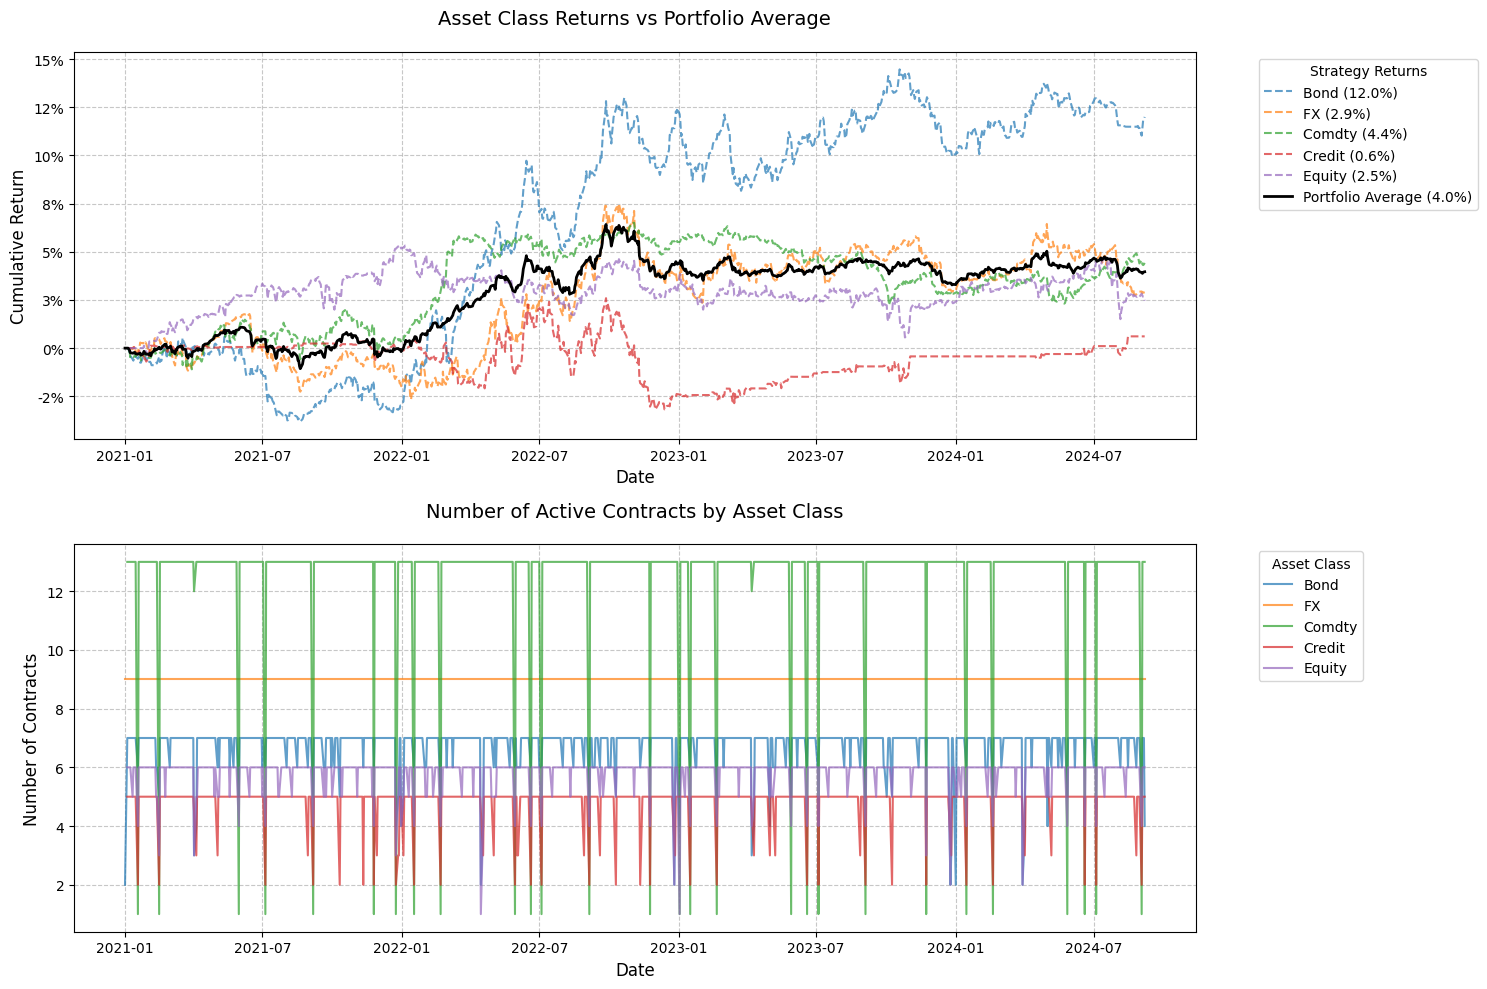


Performance Metrics for Portfolio and Asset Classes:


Asset Class           Contract Grouping_Level Annualized_Return  \
0         Bond         AssetGroup    Asset Class             3.02%   
1       Comdty         AssetGroup    Asset Class             1.15%   
2       Credit         AssetGroup    Asset Class             0.16%   
3       Equity         AssetGroup    Asset Class             0.64%   
4           FX         AssetGroup    Asset Class             0.75%   
5    Portfolio         AssetGroup    Asset Class             1.02%   
25   Portfolio  Portfolio Average       Contract             1.02%   

   Annualized_Volatility  Sharpe_Ratio Max_Drawdown  Skewness  Kurtosis  \
0                  3.97%          0.76       -4.83%     -0.37      1.88   
1                  2.58%          0.45       -4.26%       NaN       NaN   
2                  2.99%          0.05       -5.78%       NaN       NaN   
3                   2.9%          0.22       -4.77%       NaN       NaN   
4                  3.94%          0.19       -5.15%       NaN       NaN   
5                   1.9%          0.54       -3.14%     -0.63      4.58   
25                  1.9%          0.54       -3.14%     -0.63      4.58   

   Total_Return  Number_of_Periods  
0         12.0%              961.0  
1         4.42%              955.0  
2         0.61%              949.0  
3         2.46%              959.0  
4          2.9%              961.0  
5         3.96%              961.0  
25        3.96%              961.0

In [176]:
target_vol=0.05

# First, get daily average returns across all contracts (Portfolio level)
daily_avg_strategy = df_test.groupby('Date').agg({
    'Act_Return': 'mean',  # Average return across all contracts
    'Contract': 'count'    # Number of active contracts
}).reset_index()

#MAKE IT VOL ADJUSTED
#daily_avg_strategy['Rolling_Std'] = df['Act_Return'].rolling(window=250).std() * np.sqrt(252)
#adjusted_target = target_vol * np.sqrt(2) * .9 # Adjustment factor =np.sqrt(2) * .9
#daily_avg_strategy['Vol_Multiplier'] = np.clip(adjusted_target / daily_avg_strategy['Rolling_Std'], -5, 5)    
#daily_avg_strategy['Vol_Multiplier'] = daily_avg_strategy['Vol_Multiplier'].fillna(1.5)
#daily_avg_strategy['Vol_Multiplier'] = 2
#daily_avg_strategy['Act_Return']=daily_avg_strategy['Act_Return']* daily_avg_strategy['Vol_Multiplier'].shift(1)


# Calculate daily average returns by Asset Class
daily_asset_class_returns = df_test.groupby(['Date', 'Asset Class']).agg({
    'Act_Return': 'mean',  # Average return within asset class
    'Contract': 'count'    # Number of active contracts in asset class
}).reset_index()

# Calculate cumulative returns
daily_avg_strategy['Act_Cum_Return'] = (1 + daily_avg_strategy['Act_Return']).cumprod() - 1

# Calculate cumulative returns for each Asset Class
for asset_class in daily_asset_class_returns['Asset Class'].unique():
    asset_data = daily_asset_class_returns[daily_asset_class_returns['Asset Class'] == asset_class]
    daily_asset_class_returns.loc[daily_asset_class_returns['Asset Class'] == asset_class, 'Act_Cum_Return'] = \
        (1 + asset_data['Act_Return']).cumprod() - 1

# Create visualization
plt.figure(figsize=(15, 10))

# Plot 1: Returns by Asset Class and Portfolio Average
plt.subplot(2, 1, 1)
# Plot each Asset Class
for asset_class in daily_asset_class_returns['Asset Class'].unique():
    asset_data = daily_asset_class_returns[daily_asset_class_returns['Asset Class'] == asset_class]
    final_return = asset_data['Act_Cum_Return'].iloc[-1]
    plt.plot(asset_data['Date'], asset_data['Act_Cum_Return'], 
             alpha=0.7, linestyle='--', 
             label=f'{asset_class} ({final_return:.1%})')

# Plot Portfolio Average
plt.plot(daily_avg_strategy['Date'], daily_avg_strategy['Act_Cum_Return'], 
         linewidth=2, color='black', 
         label=f'Portfolio Average ({daily_avg_strategy["Act_Cum_Return"].iloc[-1]:.1%})')

plt.title('Asset Class Returns vs Portfolio Average', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(title='Strategy Returns', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Number of active contracts by Asset Class
plt.subplot(2, 1, 2)
for asset_class in daily_asset_class_returns['Asset Class'].unique():
    asset_data = daily_asset_class_returns[daily_asset_class_returns['Asset Class'] == asset_class]
    plt.plot(asset_data['Date'], asset_data['Contract'], 
             label=asset_class, alpha=0.7)

plt.title('Number of Active Contracts by Asset Class', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Contracts', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Asset Class', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Prepare data for performance metrics
# Portfolio level metrics
portfolio_df = daily_avg_strategy.copy()
portfolio_df['Asset Class'] = 'Portfolio'
portfolio_df['Contract'] = 'Portfolio Average'

# Combine portfolio and asset class data
asset_class_data = daily_asset_class_returns.copy()
metrics_data = pd.concat([
    portfolio_df[['Date', 'Asset Class', 'Contract', 'Act_Return', 'Act_Cum_Return']],
    asset_class_data[['Date', 'Asset Class', 'Contract', 'Act_Return', 'Act_Cum_Return']]
])

# Calculate performance metrics
metrics_df = calculate_performance_metrics(metrics_data)

# Keep only Portfolio and Asset Class level metrics (remove individual contracts)
metrics_df = metrics_df[metrics_df['Contract'].isin(['Portfolio Average', 'AssetGroup'])]

# Display formatted metrics
formatted_metrics = display_metrics(metrics_df)
print("\nPerformance Metrics for Portfolio and Asset Classes:")
formatted_metrics

In [112]:
daily_avg_strategy.head(300)

Date  Act_Return  Contract  Act_Cum_Return
0   2021-01-01    0.000000        11        0.000000
1   2021-01-04    0.000000        40        0.000000
2   2021-01-05    0.000457        40        0.000457
3   2021-01-06   -0.000263        40        0.000193
4   2021-01-07   -0.000333        40       -0.000139
..         ...         ...       ...             ...
295 2022-02-18    0.000050        40        0.011108
296 2022-02-21   -0.000643        21        0.010458
297 2022-02-22    0.000662        40        0.011127
298 2022-02-23    0.000393        39        0.011525
299 2022-02-24    0.001022        40        0.012558

[300 rows x 4 columns]

## Comapre ML with traditional trend

Asset Class               Contract Grouping_Level Annualized_Return  \
6         Bond    EW Portfolio - Bond       Contract             2.45%   
7       Comdty  EW Portfolio - Comdty       Contract             2.53%   
8       Credit  EW Portfolio - Credit       Contract             1.77%   
9       Equity  EW Portfolio - Equity       Contract            -0.47%   
10          FX      EW Portfolio - FX       Contract            -1.28%   
11     Overall           EW Portfolio       Contract             1.03%   

   Annualized_Volatility  Sharpe_Ratio Max_Drawdown  Skewness  Kurtosis  \
6                   4.3%          0.57      -15.98%     -0.05      2.47   
7                  3.29%          0.77      -11.08%     -0.25      3.39   
8                  4.92%          0.36       -9.35%     -0.37      4.10   
9                  4.03%         -0.12      -11.83%     -0.93      6.51   
10                 4.13%         -0.31      -12.13%     -0.18      2.77   
11                 2.49%          0.41       -8.87%     -0.40      3.03   

   Total_Return  Number_of_Periods  
6         9.68%              961.0  
7         9.93%              955.0  
8         6.83%              949.0  
9        -1.78%              959.0  
10       -4.81%              961.0  
11        3.97%              961.0

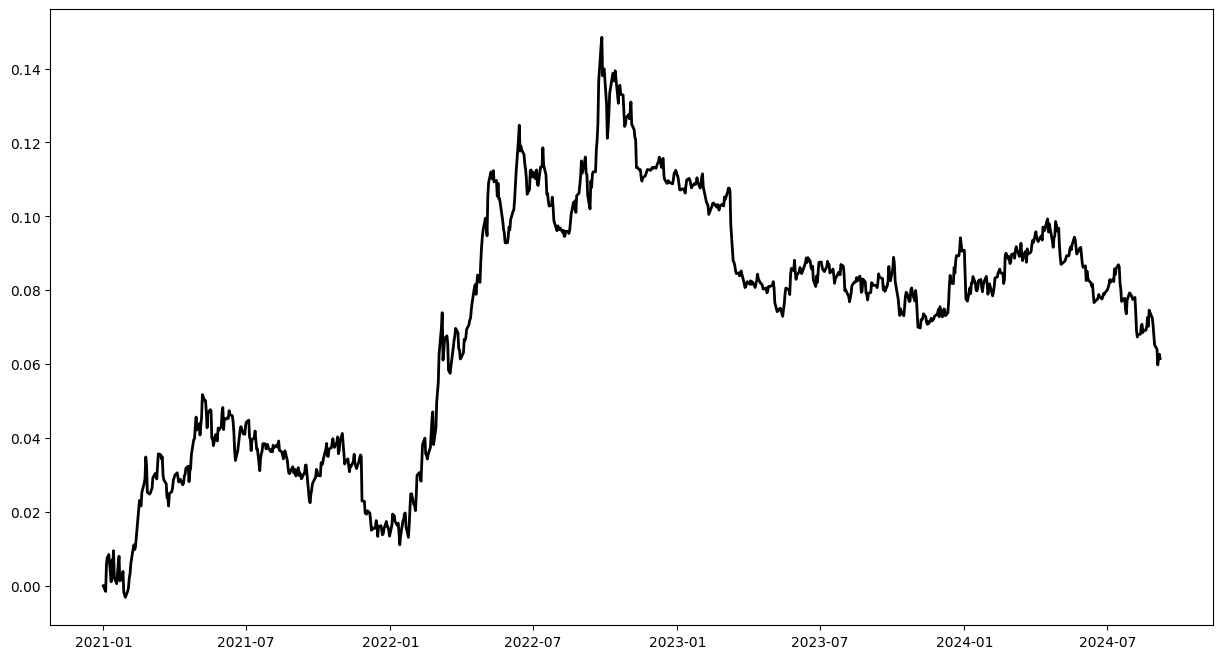

In [115]:
CTA_data = df_w_PTF[df_w_PTF['Contract'].str.contains('EW Portfolio')].copy()
CTA_data_test= CTA_data[CTA_data.Date >= split_date]   #usign same split date as before

# Create the plot
plt.figure(figsize=(15, 8))

# Plot overall EW Portfolio
overall_ptf = CTA_data_test[CTA_data_test['Contract'] == 'EW Portfolio']
plt.plot(overall_ptf['Date'], 
         overall_ptf['Act_Cum_Return']-overall_ptf['Act_Cum_Return'].iloc[0],
         label='Overall EW Portfolio',
         linewidth=2,
         color='black')

metrics_df = calculate_performance_metrics(CTA_data_test, return_column='Act_Return', cum_return_column='Act_Cum_Return')
metrics_df=metrics_df[metrics_df['Grouping_Level']!='Asset Class']	
# Display formatted results
formatted_metrics = display_metrics(metrics_df)
formatted_metrics

# SimpleTransformerClassifier: A Deep Learning Architecture for Time Series Classification

#1. Architectural Overview

The SimpleTransformerClassifier is a neural network designed for time series classification that combines modern deep learning techniques with attention-based processing. The model processes sequential financial data to output trading signals (Buy, Hold, Sells for better gradient flow
4. Add regularization techniques like layer dropout
5. Implement cross-validation for robust evaluation
6. Consider bidirectional processing for temporal patterns


Trying learning rate: 5e-05


C:\Users\claud\anaconda3\envs\ImpCF\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10, Loss: 1.1060
Epoch 6/10, Loss: 1.0849


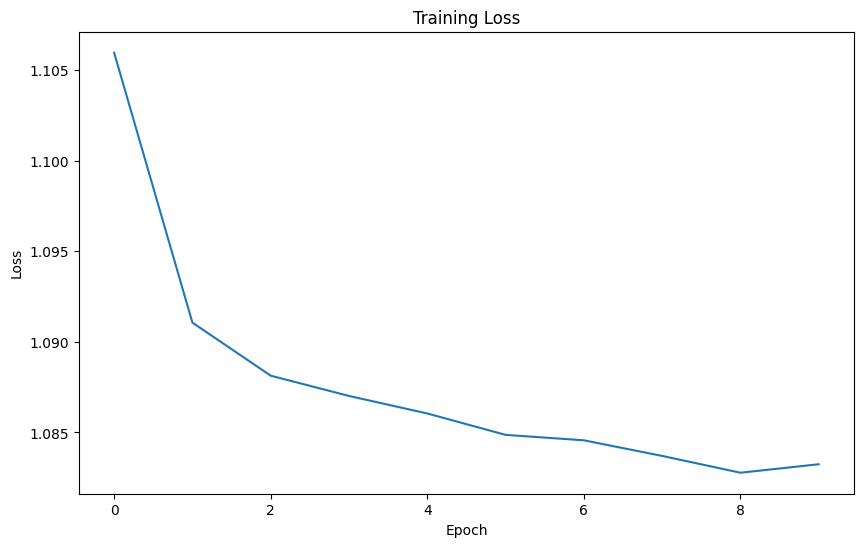


Classification Report:
              precision    recall  f1-score   support

         Buy       0.35      0.38      0.36     12968
        Hold       0.40      0.37      0.38     11426
        Sell       0.40      0.39      0.39     13012

    accuracy                           0.38     37406
   macro avg       0.38      0.38      0.38     37406
weighted avg       0.38      0.38      0.38     37406


Best Model Accuracy: 0.3803


In [102]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y + 1)  # Shift labels from [-1,0,1] to [0,1,2]
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class SimpleTransformerClassifier(nn.Module):
    def __init__(self, input_dim, d_model=32, nhead=2, num_layers=1, num_classes=3):
        super(SimpleTransformerClassifier, self).__init__()
        
        # Initial normalization and embedding
        self.input_norm = nn.LayerNorm(input_dim)
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model)
        )
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model*2,
            dropout=0.2,   # was 0.1
            batch_first=True,
            norm_first=False
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_layers,
            enable_nested_tensor=False
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
    
    def forward(self, x):
        x = self.input_norm(x)
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = torch.mean(x, dim=1)  # Global average pooling
        return self.classifier(x)

def train_evaluate_transformer(df_train, df_test, feature_columns, 
                             sequence_length=20,  # increased
                             batch_size=32,      # increased
                             num_epochs=10,       # increased
                             learning_rate=0.0001):
    """Train and evaluate transformer model"""
    
    # Prepare data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(df_train[feature_columns])
    X_test = scaler.transform(df_test[feature_columns])
    
    # Create sequences
    def create_sequences(X, y):
        sequences = []
        labels = []
        dates = []
        for i in range(len(X) - sequence_length):
            sequences.append(X[i:i+sequence_length])
            labels.append(custom_mapping[y.iloc[i+sequence_length]])
            dates.append(y.index[i+sequence_length])
        return np.array(sequences), np.array(labels), dates
    
    # Prepare sequences
    X_train_seq, y_train, train_dates = create_sequences(X_train, df_train['final_classification'])
    X_test_seq, y_test, test_dates = create_sequences(X_test, df_test['final_classification'])
    
    # Create dataloaders
    train_dataset = TimeSeriesDataset(X_train_seq, y_train)
    test_dataset = TimeSeriesDataset(X_test_seq, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SimpleTransformerClassifier(
        input_dim=len(feature_columns),
        d_model=32,
        nhead=2,
        num_layers=1
    ).to(device)
    
    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.02)   # weight_decay=0.01
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, 
                                 verbose=False, min_lr=1e-6)
    
    # Training loop
    best_loss = float('inf')
    patience = 3  # was 7
    patience_counter = 0
    train_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        batch_count = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Skip NaN losses
            if not torch.isnan(loss):
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                epoch_loss += loss.item()
                batch_count += 1
        
        # Process epoch results
        if batch_count > 0:
            avg_loss = epoch_loss / batch_count
            if not np.isnan(avg_loss):
                train_losses.append(avg_loss)
                scheduler.step(avg_loss)
                
                if avg_loss < best_loss:
                    best_loss = avg_loss
                    best_state = model.state_dict().copy()
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if epoch % 5 == 0:
                    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
                    
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        else:
            print(f"Warning: Epoch {epoch+1} had no valid batches")
            break
    
    # Load best model and evaluate
    if best_state is not None:
        model.load_state_dict(best_state)
    
    model.eval()
    predictions = []
    probabilities = []
    
    with torch.no_grad():
        for batch_X, _ in test_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)
            
            predictions.extend(preds.cpu().numpy() - 1)  # Shift back to [-1,0,1]
            probabilities.extend(probs.cpu().numpy())
    
    predictions = np.array(predictions)
    probabilities = np.array(probabilities)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Date': df_test['Date'].iloc[sequence_length:].reset_index(drop=True),
        'True_Label': [reverse_mapping[y] for y in y_test],
        'Predicted_Label': [reverse_mapping[p] for p in predictions],
        'y_true': y_test,
        'y_pred': predictions,
        'Probability_Sell': probabilities[:, 0],
        'Probability_Hold': probabilities[:, 1],
        'Probability_Buy': probabilities[:, 2]
    })
    
    # Plot training loss if we have valid losses
    if train_losses:
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        '''
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix([reverse_mapping[y] for y in y_test],
                            [reverse_mapping[p] for p in predictions])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Sell', 'Hold', 'Buy'],
                   yticklabels=['Sell', 'Hold', 'Buy'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        '''
        # Print classification report
        print("\nClassification Report:")
        print(classification_report([reverse_mapping[y] for y in y_test],
                                 [reverse_mapping[p] for p in predictions]))
    else:
        print("Warning: No valid losses to plot")
    
    return {
        'model': model,
        'predictions': predictions,
        'probabilities': probabilities,
        'results_df': results_df,
        'accuracy': accuracy_score([reverse_mapping[y] for y in y_test],
                                 [reverse_mapping[p] for p in predictions]),
        'train_losses': train_losses
    }

# Run the model with different learning rates if needed
#learning_rates = [0.0001, 0.00005, 0.00001] 
learning_rates = [0.00005]
best_accuracy = 0
best_results = None

for lr in learning_rates:
    print(f"\nTrying learning rate: {lr}")
    results = train_evaluate_transformer(df_train, df_test, feature_columns, 
                                      sequence_length=60, batch_size=32, num_epochs=10,
                                     learning_rate=lr)
    
    if results['accuracy'] > best_accuracy:
        best_accuracy = results['accuracy']
        best_results = results

print(f"\nBest Model Accuracy: {best_accuracy:.4f}")

# Access final predictions
final_predictions = best_results['results_df']

In [320]:
## Hyper parameter
import itertools

# Define parameter grid
param_grid = {
    'learning_rate': [0.00005],
    'sequence_length': [20, 40, 60],
    'batch_size': [ 32, 64],
    'num_epochs': [10]
}



# Create all combinations of parameters
param_combinations = list(itertools.product(
    param_grid['learning_rate'],
    param_grid['sequence_length'],
    param_grid['batch_size'],
    param_grid['num_epochs']
))

# Initialize results storage
results_list = []

# Run grid search
for lr, seq_len, batch_size, epochs in param_combinations:
    print(f"\nTrying parameters:")
    print(f"Learning rate: {lr}")
    print(f"Sequence length: {seq_len}")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {epochs}")
    
    try:
        results = train_evaluate_transformer(
            df_train, 
            df_test, 
            feature_columns,
            sequence_length=seq_len,
            batch_size=batch_size,
            num_epochs=epochs,
            learning_rate=lr
        )
        
        # Store results in list
        results_list.append({
            'learning_rate': lr,
            'sequence_length': seq_len,
            'batch_size': batch_size,
            'num_epochs': epochs,
            'min_loss': min(results['train_losses']) if results['train_losses'] else float('nan'),
            'accuracy': results['accuracy']
        })
        
        # Print current result
        print(f"Min Loss: {results_list[-1]['min_loss']:.4f}")
        print(f"Accuracy: {results_list[-1]['accuracy']:.4f}")
        
    except Exception as e:
        print(f"Error with parameters: {e}")
        continue

# Create DataFrame with results
results_df = pd.DataFrame(results_list)

# Sort by accuracy descending
results_df = results_df.sort_values('accuracy', ascending=False)

# Display results
print("\nAll Results:")
print(results_df.to_string(index=False, float_format=lambda x: '{:.4f}'.format(x)))

# Save best model results
best_idx = results_df['accuracy'].idxmax()
best_params = results_df.iloc[best_idx]

print("\nBest Parameters:")
print(f"Learning Rate: {best_params['learning_rate']}")
print(f"Sequence Length: {int(best_params['sequence_length'])}")
print(f"Batch Size: {int(best_params['batch_size'])}")
print(f"Epochs: {int(best_params['num_epochs'])}")
print(f"Accuracy: {best_params['accuracy']:.4f}")
print(f"Min Loss: {best_params['min_loss']:.4f}")


Trying parameters:
Learning rate: 5e-05
Sequence length: 20
Batch size: 32
Epochs: 10


C:\Users\claud\anaconda3\envs\ImpCF\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


KeyboardInterrupt: 

<Axes: >

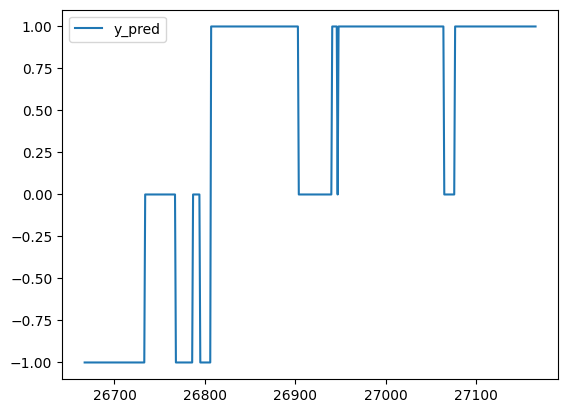

In [106]:

df_test['y_pred']=final_predictions['y_pred']
df_test.tail(100)

df_=df_test[df_test['Contract'] == 'S&P500']    #Gold 100 OZ,  Copper  , Xover , S&P500 ,Nasdaq100,  Euro , Japanese Yen, G,  Brent Crude
df_[['y_pred']].tail(500).plot()



## Make predictions

C:\Users\claud\AppData\Local\Temp\ipykernel_64628\2288575776.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test = df_test.groupby('Contract').apply(calculate_model_returns,target_vol=0.05,include_tc=True).reset_index(drop=True)


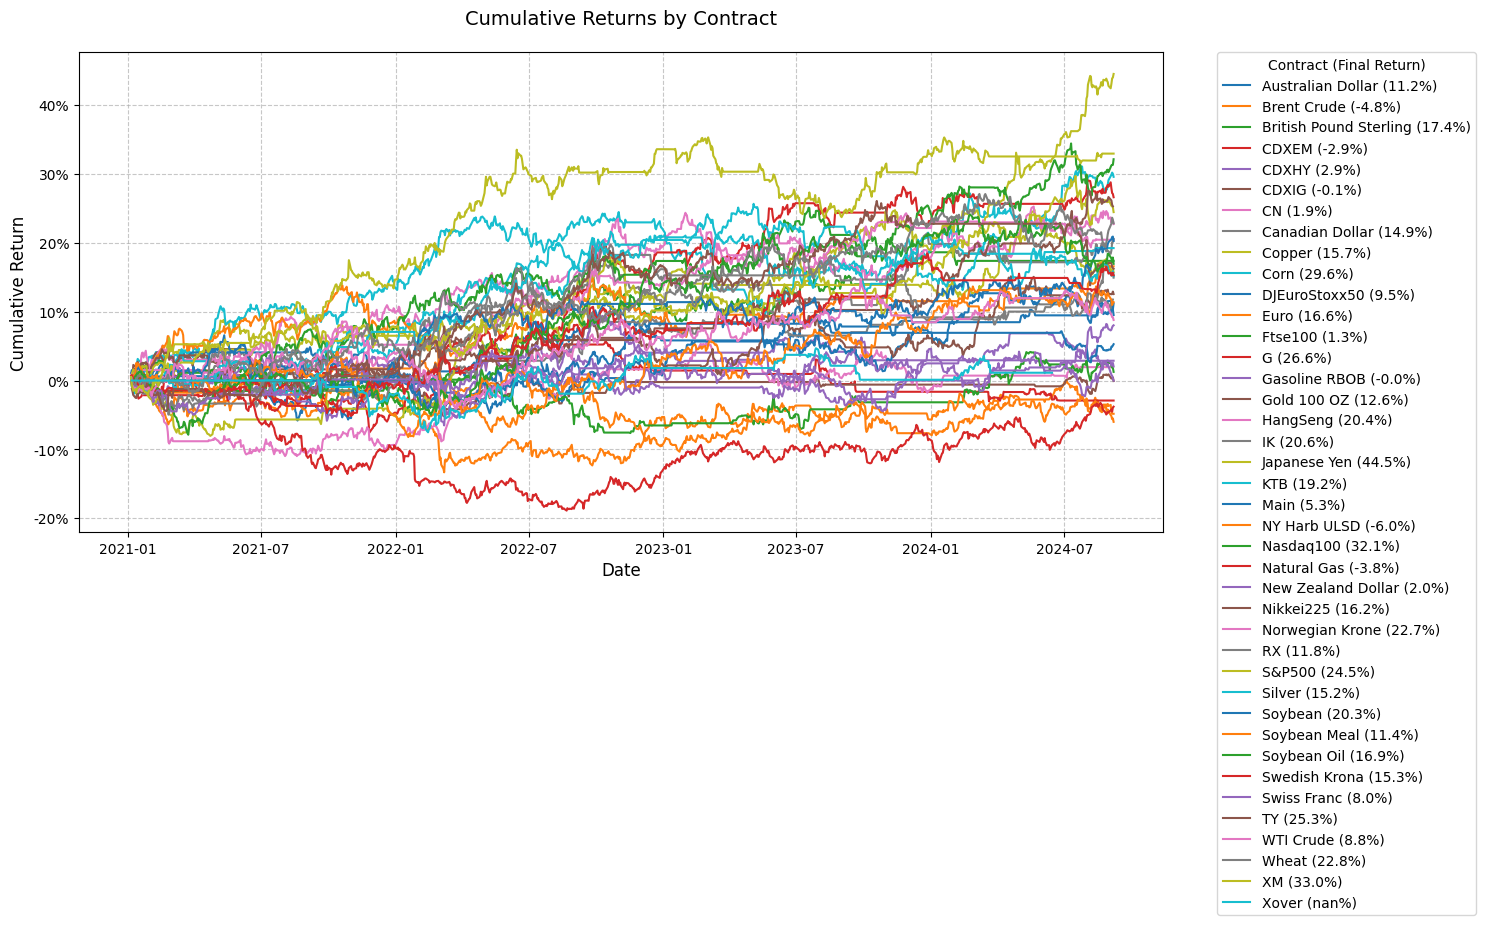

In [108]:
# Function to calculate returns for a signal
def calculate_model_returns(group, target_vol=0.05, include_tc=True):
    # Sort by date
    group = group.sort_values('Date')
    # Apply y_pred - prediction

      # Calculate volatility multiplier with adjustment for lag effect
    # Multiply target_vol by sqrt(2) to compensate for lag effect
    adjusted_target = target_vol * np.sqrt(2) * .9 # Adjustment factor =np.sqrt(2) * .9
    group['Vol_Multiplier'] = np.clip(adjusted_target / group['Rolling_Std'], -5, 5)
    signal_changes = np.abs(group['y_pred'].shift(1) - group['y_pred'].shift(2))

    # Apply prediction and volatility targeting
    if include_tc:
        # Apply signal and subtract transaction costs when signal changes
        group['Act_Return'] = (group['Return'] * group['y_pred'].shift(1) - (signal_changes * group['Transaction_Cost'])/2) * group['Vol_Multiplier'].shift(1)
    else:
        group['Act_Return'] = group['Return'] * group['y_pred'].shift(1)  * group['Vol_Multiplier'].shift(1) # shift(1) ensures we're using previous day's signal

    
    # Apply prediction and volatility targeting
   # group['Act_Return'] = group['Return'] * group['y_pred'].shift(1)  * group['Vol_Multiplier'].shift(1) # shift(1) ensures we're using previous day's signal
    group.loc[group.index[0], 'Act_Return'] = 0
    group['Act_Cum_Return'] = (1 + group['Act_Return']).cumprod() - 1
    
    return group

# Calculate returns
df_test = df_test.groupby('Contract').apply(calculate_model_returns,target_vol=0.05,include_tc=True).reset_index(drop=True)

# Plot cumulative returns for each contract
plt.figure(figsize=(15, 8))
for contract in df_test['Contract'].unique():
    contract_data = df_test[df_test['Contract'] == contract]
    plt.plot(contract_data['Date'], contract_data['Act_Cum_Return'], 
             label=f'{contract} ({contract_data["Act_Cum_Return"].iloc[-1]:.1%})')

# Add plot formatting
plt.title('Cumulative Returns by Contract', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Add legend with better formatting
plt.legend(title='Contract (Final Return)', 
          bbox_to_anchor=(1.05, 1),  # Position legend outside plot
          loc='upper left',
          borderaxespad=0.,
          fontsize=10)

# Adjust layout to prevent legend cutoff
plt.tight_layout()

# Show plot
plt.show()


In [110]:

def calculate_performance_metrics(df, return_column='Act_Return', cum_return_column='Act_Cum_Return'):
   
    def calculate_metrics(group):
        # Assuming daily returns, adjust accordingly if using different frequency
        trading_days = 252
        
        # Basic return metrics
        total_return = (1 + group[return_column]).prod() - 1
        periods = len(group)
        annualized_return = (1 + total_return) ** (trading_days / periods) - 1
        
        # Risk metrics
        daily_vol = group[return_column].std()
        annualized_vol = daily_vol * np.sqrt(trading_days)
        
        # Sharpe Ratio (assuming 0% risk-free rate for simplicity)
        sharpe_ratio = annualized_return / annualized_vol if annualized_vol != 0 else 0
        
        # Maximum Drawdown
        cum_returns = group[cum_return_column]
        rolling_max = cum_returns.expanding().max()
        drawdowns = cum_returns - rolling_max
        max_drawdown = drawdowns.min()
        
        # Higher moments
        skewness = stats.skew(group[return_column])
        kurtosis = stats.kurtosis(group[return_column])
        
        return pd.Series({
            'Annualized_Return': annualized_return,
            'Annualized_Volatility': annualized_vol,
            'Sharpe_Ratio': sharpe_ratio,
            'Max_Drawdown': max_drawdown,
            'Skewness': skewness,
            'Kurtosis': kurtosis,
            'Total_Return': total_return,
            'Number_of_Periods': periods
        })
    
    # Calculate metrics by Asset Class
    asset_class_metrics = df.groupby('Asset Class').apply(calculate_metrics)
    asset_class_metrics = asset_class_metrics.reset_index()
    asset_class_metrics['Contract'] = 'AssetGroup'
    asset_class_metrics['Grouping_Level'] = 'Asset Class'
    
    # Calculate metrics by Contract
    contract_metrics = df.groupby(['Asset Class', 'Contract']).apply(calculate_metrics)
    contract_metrics = contract_metrics.reset_index()
    contract_metrics['Grouping_Level'] = 'Contract'
    
    # Combine metrics
    combined_metrics = pd.concat([asset_class_metrics, contract_metrics], ignore_index=True)
    
    # Format metrics as percentages where appropriate
    percentage_columns = ['Annualized_Return', 'Annualized_Volatility', 'Max_Drawdown', 'Total_Return']
    for col in percentage_columns:
        combined_metrics[col] = combined_metrics[col] * 100
    
    return combined_metrics

def display_metrics(metrics_df):
    """
    Format and display the performance metrics in a readable format.
    """
    formatted_df = metrics_df.copy()
    
    # Format percentage columns
    percentage_cols = ['Annualized_Return', 'Annualized_Volatility', 'Max_Drawdown', 'Total_Return']
    for col in percentage_cols:
        formatted_df[col] = formatted_df[col].round(2).astype(str) + '%'
    
    # Format other numeric columns
    formatted_df['Sharpe_Ratio'] = formatted_df['Sharpe_Ratio'].round(2)
    formatted_df['Skewness'] = formatted_df['Skewness'].round(2)
    formatted_df['Kurtosis'] = formatted_df['Kurtosis'].round(2)
    
    # Reorder columns
    column_order = [
        'Asset Class',
        'Contract',
        'Grouping_Level',
        'Annualized_Return',
        'Annualized_Volatility',
        'Sharpe_Ratio',
        'Max_Drawdown',
        'Skewness',
        'Kurtosis',
        'Total_Return',
        'Number_of_Periods'
    ]
    formatted_df = formatted_df[column_order]
    
    # Sort by Asset_Class and Grouping_Level (Asset_Class level first, then Contract level)
    formatted_df = formatted_df.sort_values(['Asset Class', 'Grouping_Level', 'Contract'])
    
    return formatted_df
# Calculate metrics
metrics_df = calculate_performance_metrics(df_test)

# Display formatted results
formatted_metrics = display_metrics(metrics_df)
formatted_metrics

C:\Users\claud\AppData\Local\Temp\ipykernel_64628\3778355060.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  asset_class_metrics = df.groupby('Asset Class').apply(calculate_metrics)
C:\Users\claud\AppData\Local\Temp\ipykernel_64628\3778355060.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  contract_metrics = df.groupby(['Asset Class', 'Contract']).apply(calculate_metrics)


Asset Class                Contract Grouping_Level Annualized_Return  \
0         Bond              AssetGroup    Asset Class              4.9%   
5         Bond                      CN       Contract             0.53%   
6         Bond                       G       Contract             6.38%   
7         Bond                      IK       Contract             5.12%   
8         Bond                     KTB       Contract             5.15%   
9         Bond                      RX       Contract             3.01%   
10        Bond                      TY       Contract             6.33%   
11        Bond                      XM       Contract             7.76%   
1       Comdty              AssetGroup    Asset Class             2.65%   
12      Comdty             Brent Crude       Contract             -1.3%   
13      Comdty                  Copper       Contract             4.05%   
14      Comdty                    Corn       Contract              7.3%   
15      Comdty           Gasoline RBOB       Contract             -0.0%   
16      Comdty             Gold 100 OZ       Contract             3.27%   
17      Comdty            NY Harb ULSD       Contract            -1.67%   
18      Comdty             Natural Gas       Contract            -1.05%   
19      Comdty                  Silver       Contract             3.91%   
20      Comdty                 Soybean       Contract             5.14%   
21      Comdty            Soybean Meal       Contract             2.98%   
22      Comdty             Soybean Oil       Contract             4.35%   
23      Comdty               WTI Crude       Contract             2.32%   
24      Comdty                   Wheat       Contract             5.75%   
2       Credit              AssetGroup    Asset Class             0.33%   
25      Credit                   CDXEM       Contract            -0.81%   
26      Credit                   CDXHY       Contract             0.78%   
27      Credit                   CDXIG       Contract            -0.02%   
28      Credit                    Main       Contract             1.41%   
29      Credit                   Xover       Contract             0.31%   
3       Equity              AssetGroup    Asset Class             4.31%   
30      Equity           DJEuroStoxx50       Contract             2.46%   
31      Equity                 Ftse100       Contract             0.33%   
32      Equity                HangSeng       Contract             5.12%   
33      Equity               Nasdaq100       Contract             7.87%   
34      Equity               Nikkei225       Contract             4.29%   
35      Equity                  S&P500       Contract             6.13%   
4           FX              AssetGroup    Asset Class             4.08%   
36          FX       Australian Dollar       Contract             2.82%   
37          FX  British Pound Sterling       Contract             4.29%   
38          FX         Canadian Dollar       Contract             3.72%   
39          FX                    Euro       Contract             4.11%   
40          FX            Japanese Yen       Contract            10.14%   
41          FX      New Zealand Dollar       Contract             0.53%   
42          FX         Norwegian Krone       Contract             5.52%   
43          FX           Swedish Krona       Contract              3.8%   
44          FX             Swiss Franc       Contract             2.04%   

   Annualized_Volatility  Sharpe_Ratio Max_Drawdown  Skewness  Kurtosis  \
0                  5.82%          0.84      -34.03%       NaN       NaN   
5                  5.84%          0.09      -10.97%       NaN       NaN   
6                  6.05%          1.06       -5.76%       NaN       NaN   
7                  5.75%          0.89       -7.01%       NaN       NaN   
8                  5.99%          0.86      -11.46%       NaN       NaN   
9                  5.33%          0.57      -11.62%       NaN       NaN   
10                 5.91%   

## Averaging out

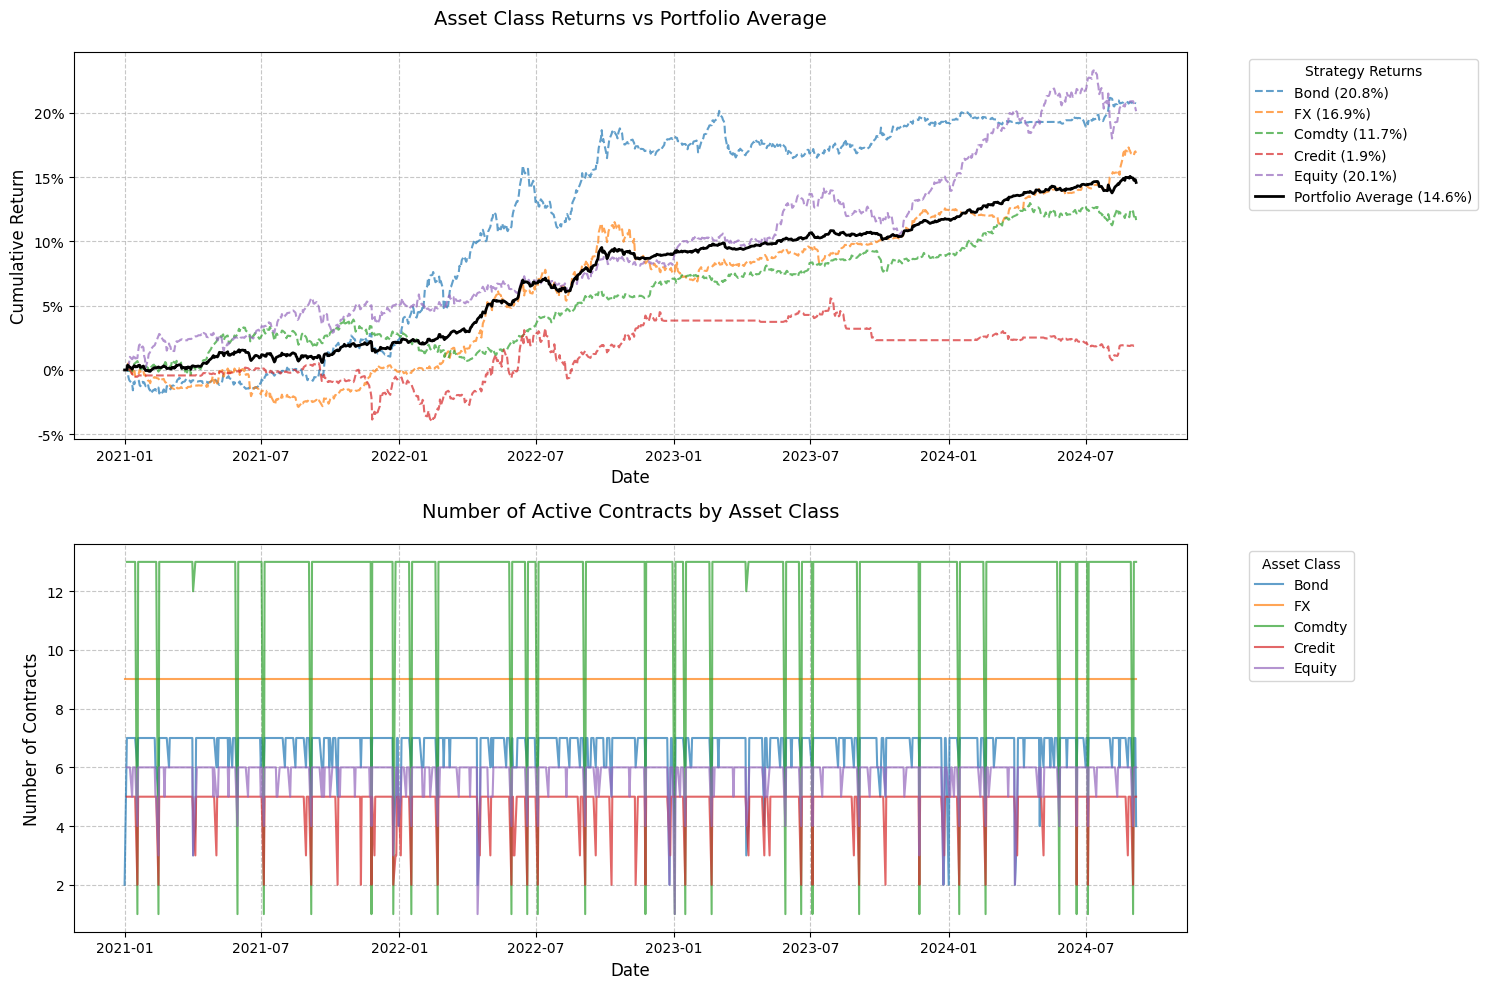


Performance Metrics for Portfolio and Asset Classes:


C:\Users\claud\AppData\Local\Temp\ipykernel_64628\3778355060.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  asset_class_metrics = df.groupby('Asset Class').apply(calculate_metrics)
C:\Users\claud\AppData\Local\Temp\ipykernel_64628\3778355060.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  contract_metrics = df.groupby(['Asset Class', 'Contract']).apply(calculate_metrics)


Asset Class           Contract Grouping_Level Annualized_Return  \
0         Bond         AssetGroup    Asset Class             5.07%   
1       Comdty         AssetGroup    Asset Class             2.95%   
2       Credit         AssetGroup    Asset Class             0.49%   
3       Equity         AssetGroup    Asset Class             4.94%   
4           FX         AssetGroup    Asset Class             4.18%   
5    Portfolio         AssetGroup    Asset Class             3.64%   
25   Portfolio  Portfolio Average       Contract             3.64%   

   Annualized_Volatility  Sharpe_Ratio Max_Drawdown  Skewness  Kurtosis  \
0                  3.32%          1.53       -4.91%     -0.40      4.31   
1                  2.37%          1.25       -3.23%       NaN       NaN   
2                  2.99%          0.16       -4.83%       NaN       NaN   
3                   3.2%          1.54       -5.38%       NaN       NaN   
4                  3.08%          1.36       -4.62%       NaN       NaN   
5                  1.59%          2.29        -1.1%     -0.29      4.73   
25                 1.59%          2.29        -1.1%     -0.29      4.73   

   Total_Return  Number_of_Periods  
0        20.77%              961.0  
1        11.66%              955.0  
2         1.86%              949.0  
3        20.14%              959.0  
4        16.89%              961.0  
5        14.59%              961.0  
25       14.59%              961.0

In [113]:
# First, get daily average returns across all contracts (Portfolio level)
daily_avg_strategy = df_test.groupby('Date').agg({
    'Act_Return': 'mean',  # Average return across all contracts
    'Contract': 'count'    # Number of active contracts
}).reset_index()

# Calculate daily average returns by Asset Class
daily_asset_class_returns = df_test.groupby(['Date', 'Asset Class']).agg({
    'Act_Return': 'mean',  # Average return within asset class
    'Contract': 'count'    # Number of active contracts in asset class
}).reset_index()

# Calculate cumulative returns
daily_avg_strategy['Act_Cum_Return'] = (1 + daily_avg_strategy['Act_Return']).cumprod() - 1

# Calculate cumulative returns for each Asset Class
for asset_class in daily_asset_class_returns['Asset Class'].unique():
    asset_data = daily_asset_class_returns[daily_asset_class_returns['Asset Class'] == asset_class]
    daily_asset_class_returns.loc[daily_asset_class_returns['Asset Class'] == asset_class, 'Act_Cum_Return'] = \
        (1 + asset_data['Act_Return']).cumprod() - 1

# Create visualization
plt.figure(figsize=(15, 10))

# Plot 1: Returns by Asset Class and Portfolio Average
plt.subplot(2, 1, 1)
# Plot each Asset Class
for asset_class in daily_asset_class_returns['Asset Class'].unique():
    asset_data = daily_asset_class_returns[daily_asset_class_returns['Asset Class'] == asset_class]
    final_return = asset_data['Act_Cum_Return'].iloc[-1]
    plt.plot(asset_data['Date'], asset_data['Act_Cum_Return'], 
             alpha=0.7, linestyle='--', 
             label=f'{asset_class} ({final_return:.1%})')

# Plot Portfolio Average
plt.plot(daily_avg_strategy['Date'], daily_avg_strategy['Act_Cum_Return'], 
         linewidth=2, color='black', 
         label=f'Portfolio Average ({daily_avg_strategy["Act_Cum_Return"].iloc[-1]:.1%})')

plt.title('Asset Class Returns vs Portfolio Average', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(title='Strategy Returns', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Number of active contracts by Asset Class
plt.subplot(2, 1, 2)
for asset_class in daily_asset_class_returns['Asset Class'].unique():
    asset_data = daily_asset_class_returns[daily_asset_class_returns['Asset Class'] == asset_class]
    plt.plot(asset_data['Date'], asset_data['Contract'], 
             label=asset_class, alpha=0.7)

plt.title('Number of Active Contracts by Asset Class', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Contracts', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Asset Class', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Prepare data for performance metrics
# Portfolio level metrics
portfolio_df = daily_avg_strategy.copy()
portfolio_df['Asset Class'] = 'Portfolio'
portfolio_df['Contract'] = 'Portfolio Average'

# Combine portfolio and asset class data
asset_class_data = daily_asset_class_returns.copy()
metrics_data = pd.concat([
    portfolio_df[['Date', 'Asset Class', 'Contract', 'Act_Return', 'Act_Cum_Return']],
    asset_class_data[['Date', 'Asset Class', 'Contract', 'Act_Return', 'Act_Cum_Return']]
])

# Calculate performance metrics
metrics_df = calculate_performance_metrics(metrics_data)

# Keep only Portfolio and Asset Class level metrics (remove individual contracts)
metrics_df = metrics_df[metrics_df['Contract'].isin(['Portfolio Average', 'AssetGroup'])]

# Display formatted metrics
formatted_metrics = display_metrics(metrics_df)
print("\nPerformance Metrics for Portfolio and Asset Classes:")
formatted_metrics